# Bert baseline for POLAR

## Introduction

In this part of the starter notebook, we will take you through the process of all three Subtasks.

## Subtask 1 - Polarization detection

This is a binary classification to determine whether a post contains polarized content (Polarized or Not Polarized).

## 1.1 English polarization

### 1.1.1 libraries packages


Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np

import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

In [ ]:
!unzip /content/drive/MyDrive/starter.zip

unzip:  cannot find or open /content/drive/MyDrive/starter.zip, /content/drive/MyDrive/starter.zip.zip or /content/drive/MyDrive/starter.zip.ZIP.


In [ ]:
!unzip /content/drive/MyDrive/dev_phase.zip

Archive:  /content/drive/MyDrive/dev_phase.zip
   creating: subtask1/
   creating: subtask1/dev/
  inflating: subtask1/dev/nep.csv    
  inflating: subtask1/dev/ita.csv    
  inflating: subtask1/dev/pol.csv    
  inflating: subtask1/dev/rus.csv    
  inflating: subtask1/dev/tel.csv    
  inflating: subtask1/dev/hin.csv    
  inflating: subtask1/dev/hau.csv    
  inflating: subtask1/dev/pan.csv    
  inflating: subtask1/dev/ori.csv    
  inflating: subtask1/dev/spa.csv    
  inflating: subtask1/dev/deu.csv    
  inflating: subtask1/dev/fas.csv    
  inflating: subtask1/dev/arb.csv    
  inflating: subtask1/dev/ben.csv    
  inflating: subtask1/dev/amh.csv    
  inflating: subtask1/dev/khm.csv    
  inflating: subtask1/dev/tur.csv    
  inflating: subtask1/dev/zho.csv    
  inflating: subtask1/dev/eng.csv    
  inflating: subtask1/dev/swa.csv    
  inflating: subtask1/dev/urd.csv    
  inflating: subtask1/dev/mya.csv    
   creating: subtask1/train/
  inflating: subtask1/train/nep.csv  


In [ ]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

### 1.1.2 Data Import

The training data consists of a short text and binary labels

The data is structured as a CSV file with the following fields:
- id: a unique identifier for the sample
- text: a sentence or short text
- polarization:  1 text is polarized, 0 text is not polarized

The data is in all three subtask folders the same but only containing the labels for the specific task.

# 3. Subtask 3: Manifestation Identification
Multi-label classification to classify how polarization is expressed, with multiple possible labels including Vilification, Extreme Language, Stereotype, Invalidation, Lack of Empathy, and Dehumanization.



## 3.1 English

In [ ]:
train_initial = pd.read_csv('subtask3/train/eng.csv')
val = pd.read_csv('subtask3/train/eng.csv')

train_initial.head()

id  \
0  eng_973938b90b0ff5d87d35a582f83f5c89   
1  eng_07dfd4600426caca6e2c5883fcbea9ea   
2  eng_f14519ff2302b6cd47712073f13bc461   
3  eng_e48b7e7542faafa544ac57b64bc80daf   
4  eng_7c581fb77bce8033aeba3d6dbd6273eb   

                                                text  stereotype  \
0           is defending imperialism in the dnd chat           0   
1  Still playing with this. I am now following Ra...           0   
2  .senate.gov Theres 3 groups out there Republic...           0   
3  "ABC MD, David Anderson, said the additional f...           0   
4  "bad people" I have some conservative values s...           0   

   vilification  dehumanization  extreme_language  lack_of_empathy  \
0             0               0                 0                0   
1             0               0                 0                0   
2             0               0                 0                0   
3             0               0                 0                0   
4             0               0                 0                0   

   invalidation  
0             0  
1             0  
2             0  
3             0  
4             0

### 3.1.1 Data exploration

In [ ]:
print("First rows of the dataset:")
print(train_initial.head())

print("\n" + "=" * 80)
print("Dataset information:")
print(train_initial.info())

print("\n" + "=" * 80)
print("Dataset shape:")
print(f"Number of rows: {train_initial.shape[0]}")
print(f"Number of columns: {train_initial.shape[1]}")

print("\n" + "=" * 80)
print("Column names:")
print(train_initial.columns.tolist())

print("\n" + "=" * 80)
print("Missing values:")
print(train_initial.isnull().sum())

print("\n" + "=" * 80)
print("Descriptive statistics:")
print(train_initial.describe())


First rows of the dataset:
                                     id  \
0  eng_973938b90b0ff5d87d35a582f83f5c89   
1  eng_07dfd4600426caca6e2c5883fcbea9ea   
2  eng_f14519ff2302b6cd47712073f13bc461   
3  eng_e48b7e7542faafa544ac57b64bc80daf   
4  eng_7c581fb77bce8033aeba3d6dbd6273eb   

                                                text  stereotype  \
0           is defending imperialism in the dnd chat           0   
1  Still playing with this. I am now following Ra...           0   
2  .senate.gov Theres 3 groups out there Republic...           0   
3  "ABC MD, David Anderson, said the additional f...           0   
4  "bad people" I have some conservative values s...           0   

   vilification  dehumanization  extreme_language  lack_of_empathy  \
0             0               0                 0                0   
1             0               0                 0                0   
2             0               0                 0                0   
3             0          

1. DISTRIBUTION OF POLARIZATION MANIFESTATIONS

Absolute and relative frequencies:
vilification        :  858 (26.63%)
extreme_language    :  770 (23.90%)
invalidation        :  586 (18.19%)
stereotype          :  487 (15.11%)
dehumanization      :  391 (12.14%)
lack_of_empathy     :  357 (11.08%)


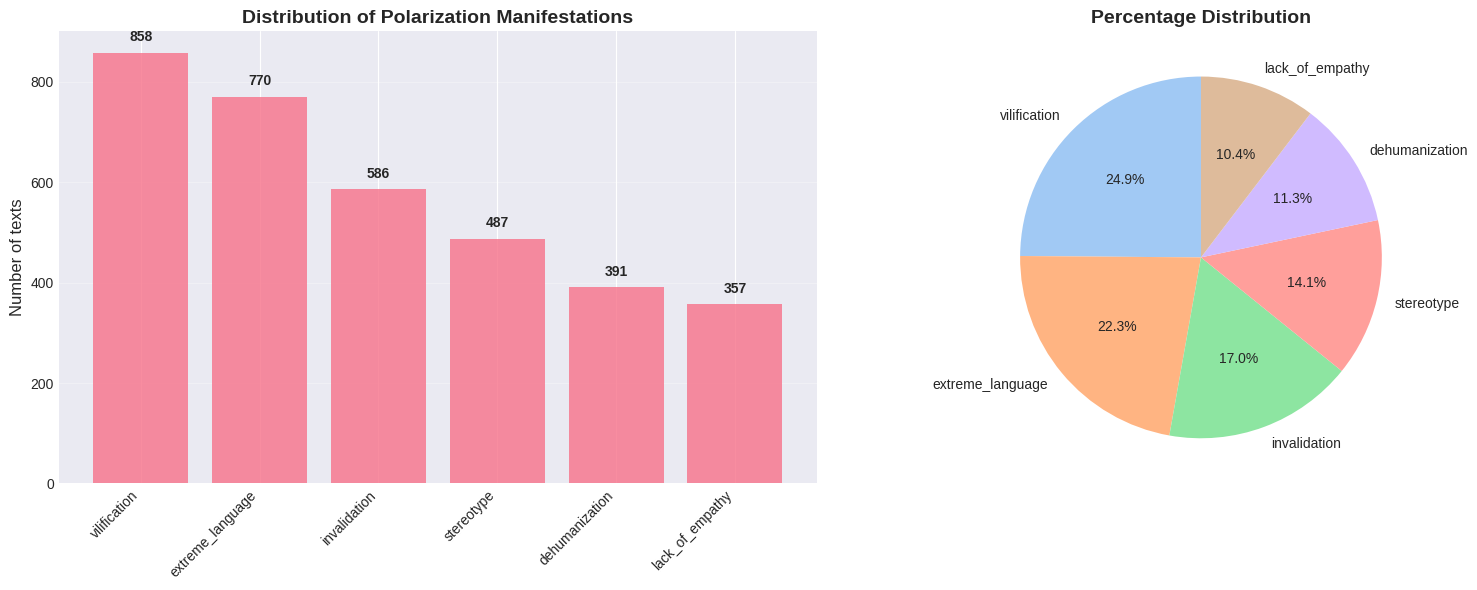

In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (15, 8)

print("=" * 80)
print("1. DISTRIBUTION OF POLARIZATION MANIFESTATIONS")
print("=" * 80)

label_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

label_counts = train_initial[label_cols].sum().sort_values(ascending=False)
label_percentages = (label_counts / len(train_initial) * 100).round(2)

print("\nAbsolute and relative frequencies:")
for label, count in label_counts.items():
    pct = label_percentages[label]
    print(f"{label:20s}: {count:4d} ({pct:5.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(
    range(len(label_counts)),
    label_counts.values,
    alpha=0.8
)
axes[0].set_xticks(range(len(label_counts)))
axes[0].set_xticklabels(label_counts.index, rotation=45, ha="right")
axes[0].set_ylabel("Number of texts", fontsize=12)
axes[0].set_title(
    "Distribution of Polarization Manifestations",
    fontsize=14,
    fontweight="bold"
)
axes[0].grid(axis="y", alpha=0.3)

for i, v in enumerate(label_counts.values):
    axes[0].text(
        i,
        v + 0.02 * max(label_counts.values),
        str(v),
        ha="center",
        va="bottom",
        fontweight="bold"
    )

colors = sns.color_palette("pastel", len(label_counts))
axes[1].pie(
    label_counts.values,
    labels=label_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors
)
axes[1].set_title(
    "Percentage Distribution",
    fontsize=14,
    fontweight="bold"
)

plt.tight_layout()
plt.show()


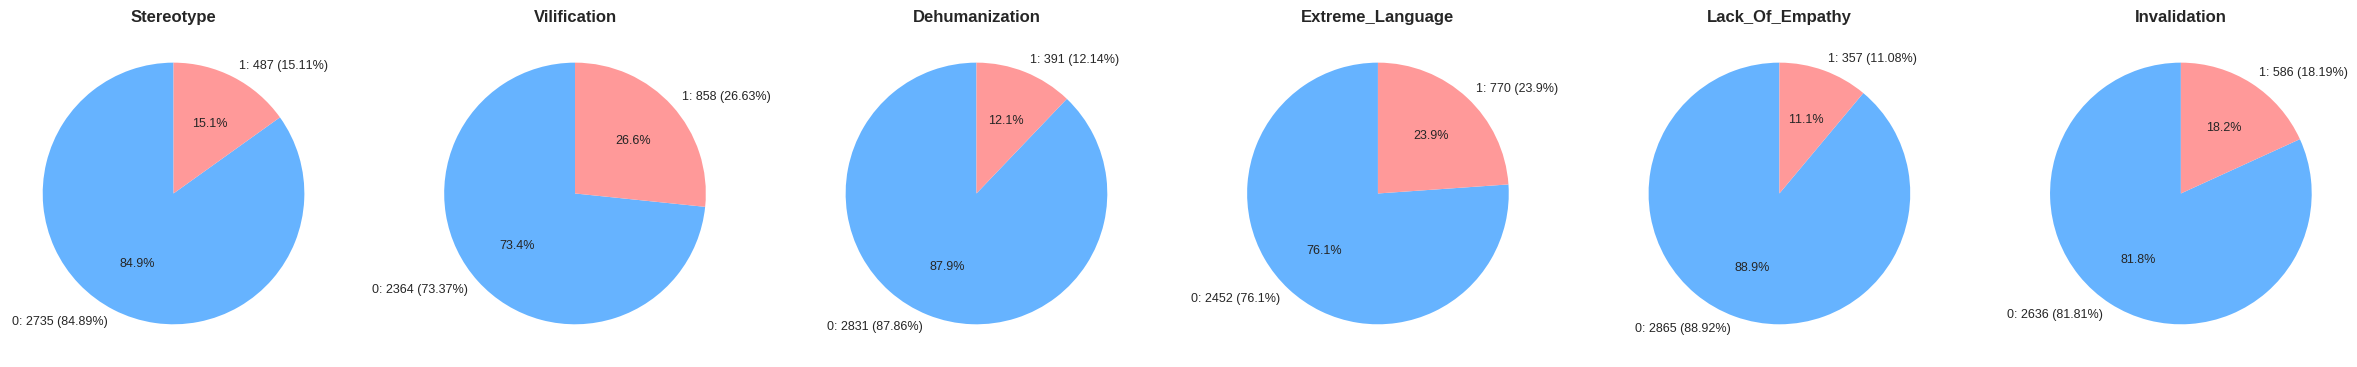

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

label_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

colors_map = {0: '#66b3ff', 1: '#ff9999'}

# -----------------------------
# Create subplots (1 row)
# -----------------------------
fig, axes = plt.subplots(
    1, len(label_cols),
    figsize=(4 * len(label_cols), 5)
)



for ax, label in zip(axes, label_cols):
    label_counts = train_initial[label].value_counts().sort_index()

    # Ensure both classes exist
    label_counts = label_counts.reindex([0, 1], fill_value=0)

    total = label_counts.sum()
    neg, pos = label_counts[0], label_counts[1]

    pct_neg = round(neg / total * 100, 2)
    pct_pos = round(pos / total * 100, 2)



    sizes = [neg, pos]
    labels_pie = [
        f'0: {neg} ({pct_neg}%)',
        f'1: {pos} ({pct_pos}%)'
    ]
    colors = [colors_map[0], colors_map[1]]

    ax.pie(
        sizes,
        labels=labels_pie,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        textprops={'fontsize': 9}
    )

    ax.set_title(label.replace('/', ' / ').title(), fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('Distribution_target_subtask_3_english.pdf')
plt.show()


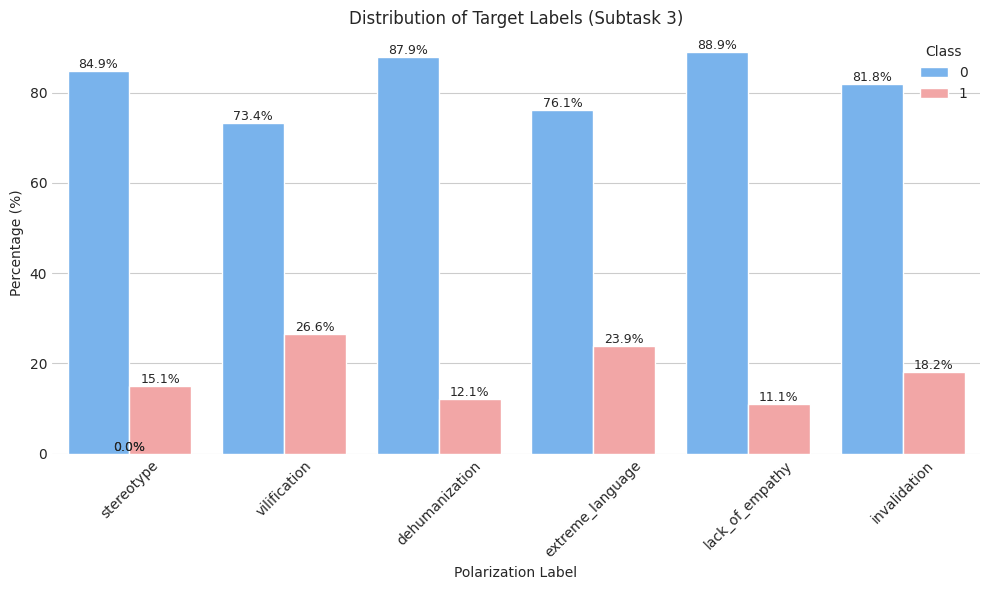

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

label_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

colors_map = {0: '#66b3ff', 1: '#ff9999'}  # Couleurs comme ton pie chart

# Préparer les données
data = []
for label in label_cols:
    counts = train_initial[label].value_counts().reindex([0,1], fill_value=0)
    total = counts.sum()
    for cls, cnt in counts.items():
        data.append({'Label': label, 'Class': cls, 'Count': cnt, 'Pct': cnt/total*100})

df_plot = pd.DataFrame(data)

# Créer le bar plot
plt.figure(figsize=(10,6))
bars = sns.barplot(x='Label', y='Pct', hue='Class', data=df_plot,
                   palette=[colors_map[0], colors_map[1]])

plt.ylabel('Percentage (%)')
plt.xlabel('Polarization Label')
plt.title('Distribution of Target Labels (Subtask 3)')
plt.xticks(rotation=45)

# Ajouter les pourcentages sur chaque barre
for p in bars.patches:
    height = p.get_height()
    bars.annotate(f'{height:.1f}%',
                  (p.get_x() + p.get_width() / 2., height),
                  ha='center', va='bottom', fontsize=9)

plt.legend(title='Class')
plt.tight_layout()
plt.savefig('Distribution_target_subtask_3_english_barplot.pdf')
plt.show()


#### independance

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
label_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]


results = []

for i in range(len(label_cols)):
    for j in range(i + 1, len(label_cols)):
        label_i = label_cols[i]
        label_j = label_cols[j]

        # Table de contingence
        contingency_table = pd.crosstab(
            train_initial[label_i],
            train_initial[label_j]
        )

        # Test Khi-deux
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        results.append({
            'Label 1': label_i,
            'Label 2': label_j,
            'Chi2': chi2,
            'p-value': p,
            'DoF': dof
        })

# Résultats sous forme de DataFrame
chi2_results = pd.DataFrame(results).sort_values('p-value')
print("independance analysis in manifestation of polarization identification for englihs language in our dataset")
print(chi2_results)


independance analysis in manifestation of polarization identification for englihs language in our dataset
             Label 1           Label 2       Chi2       p-value  DoF
9     dehumanization  extreme_language  97.349953  5.809604e-23    1
2         stereotype  extreme_language  64.678423  8.817515e-16    1
6       vilification  extreme_language  13.223961  2.763930e-04    1
3         stereotype   lack_of_empathy  13.164174  2.853525e-04    1
10    dehumanization   lack_of_empathy  10.771025  1.031014e-03    1
13  extreme_language      invalidation   5.756071  1.643178e-02    1
0         stereotype      vilification   3.653717  5.594423e-02    1
4         stereotype      invalidation   3.388284  6.566126e-02    1
1         stereotype    dehumanization   3.309546  6.887853e-02    1
12  extreme_language   lack_of_empathy   2.545032  1.106417e-01    1
5       vilification    dehumanization   0.585436  4.441895e-01    1
7       vilification   lack_of_empathy   0.000000  1.000000e+00   

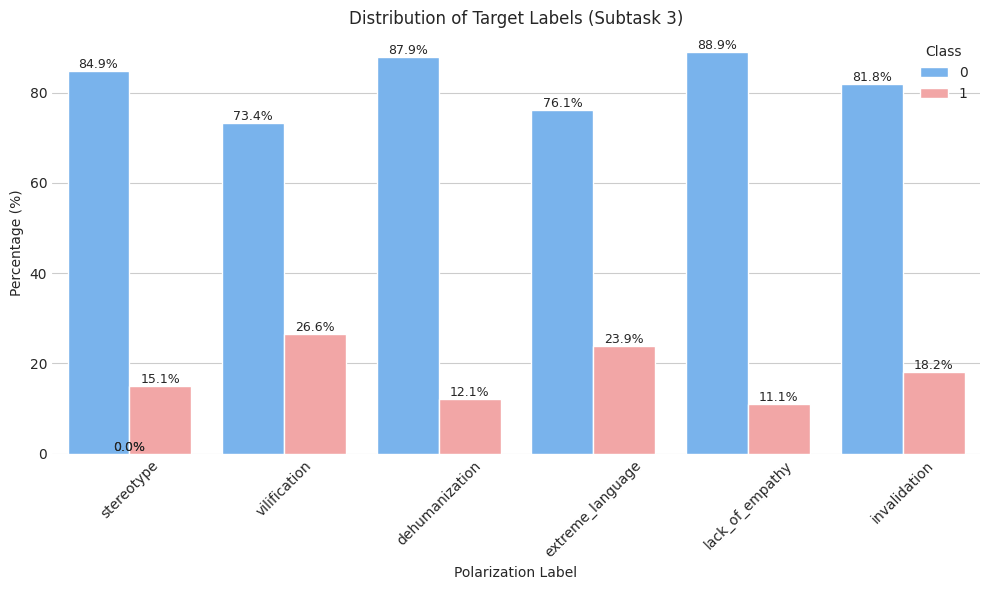

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

label_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

colors_map = {0: '#66b3ff', 1: '#ff9999'}  # Couleurs comme ton pie chart

# Préparer les données
data = []
for label in label_cols:
    counts = train_initial[label].value_counts().reindex([0,1], fill_value=0)
    total = counts.sum()
    for cls, cnt in counts.items():
        data.append({'Label': label, 'Class': cls, 'Count': cnt, 'Pct': cnt/total*100})

df_plot = pd.DataFrame(data)

# Créer le bar plot
plt.figure(figsize=(10,6))
bars = sns.barplot(x='Label', y='Pct', hue='Class', data=df_plot,
                   palette=[colors_map[0], colors_map[1]])

plt.ylabel('Percentage (%)')
plt.xlabel('Polarization Label')
plt.title('Distribution of Target Labels (Subtask 3)')
plt.xticks(rotation=45)

# Ajouter les pourcentages sur chaque barre
for p in bars.patches:
    height = p.get_height()
    bars.annotate(f'{height:.1f}%',
                  (p.get_x() + p.get_width() / 2., height),
                  ha='center', va='bottom', fontsize=9)

plt.legend(title='Class')
plt.tight_layout()
plt.savefig('Distribution_target_subtask_3_english_barplot.pdf')
plt.show()


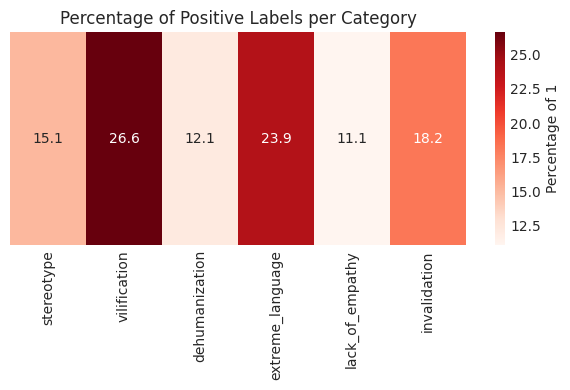

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

label_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

# Calculer le pourcentage de 1
pct_1 = train_initial[label_cols].mean() * 100
df_heat = pd.DataFrame(pct_1, columns=['Pct_Pos'])

plt.figure(figsize=(6,4))
sns.heatmap(df_heat.T, annot=True, fmt=".1f", cmap="Reds", cbar_kws={'label': 'Percentage of 1'})
plt.yticks([],[])
plt.title('Percentage of Positive Labels per Category')
plt.tight_layout()
plt.savefig('Distribution_target_subtask_3_english_heatmap.pdf')
plt.show()



3. TEXT LENGTH ANALYSIS


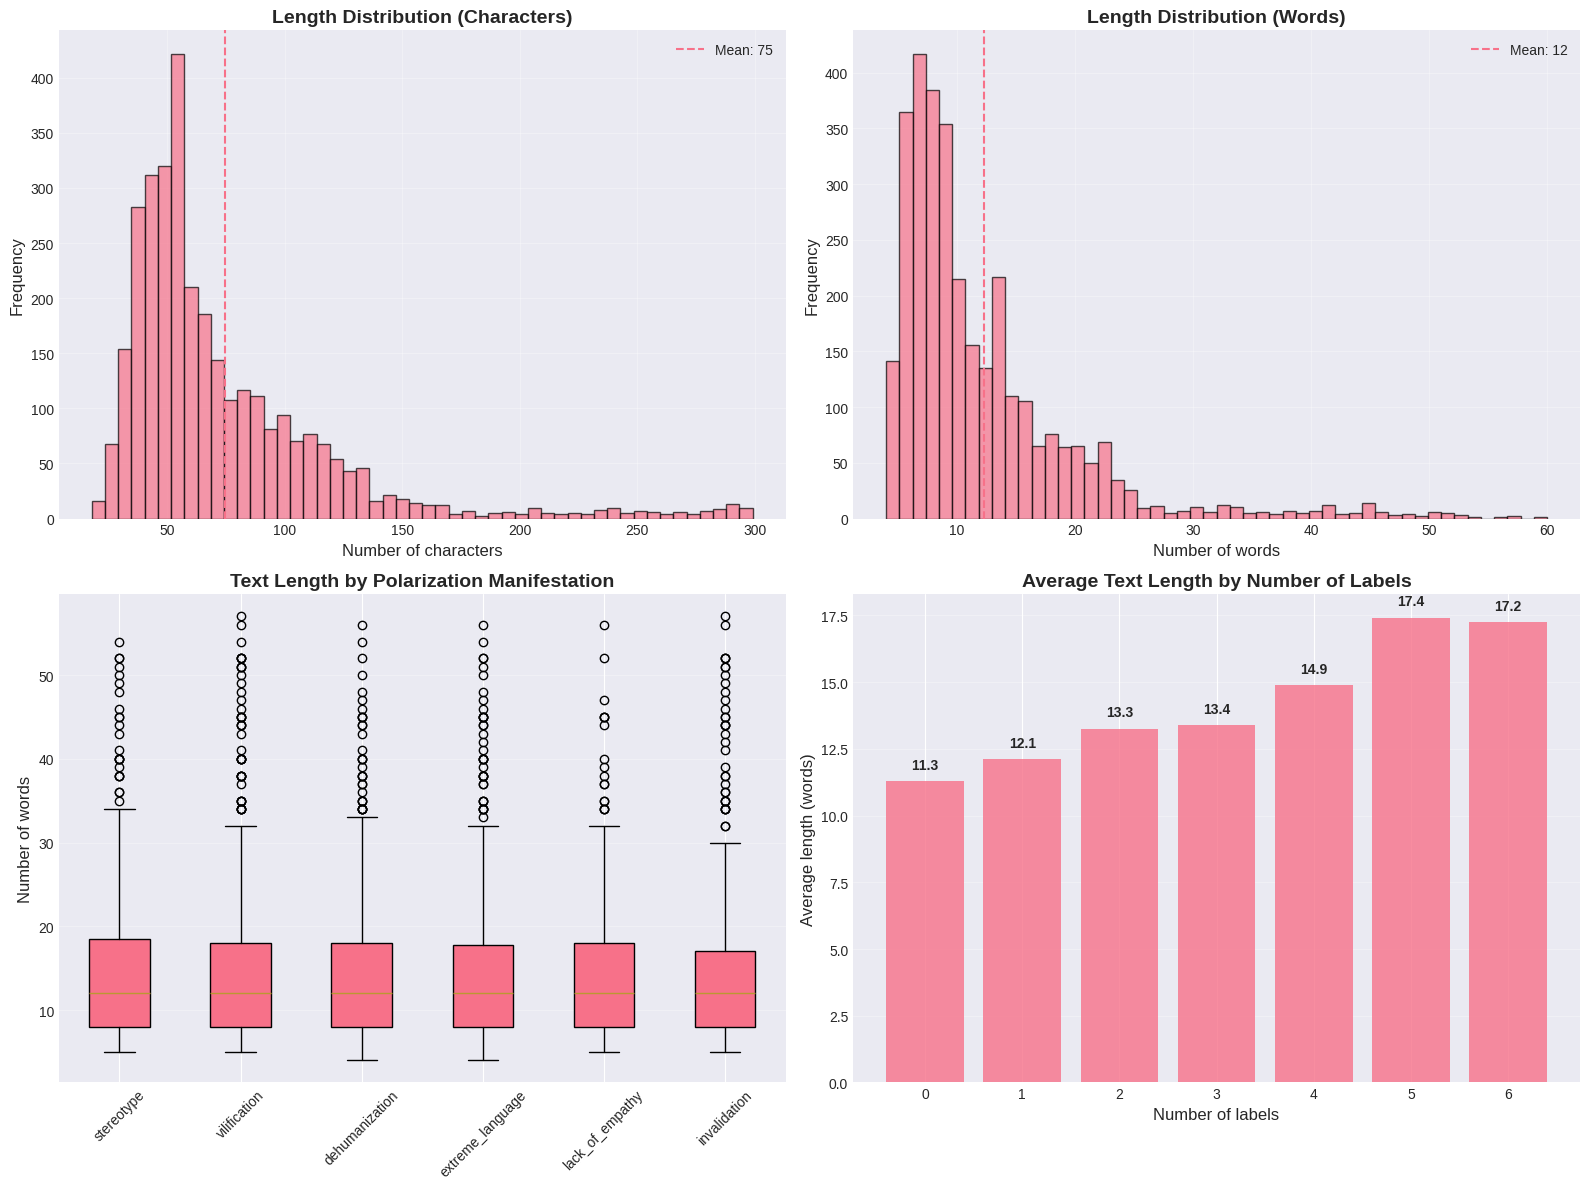

In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (15, 8)

print("\n" + "=" * 80)
print("3. TEXT LENGTH ANALYSIS")
print("=" * 80)

train_initial["text_length"] = train_initial["text"].str.len()
train_initial["word_count"] = train_initial["text"].str.split().str.len()
label_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

train_initial["num_labels"] = train_initial[label_cols].sum(axis=1)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].hist(
    train_initial["text_length"],
    bins=50,
    alpha=0.7,
    edgecolor="black"
)
axes[0, 0].set_xlabel("Number of characters", fontsize=12)
axes[0, 0].set_ylabel("Frequency", fontsize=12)
axes[0, 0].set_title(
    "Length Distribution (Characters)",
    fontsize=14,
    fontweight="bold"
)
axes[0, 0].axvline(
    train_initial["text_length"].mean(),
    linestyle="--",
    label=f"Mean: {train_initial['text_length'].mean():.0f}"
)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(
    train_initial["word_count"],
    bins=50,
    alpha=0.7,
    edgecolor="black"
)
axes[0, 1].set_xlabel("Number of words", fontsize=12)
axes[0, 1].set_ylabel("Frequency", fontsize=12)
axes[0, 1].set_title(
    "Length Distribution (Words)",
    fontsize=14,
    fontweight="bold"
)
axes[0, 1].axvline(
    train_initial["word_count"].mean(),
    linestyle="--",
    label=f"Mean: {train_initial['word_count'].mean():.0f}"
)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

data_for_box = [
    train_initial.loc[train_initial[col] == 1, "word_count"]
    for col in label_cols
]

axes[1, 0].boxplot(
    data_for_box,
    labels=label_cols,
    patch_artist=True
)
axes[1, 0].set_ylabel("Number of words", fontsize=12)
axes[1, 0].set_title(
    "Text Length by Polarization Manifestation",
    fontsize=14,
    fontweight="bold"
)
axes[1, 0].tick_params(axis="x", rotation=45)
axes[1, 0].grid(axis="y", alpha=0.3)

avg_length_by_labels = (
    train_initial
    .groupby("num_labels")["word_count"]
    .mean()
)

axes[1, 1].bar(
    avg_length_by_labels.index,
    avg_length_by_labels.values,
    alpha=0.8
)
axes[1, 1].set_xlabel("Number of labels", fontsize=12)
axes[1, 1].set_ylabel("Average length (words)", fontsize=12)
axes[1, 1].set_title(
    "Average Text Length by Number of Labels",
    fontsize=14,
    fontweight="bold"
)
axes[1, 1].grid(axis="y", alpha=0.3)

for i, v in zip(avg_length_by_labels.index, avg_length_by_labels.values):
    axes[1, 1].text(
        i,
        v + 0.02 * max(avg_length_by_labels.values),
        f"{v:.1f}",
        ha="center",
        va="bottom",
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


6. WORD CLOUDS GENERATION - BIGRAMS


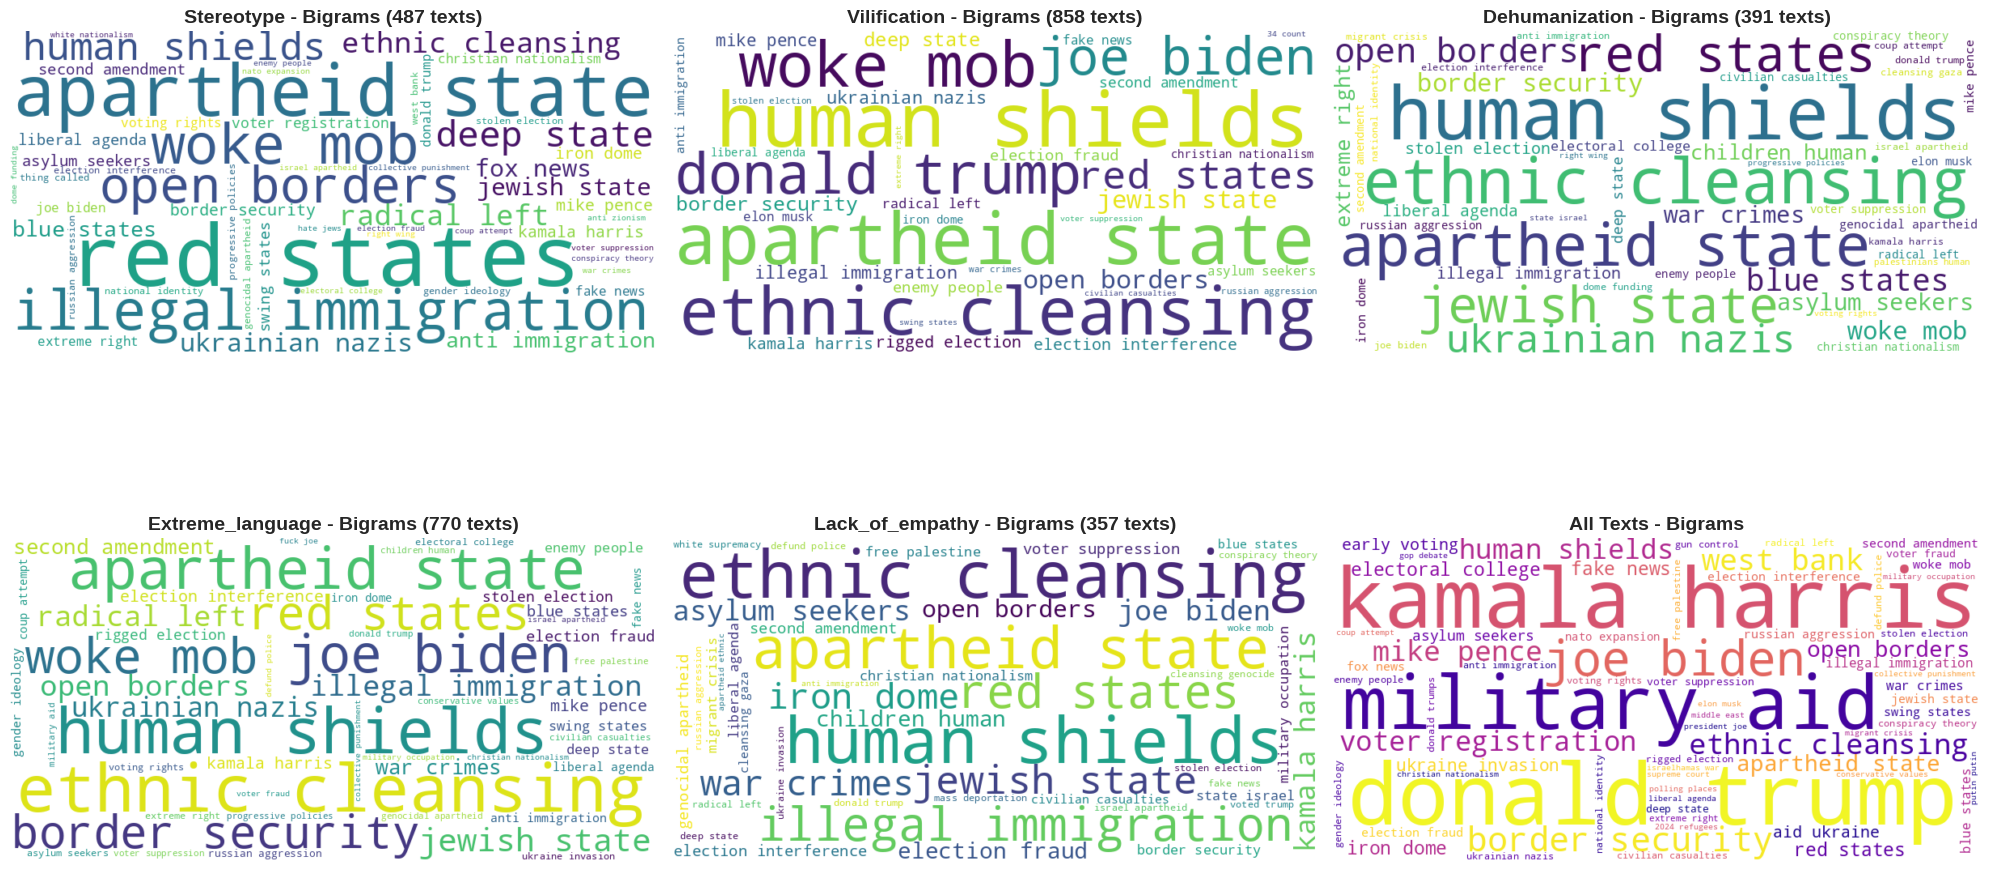

In [ ]:
print("\n" + "="*80)
print("6. WORD CLOUDS GENERATION - BIGRAMS")
print("="*80)

from wordcloud import STOPWORDS, WordCloud # Import WordCloud here
from sklearn.feature_extraction.text import CountVectorizer

custom_stopwords = set(STOPWORDS)
additional_stopwords = {
    'will', 'one', 'two', 'three', 'would', 'could', 'said', 'say', 'even', 'also',
    'get', 'got', 'getting', 'much', 'many', 'may', 'might', 'like', 'go', 'going',
    'make', 'made', 'take', 'know', 'think', 'see', 'want', 'come', 'way', 'time',
    'new', 'first', 'last', 'good', 'great', 'back', 'well', 'still', 'really',
    'us', 'im', 'dont', 'cant', 'wont', 'didnt', 'thats', 'youre', 'theyre', 'ive',
    'http', 'https', 'www', 'com', 'amp', 'rt', 'via', 'url', 'link'
}
custom_stopwords.update(additional_stopwords)

def generate_bigrams(texts):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=list(custom_stopwords),
                                  max_features=100, min_df=2)
    try:
        X = vectorizer.fit_transform(texts)
        bigrams = vectorizer.get_feature_names_out()
        frequencies = X.toarray().sum(axis=0)
        bigram_freq = {bigram: freq for bigram, freq in zip(bigrams, frequencies)}
        return bigram_freq
    except:
        return {}

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, label in enumerate(label_cols):
    texts_with_label = train_initial[train_initial[label] == 1]['text']

    if len(texts_with_label) > 0:
        bigram_freq = generate_bigrams(texts_with_label)

        if bigram_freq:
            wordcloud = WordCloud(
                width=800,
                height=400,
                background_color='white',
                max_words=100,
                colormap='viridis',
                relative_scaling=0.5,
                min_font_size=10
            ).generate_from_frequencies(bigram_freq)

            axes[idx].imshow(wordcloud, interpolation='bilinear')
            axes[idx].set_title(f'{label.capitalize()} - Bigrams ({len(texts_with_label)} texts)',
                               fontsize=14, fontweight='bold')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, 'Insufficient data',
                          ha='center', va='center', fontsize=16)
            axes[idx].set_title(label.capitalize(), fontsize=14, fontweight='bold')
            axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, 'No data',
                      ha='center', va='center', fontsize=16)
        axes[idx].set_title(label.capitalize(), fontsize=14, fontweight='bold')
        axes[idx].axis('off')

bigram_freq_all = generate_bigrams(train_initial['text'])
wordcloud_all = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    colormap='plasma',
    relative_scaling=0.5,
    min_font_size=10
).generate_from_frequencies(bigram_freq_all)

axes[-1].imshow(wordcloud_all, interpolation='bilinear')
axes[-1].set_title('All Texts - Bigrams', fontsize=14, fontweight='bold')
axes[-1].axis('off')

plt.tight_layout()
plt.show()

### 3.1.2 Function for polarization

In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

### 3.1.3 Data split

In [ ]:
from sklearn.model_selection import train_test_split


target_cols = [
   "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

X = train_initial["text"]          # ta colonne texte
y = train_initial[target_cols]     # les 5 labels

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


train = X_train.to_frame().join(y_train)
val = X_valid.to_frame().join(y_valid)


In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(train['text'].tolist(), train[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=6, problem_type="multi_label_classification") # use 6 labels

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=150,
    disable_tqdm=False
)

# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")

KeyboardInterrupt: 

#### optimmisation of the code

In [ ]:
import torch
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import f1_score
from torch.cuda.amp import autocast

training_args = TrainingArguments(
    output_dir="./",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    fp16=True,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=150,
    disable_tqdm=False,
    warmup_steps=100,
    weight_decay=0.01,
)

def compute_metrics_multilabel(p):
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    preds = (probs > 0.5).int().numpy()
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro', zero_division=0)}

# trainer = Trainer(...)
# trainer.train()
# trainer.evaluate()

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")

Macro F1 score on validation set for Subtask 3: 0.347118006090038


Fetching predictions on the validation set...



--- CONFUSION MATRIX PER CLASS (MULTI-LABEL) ---
Format: [[True Negatives, False Positives], [False Negatives, True Positives]]


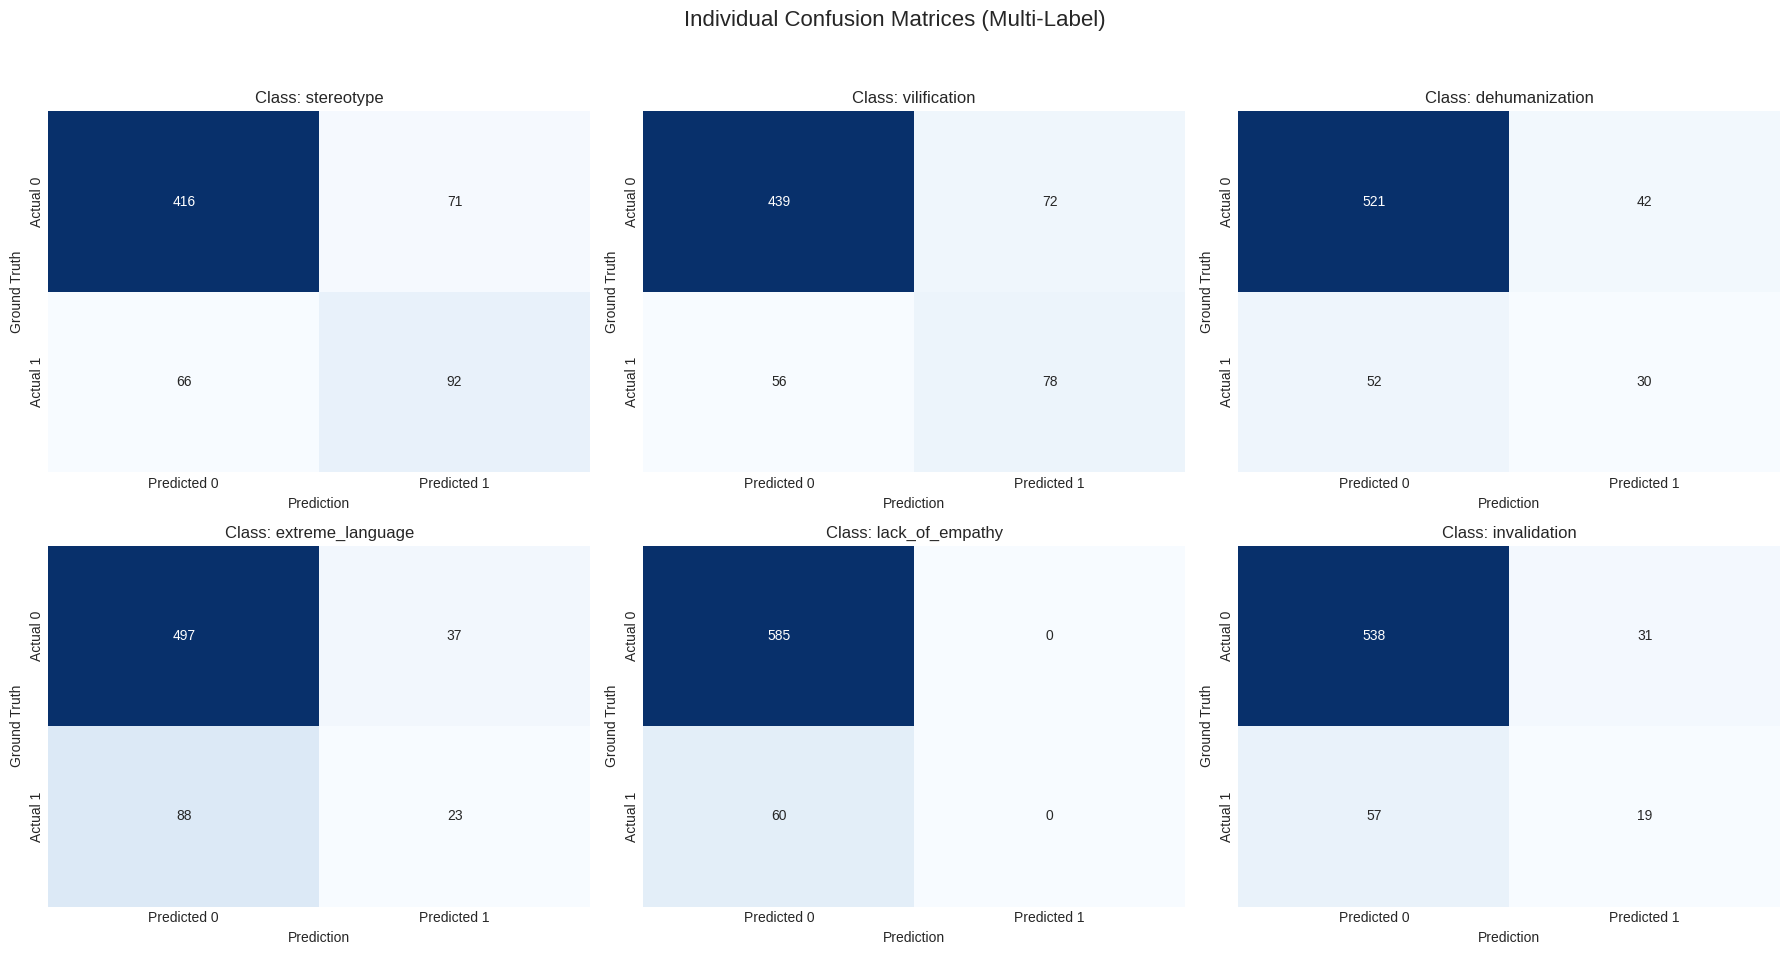


--- DETAILED CLASSIFICATION REPORT ---
                  precision    recall  f1-score   support

      stereotype       0.56      0.58      0.57       158
    vilification       0.52      0.58      0.55       134
  dehumanization       0.42      0.37      0.39        82
extreme_language       0.38      0.21      0.27       111
 lack_of_empathy       0.00      0.00      0.00        60
    invalidation       0.38      0.25      0.30        76

       micro avg       0.49      0.39      0.43       621
       macro avg       0.38      0.33      0.35       621
    weighted avg       0.43      0.39      0.40       621
     samples avg       0.12      0.13      0.12       621



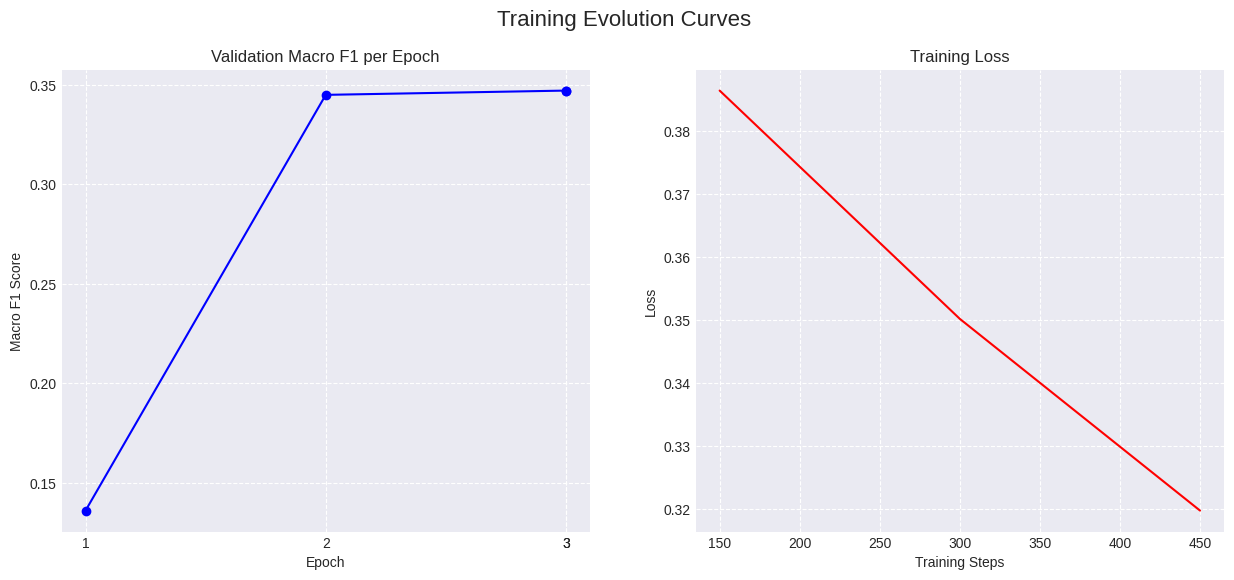

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import torch

print("Fetching predictions on the validation set...")
predictions_output = trainer.predict(val_dataset)

val_logits = predictions_output.predictions
val_labels = predictions_output.label_ids

val_probs = torch.sigmoid(torch.from_numpy(val_logits)).numpy()
val_preds = (val_probs > 0.5).astype(int)

# Corrected target_cols to match the 6 labels used in training
target_cols = ["stereotype", "vilification", "dehumanization", "extreme_language", "lack_of_empathy", "invalidation"]

cm_array = multilabel_confusion_matrix(val_labels, val_preds)

print("\n--- CONFUSION MATRIX PER CLASS (MULTI-LABEL) ---")
print("Format: [[True Negatives, False Positives], [False Negatives, True Positives]]")

# Adjust subplot layout if target_cols length changes
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) # Adjusted to 2 rows, 3 columns for 6 labels
axes = axes.flatten()
fig.suptitle('Individual Confusion Matrices (Multi-Label)', fontsize=16)

for i, label in enumerate(target_cols):
    cm = cm_array[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                ax=axes[i],
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    axes[i].set_title(f'Class: {label}')
    axes[i].set_xlabel('Prediction')
    axes[i].set_ylabel('Ground Truth')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- DETAILED CLASSIFICATION REPORT ---")
print(classification_report(val_labels, val_preds, target_names=target_cols, zero_division=0))

log_history = trainer.state.log_history

eval_logs = [log for log in log_history if 'eval_f1_macro' in log]
train_logs = [log for log in log_history if 'loss' in log]

epochs = [log['epoch'] for log in eval_logs]
f1_macro_val = [log['eval_f1_macro'] for log in eval_logs]

train_losses = [log['loss'] for log in train_logs]
train_steps = [log['step'] for log in train_logs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Training Evolution Curves', fontsize=16)

ax1.plot(epochs, f1_macro_val, marker='o', linestyle='-', color='b')
ax1.set_title('Validation Macro F1 per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Macro F1 Score')
ax1.grid(True, linestyle='--')
ax1.set_xticks(epochs)

ax2.plot(train_steps, train_losses, linestyle='-', color='r')
ax2.set_title('Training Loss')
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--')

plt.show()

In [ ]:
test = pd.read_csv('subtask3/dev/eng.csv')


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import (
    AutoTokenizer,
    Trainer,
    DataCollatorWithPadding,
)
from torch.utils.data import Dataset
from google.colab import drive

MAX_LENGTH = 384
target_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

try:
    if 'optimal_thresholds' not in locals():
        print("WARNING: The 'optimal_thresholds' vector was not found. Using default thresholds (0.5) for demonstration.")
        optimal_thresholds = np.array([0.5] * len(target_cols))
except NameError:
    optimal_thresholds = np.array([0.5] * len(target_cols))

test_data = pd.read_csv('subtask3/dev/eng.csv')

class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: encoding[key].squeeze() for key in encoding.keys()}

test_dataset = PredictionDataset(test_data['text'].tolist(), tokenizer)

print(f"\n--- Starting prediction on {len(test_data)} test samples ---")

try:
    prediction_output = trainer.predict(test_dataset)
except NameError:
    print("ERROR: The 'trainer' object is not accessible. Ensure you initialized the trainer before running this block.")
    exit()

test_logits = prediction_output.predictions

print("Converting Logits to binary labels by applying Optimal Thresholds...")

test_probabilities = 1 / (1 + np.exp(-test_logits))

optimal_thresholds_broadcasted = np.tile(
    optimal_thresholds,
    (test_probabilities.shape[0], 1)
)

final_predictions = (test_probabilities >= optimal_thresholds_broadcasted).astype(int)

submission_df = pd.DataFrame(
    final_predictions,
    columns=target_cols
)
submission_df.insert(0, 'id', test_data['id'])

for col in target_cols:
    submission_df[col] = submission_df[col].astype(int)

filename = 'pred_subtask3_eng.csv'
submission_df.to_csv(filename, index=False)

print("\n--- Submission File Preview (first 5 rows) ---")
print(submission_df.head())

print(f"Final submission file generated: {filename}")
print(f"Thresholds used: {optimal_thresholds.tolist()}")


--- Starting prediction on 160 test samples ---


Converting Logits to binary labels by applying Optimal Thresholds...

--- Submission File Preview (first 5 rows) ---
                                     id  stereotype  vilification  \
0  eng_f66ca14d60851371f9720aaf4ccd9b58           0             0   
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb           0             0   
2  eng_95770ff547ea5e48b0be00f385986483           0             0   
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf           0             0   
4  eng_07781aa88e61e7c0a996abd1e5ea3a20           0             0   

   dehumanization  extreme_language  lack_of_empathy  invalidation  
0               0                 0                0             0  
1               0                 0                0             0  
2               0                 0                0             0  
3               0                 0                0             0  
4               0                 0                0             0  
Final submission file generated: pred_subtask3_eng.csv

###  of optimisation make the prediction of each classe


In [ ]:
# ============================================================================
# CODE OVR MULTI-LABEL ROBUSTE (CPU/GPU SAFE) - CORRECTION FINAL
# ============================================================================

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Fixer la graine
set_seed(42)

# ============================================================================
# PARTIE 0: GESTION GPU/CPU ET NETTOYAGE
# ============================================================================

USE_GPU = torch.cuda.is_available()
print(f"Device utilisé: {'cuda' if USE_GPU else 'cpu'}")

def safe_gpu_cleanup():
    """Nettoie la mémoire GPU de manière sécurisée"""
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

# ============================================================================
# PARTIE 1: DATASET ET DATA COLLATOR
# ============================================================================

class PolarizationBinaryDataset(Dataset):
    """Dataset binaire pour OvR multi-label"""
    def __init__(self, texts, labels, tokenizer, max_length=384):
        self.texts = texts
        # Labels en float32 (requis pour la perte binaire)
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in encoding.items()}

        # Le label est de forme [1] et de type float (pour la BCEWithLogitsLoss)
        item['labels'] = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return item

class BinaryDataCollator(DataCollatorWithPadding):
    """Data Collator pour BCEWithLogitsLoss"""
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)

        # Les labels empilés ont la forme (batch_size, 1) et sont float
        batch['labels'] = torch.stack(labels).float()

        return batch

# ============================================================================
# PARTIE 2: FONCTIONS UTILITAIRES
# ============================================================================

def compute_metrics_binary(p):
    # Logits (N, 1) aplatis en (N,) pour le calcul
    probs = torch.sigmoid(torch.tensor(p.predictions)).numpy().flatten()
    preds = (probs >= 0.5).astype(int)

    # Labels (N, 1) aplatis en (N,)
    labels = p.label_ids.flatten()

    return {
        'f1_binary': f1_score(labels, preds, average='binary', zero_division=0),
        'accuracy': accuracy_score(labels, preds)
    }

def find_optimal_threshold_binary(y_true, logits):
    # Logits (N, 1) aplatis en (N,)
    y_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    best_f1, best_t = 0.0, 0.5
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

# ============================================================================
# PARTIE 3: INITIALISATION
# ============================================================================

MODEL_NAME = 'roberta-base'
MAX_LENGTH = 384

target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
binary_data_collator = BinaryDataCollator(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./ovr_training",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=USE_GPU,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_binary",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1,
    warmup_steps=100,
    weight_decay=0.01,
    # PARAMÈTRE 'problem_type' RETIRÉ
)

# ============================================================================
# PARTIE 4: ENTRAÎNEMENT ONE-VS-REST
# ============================================================================

ovr_results = {'models': {}, 'thresholds': {}, 'f1_scores': {}}

for idx, label in enumerate(target_cols, 1):
    print(f"\n{'='*70}\n[{idx}/{len(target_cols)}] CLASSE: {label.upper()}\n{'='*70}")

    safe_gpu_cleanup()

    # Assurez-vous que 'train' et 'val' DataFrames sont disponibles et chargés
    try:
        train_labels = train[label].astype(int).tolist()
        val_labels = val[label].astype(int).tolist()
    except NameError:
        print("ERREUR: 'train' ou 'val' DataFrame non trouvé. Veuillez les charger avant d'exécuter.")
        exit()

    train_dataset = PolarizationBinaryDataset(train['text'].tolist(), train_labels, tokenizer, MAX_LENGTH)
    val_dataset = PolarizationBinaryDataset(val['text'].tolist(), val_labels, tokenizer, MAX_LENGTH)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=1,
        # Configuration correcte de la perte binaire (BCEWithLogitsLoss)
        problem_type="multi_label_classification"
    )

    output_dir_label = f"./ovr_models/{label}"
    os.makedirs(output_dir_label, exist_ok=True)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary,
        data_collator=binary_data_collator
    )

    trainer.train()

    predictions_output = trainer.predict(val_dataset)
    best_threshold, best_f1 = find_optimal_threshold_binary(np.array(val_labels), predictions_output.predictions)

    ovr_results['models'][label] = output_dir_label
    ovr_results['thresholds'][label] = best_threshold
    ovr_results['f1_scores'][label] = best_f1

    trainer.save_model(output_dir_label)
    del model, trainer
    safe_gpu_cleanup()

    print(f"✓ Seuil optimal: {best_threshold:.3f}, F1-score: {best_f1:.4f}")

# ============================================================================
# PARTIE 5: ÉVALUATION FINALE
# ============================================================================


Device utilisé: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


[1/6] CLASSE: VILIFICATION


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Seuil optimal: 0.530, F1-score: 0.6192

[2/6] CLASSE: EXTREME_LANGUAGE


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Seuil optimal: 0.180, F1-score: 0.6006

[3/6] CLASSE: STEREOTYPE


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Seuil optimal: 0.320, F1-score: 0.4578

[4/6] CLASSE: INVALIDATION


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Seuil optimal: 0.120, F1-score: 0.5029

[5/6] CLASSE: LACK_OF_EMPATHY


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Seuil optimal: 0.110, F1-score: 0.2236

[6/6] CLASSE: DEHUMANIZATION


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Seuil optimal: 0.050, F1-score: 0.4286


ValueError: You have set `args.eval_strategy` to IntervalStrategy.EPOCH but you didn't pass an `eval_dataset` to `Trainer`. Either set `args.eval_strategy` to `no` or pass an `eval_dataset`. 

In [ ]:

all_val_preds = []
all_val_labels = val[target_cols].values

for label in target_cols:
    safe_gpu_cleanup()

    model_binary = AutoModelForSequenceClassification.from_pretrained(
        ovr_results['models'][label]
    )

    val_labels_current = val[label].astype(int).tolist()
    val_dataset_binary = PolarizationBinaryDataset(val['text'].tolist(), val_labels_current, tokenizer, MAX_LENGTH)

    trainer_binary = Trainer(
        model=model_binary,
        args=training_args,
        eval_dataset=val_dataset_binary, # Added eval_dataset
        data_collator=binary_data_collator
    )

    predictions_output = trainer_binary.predict(val_dataset_binary)
    logits = predictions_output.predictions

    probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    preds = (probs >= ovr_results['thresholds'][label]).astype(int)
    all_val_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

final_preds_ovr = np.stack(all_val_preds, axis=1)

f1_macro_final = f1_score(all_val_labels, final_preds_ovr, average='macro', zero_division=0)
f1_per_class = f1_score(all_val_labels, final_preds_ovr, average=None, zero_division=0)

print("\n" + "="*70)
print("RÉSULTATS FINAUX - STRATÉGIE ONE-VS-REST")
print("="*70)
print(f"\n🎯 F1 MACRO GLOBAL: {f1_macro_final:.4f}\n")
print("F1-Score par classe:")
print("─"*70)
for label, f1 in zip(target_cols, f1_per_class):
    threshold = ovr_results['thresholds'][label]
    print(f"  {label:20s}: {f1:.4f}  (seuil: {threshold:.3f})")

print("\n✓ ENTRAÎNEMENT OVR TERMINÉ AVEC SUCCÈS!")



RÉSULTATS FINAUX - STRATÉGIE ONE-VS-REST

🎯 F1 MACRO GLOBAL: 0.4721

F1-Score par classe:
──────────────────────────────────────────────────────────────────────
  vilification        : 0.6192  (seuil: 0.530)
  extreme_language    : 0.6006  (seuil: 0.180)
  stereotype          : 0.4578  (seuil: 0.320)
  invalidation        : 0.5029  (seuil: 0.120)
  lack_of_empathy     : 0.2236  (seuil: 0.110)
  dehumanization      : 0.4286  (seuil: 0.050)

✓ ENTRAÎNEMENT OVR TERMINÉ AVEC SUCCÈS!


##### prediction for the fert methode  ddoptimisation :dislberta

In [ ]:


import os
import torch
import numpy as np
import pandas as pd
from transformers import (
    AutoTokenizer,
    Trainer,
    DataCollatorWithPadding,
    TrainingArguments # Nécessaire pour initialiser Trainer
)
from torch.utils.data import Dataset
# from google.colab import drive # Décommenter si nécessaire

MAX_LENGTH = 384
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]

# --- 1. CHARGEMENT DES DONNÉES ET INITIALISATION ---

# Recharger le tokenizer et le DataCollator (si besoin, ils doivent venir de l'entraînement)
# Assumons que 'tokenizer' et 'binary_data_collator' sont définis depuis la phase d'entraînement.

# Le jeu de données de test/dev est chargé
test_data = pd.read_csv('subtask3/dev/eng.csv')

# Arguments de prediction (réutilisation des paramètres d'entraînement pertinents)
prediction_args = TrainingArguments(
    output_dir="./ovr_prediction",
    per_device_eval_batch_size=16,
    fp16=False, # Forçons FP16 à False pour être sûr sur CPU
    report_to="none",
    # Note: On utilise le mode "cpu" ici, donc fp16 sera ignoré, mais on le laisse sécurisé.
)

# Fonction de nettoyage GPU (si vous retrouvez un GPU)
def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

# Le Dataset de prédiction ne nécessite pas de labels
class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: encoding[key].squeeze(0) for key in encoding.keys()} # Squeeze(0) pour enlever la dim batch de 1

test_dataset = PredictionDataset(test_data['text'].tolist(), tokenizer)

print(f"\n--- Démarrage de la prédiction OvR sur {len(test_data)} échantillons ---")

all_test_preds = []

# --- 2. BOUCLE DE PRÉDICTION SUR LES SIX MODÈLES ---

for label in target_cols:
    safe_gpu_cleanup()

    # 2.1 Chargement du modèle
    model_path = ovr_results['models'][label]
    print(f"-> Prédiction pour la classe '{label}' (Modèle chargé: {model_path})")

    try:
        model_binary = AutoModelForSequenceClassification.from_pretrained(model_path)
    except Exception as e:
        print(f"ERREUR: Impossible de charger le modèle pour {label}. Assurez-vous que le chemin est correct. {e}")
        continue

    # 2.2 Création du Trainer
    # Use DataCollatorWithPadding for prediction as it does not expect labels in the dataset items
    trainer_binary = Trainer(
        model=model_binary,
        args=prediction_args,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer) # Utilisation du DataCollator standard pour la prédiction
    )

    # 2.3 Prédiction
    predictions_output = trainer_binary.predict(test_dataset)
    logits = predictions_output.predictions

    # 2.4 Calcul des probabilités et application du seuil
    test_probabilities = 1 / (1 + np.exp(-logits))

    threshold = ovr_results['thresholds'][label]

    # Prédictions binaires pour cette classe
    preds = (test_probabilities >= threshold).astype(int).flatten()
    all_test_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

# --- 3. ASSEMBLAGE ET SAUVEGARDE FINALE ---

final_predictions = np.stack(all_test_preds, axis=1)

submission_df = pd.DataFrame(
    final_predictions,
    columns=target_cols
)

# Ajouter la colonne 'id'
submission_df.insert(0, 'id', test_data['id'])

# S'assurer que les colonnes sont bien en entier (binaire)
for col in target_cols:
    submission_df[col] = submission_df[col].astype(int)

filename = 'pred_subtask3_eng_ovr.csv'
submission_df.to_csv(filename, index=False)

print("\n" + "="*70)
print("RÉSULTATS DE PRÉDICTION FINALE (OvR)")
print("="*70)
print("--- Submission File Preview (first 5 rows) ---")
print(submission_df.head())

print(f"\nFichier de soumission final généré: {filename}")
print("Seuils optimaux utilisés par classe:")
for label in target_cols:
    print(f"  {label:20s}: {ovr_results['thresholds'][label]:.3f}")




--- Démarrage de la prédiction OvR sur 160 échantillons ---
-> Prédiction pour la classe 'vilification' (Modèle chargé: ./ovr_models/vilification)


-> Prédiction pour la classe 'extreme_language' (Modèle chargé: ./ovr_models/extreme_language)


-> Prédiction pour la classe 'stereotype' (Modèle chargé: ./ovr_models/stereotype)


-> Prédiction pour la classe 'invalidation' (Modèle chargé: ./ovr_models/invalidation)


-> Prédiction pour la classe 'lack_of_empathy' (Modèle chargé: ./ovr_models/lack_of_empathy)


-> Prédiction pour la classe 'dehumanization' (Modèle chargé: ./ovr_models/dehumanization)



RÉSULTATS DE PRÉDICTION FINALE (OvR)
--- Submission File Preview (first 5 rows) ---
                                     id  vilification  extreme_language  \
0  eng_f66ca14d60851371f9720aaf4ccd9b58             0                 0   
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb             0                 0   
2  eng_95770ff547ea5e48b0be00f385986483             0                 0   
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf             0                 0   
4  eng_07781aa88e61e7c0a996abd1e5ea3a20             0                 0   

   stereotype  invalidation  lack_of_empathy  dehumanization  
0           0             0                1               0  
1           0             0                0               0  
2           0             0                0               0  
3           0             0                0               0  
4           0             0                0               0  

Fichier de soumission final généré: pred_subtask3_eng_ovr.csv
Seuils optimaux utilisé

#### sECONDE METHODE of optimisation roberta base

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

set_seed(42)

# --- CONFIGURATION ---
MODEL_NAME = 'roberta-base'
MAX_LENGTH = 384
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
# ---------------------

USE_GPU = torch.cuda.is_available()
print(f"Device used: {'cuda' if USE_GPU else 'cpu'}")

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class PolarizationBinaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=384):
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return item

class BinaryDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)
        batch['labels'] = torch.stack(labels).float()
        return batch

def compute_metrics_binary(p):
    probs = torch.sigmoid(torch.tensor(p.predictions)).numpy().flatten()
    preds = (probs >= 0.5).astype(int)
    labels = p.label_ids.flatten()
    return {
        'f1_binary': f1_score(labels, preds, average='binary', zero_division=0),
        'accuracy': accuracy_score(labels, preds)
    }

def find_optimal_threshold_binary(y_true, logits):
    y_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    best_f1, best_t = 0.0, 0.5
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
binary_data_collator = BinaryDataCollator(tokenizer=tokenizer)

# GPU VRAM OPTIMIZATION ARGUMENTS
training_args = TrainingArguments(
    output_dir="./ovr_training",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=True, # Half-precision to save VRAM
    gradient_accumulation_steps=2, # Accumulate gradients to save VRAM (Effective Batch Size = 8)
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_binary",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1,
    warmup_steps=100,
    weight_decay=0.01,
)

ovr_results = {'models': {}, 'thresholds': {}, 'f1_scores': {}}
class_weights = {}

# --- Custom Trainer to handle pos_weight in BCEWithLogitsLoss ---
class CustomMultiLabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # If pos_weight_tensor is set in model.config, use it for BCEWithLogitsLoss
        if model.config.problem_type == "multi_label_classification" and hasattr(model.config, 'pos_weight_list'):
            # Convert pos_weight_list back to tensor for loss computation
            pos_weight_tensor = torch.tensor(model.config.pos_weight_list, dtype=torch.float32).to(logits.device)
            loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1, self.model.config.num_labels).float())
        else:
            # Fallback to the default loss calculation by the base Trainer (BCEWithLogitsLoss without pos_weight for multi_label)
            loss_fct = torch.nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1, self.model.config.num_labels).float())

        return (loss, outputs) if return_outputs else loss

# --- 1. PRE-CALCULATE CLASS WEIGHTS FOR IMBALANCE ---

try:
    for label in target_cols:
        positive_count = train[label].sum()
        negative_count = len(train) - positive_count
        # Weight = Negative Count / Positive Count (standard practice for BCE loss)
        weight = negative_count / positive_count
        # Clamp weight to avoid extremely large values for very rare classes (optional)
        class_weights[label] = min(weight, 50.0)

    for label, weight in class_weights.items():
        print(f"  {label:20s}: {weight:.2f}")

except NameError:
    print("ERROR: 'train' DataFrame not found for calculating weights. Exiting.")
    exit()

# --- 2. ONE-VS-REST TRAINING LOOP ---

for idx, label in enumerate(target_cols, 1):
    print(f"\nTraining Model [{idx}/{len(target_cols)}] CLASS: {label.upper()}")

    safe_gpu_cleanup()

    train_labels = train[label].astype(int).tolist()
    val_labels = val[label].astype(int).tolist()

    train_dataset = PolarizationBinaryDataset(train['text'].tolist(), train_labels, tokenizer, MAX_LENGTH)
    val_dataset = PolarizationBinaryDataset(val['text'].tolist(), val_labels, tokenizer, MAX_LENGTH)

    # Convert the calculated weight to a tensor
    pos_weight_tensor = torch.tensor([class_weights[label]], dtype=torch.float32)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=1,
        problem_type="multi_label_classification",
    )
    # Store pos_weight_list in model.config (JSON serializable) so CustomMultiLabelTrainer can access it
    model.config.pos_weight_list = pos_weight_tensor.tolist()

    output_dir_label = f"./ovr_models/{label}"
    os.makedirs(output_dir_label, exist_ok=True)

    trainer = CustomMultiLabelTrainer( # Use CustomMultiLabelTrainer
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary,
        data_collator=binary_data_collator
    )

    trainer.train()

    predictions_output = trainer.predict(val_dataset)
    best_threshold, best_f1 = find_optimal_threshold_binary(np.array(val_labels), predictions_output.predictions)

    ovr_results['models'][label] = output_dir_label
    ovr_results['thresholds'][label] = best_threshold
    ovr_results['f1_scores'][label] = best_f1

    trainer.save_model(output_dir_label)
    del model, trainer
    safe_gpu_cleanup()

    print(f"✓ Optimal Threshold: {best_threshold:.3f}, F1-score: {best_f1:.4f}")

Device used: cuda
  vilification        : 2.68
  extreme_language    : 3.05
  stereotype          : 5.36
  invalidation        : 4.43
  lack_of_empathy     : 7.68
  dehumanization      : 7.18

Training Model [1/6] CLASS: VILIFICATION


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.680, F1-score: 0.6203

Training Model [2/6] CLASS: EXTREME_LANGUAGE


✓ Optimal Threshold: 0.490, F1-score: 0.5852

Training Model [3/6] CLASS: STEREOTYPE


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.470, F1-score: 0.4712

Training Model [4/6] CLASS: INVALIDATION


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.480, F1-score: 0.4812

Training Model [5/6] CLASS: LACK_OF_EMPATHY


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.010, F1-score: 0.1702

Training Model [6/6] CLASS: DEHUMANIZATION


✓ Optimal Threshold: 0.010, F1-score: 0.2108


In [ ]:
# --- 3. FINAL EVALUATION ---

all_val_preds = []
all_val_labels = val[target_cols].values

for label in target_cols:
    safe_gpu_cleanup()

    model_binary = AutoModelForSequenceClassification.from_pretrained(
        ovr_results['models'][label]
    )

    val_labels_current = val[label].astype(int).tolist()
    val_dataset_binary = PolarizationBinaryDataset(val['text'].tolist(), val_labels_current, tokenizer, MAX_LENGTH)

    trainer_binary = Trainer(
        model=model_binary,
        args=training_args,
        eval_dataset=val_dataset_binary,
        data_collator=binary_data_collator
    )

    predictions_output = trainer_binary.predict(val_dataset_binary)
    logits = predictions_output.predictions

    probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    preds = (probs >= ovr_results['thresholds'][label]).astype(int)
    all_val_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

final_preds_ovr = np.stack(all_val_preds, axis=1)

f1_macro_final = f1_score(all_val_labels, final_preds_ovr, average='macro', zero_division=0)
f1_per_class = f1_score(all_val_labels, final_preds_ovr, average=None, zero_division=0)

print("\nFINAL RESULTS - ONE-VS-REST STRATEGY (with Class Weighting)")
print("======================================================================")
print(f"\n🎯 GLOBAL MACRO F1: {f1_macro_final:.4f}\n")
print("F1-Score per Class:")
print("──────────────────────────────────────────────────────────────────────")
for label, f1 in zip(target_cols, f1_per_class):
    threshold = ovr_results['thresholds'][label]
    print(f"  {label:20s}: {f1:.4f}  (threshold: {threshold:.3f})")

print("\n✓ OVR TRAINING COMPLETED SUCCESSFULLY!")


FINAL RESULTS - ONE-VS-REST STRATEGY (with Class Weighting)

🎯 GLOBAL MACRO F1: 0.4231

F1-Score per Class:
──────────────────────────────────────────────────────────────────────
  vilification        : 0.6203  (threshold: 0.680)
  extreme_language    : 0.5852  (threshold: 0.490)
  stereotype          : 0.4712  (threshold: 0.470)
  invalidation        : 0.4812  (threshold: 0.480)
  lack_of_empathy     : 0.1702  (threshold: 0.010)
  dehumanization      : 0.2108  (threshold: 0.010)

✓ OVR TRAINING COMPLETED SUCCESSFULLY!


#### Data augementation

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

set_seed(42)

# --- CONFIGURATION ---
MODEL_NAME = 'roberta-base'
MAX_LENGTH = 384 # Reverted to 384 for better VRAM stability
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
MAX_OVERSAMPLE_RATIO = 5 # Maximum ratio of Negative:Positive examples to tolerate.
# ---------------------

USE_GPU = torch.cuda.is_available()
print(f"Device used: {'cuda' if USE_GPU else 'cpu'}")

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class PolarizationBinaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=384):
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return item

class BinaryDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)
        batch['labels'] = torch.stack(labels).float()
        return batch

def compute_metrics_binary(p):
    probs = torch.sigmoid(torch.tensor(p.predictions)).numpy().flatten()
    preds = (probs >= 0.5).astype(int)
    labels = p.label_ids.flatten()
    return {
        'f1_binary': f1_score(labels, preds, average='binary', zero_division=0),
        'accuracy': accuracy_score(labels, preds)
    }

def find_optimal_threshold_binary(y_true, logits):
    y_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    best_f1, best_t = 0.0, 0.5
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
binary_data_collator = BinaryDataCollator(tokenizer=tokenizer)

# GPU VRAM OPTIMIZATION ARGUMENTS (Stable configuration)
training_args = TrainingArguments(
    output_dir="./ovr_training",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=True, # Half-precision to save VRAM
    gradient_accumulation_steps=2, # Accumulate gradients (Effective Batch Size = 8)
    learning_rate=1e-5, # Lower learning rate for more stable RoBERTa training
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_binary",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1,
    warmup_steps=100,
    weight_decay=0.01,
)

ovr_results = {'models': {}, 'thresholds': {}, 'f1_scores': {}}

# --- 1. DATA AUGMENTATION (OVERSAMPLING) & ONE-VS-REST TRAINING LOOP ---

for idx, label in enumerate(target_cols, 1):
    print(f"\nTraining Model [{idx}/{len(target_cols)}] CLASS: {label.upper()}")

    safe_gpu_cleanup()

    try:
        # Assuming 'train' and 'val' DataFrames are available
        train_labels = train[label].astype(int)
        val_labels = val[label].astype(int).tolist()
    except NameError:
        print("ERROR: 'train' or 'val' DataFrame not found. Please load them before execution.")
        exit()

    # --- DATA AUGMENTATION LOGIC (OVERSAMPLING) ---
    train_df_current = train.copy()

    positive_indices = train_df_current[train_labels == 1].index
    negative_indices = train_df_current[train_labels == 0].index

    num_positives = len(positive_indices)
    num_negatives = len(negative_indices)

    # Calculate desired repetitions based on MAX_OVERSAMPLE_RATIO
    if num_positives > 0 and num_negatives / num_positives > MAX_OVERSAMPLE_RATIO:
        # Calculate how many times to repeat the positive samples
        reps = int(np.ceil(num_negatives / num_positives / MAX_OVERSAMPLE_RATIO)) - 1

        # Select positive samples for repetition
        positive_samples_to_duplicate = train_df_current.loc[positive_indices].copy()

        # Duplicate and concatenate to the training data
        oversampled_positives = pd.concat([positive_samples_to_duplicate] * reps, ignore_index=True)
        train_df_oversampled = pd.concat([train_df_current, oversampled_positives], ignore_index=True)

        print(f"  Oversampling applied. New N_positives: {num_positives * (reps + 1)}, New N_negatives: {num_negatives}")
    else:
        train_df_oversampled = train_df_current.copy()
        print("  Oversampling skipped (Ratio already acceptable or no positives).")

    # --- END DATA AUGMENTATION LOGIC ---

    # Re-extract texts and labels from the potentially oversampled DataFrame
    train_texts = train_df_oversampled['text'].tolist()
    train_labels_oversampled = train_df_oversampled[label].astype(int).tolist()


    train_dataset = PolarizationBinaryDataset(train_texts, train_labels_oversampled, tokenizer, MAX_LENGTH)
    val_dataset = PolarizationBinaryDataset(val['text'].tolist(), val_labels, tokenizer, MAX_LENGTH)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=1,
        problem_type="multi_label_classification",
        # NO pos_weight HERE
    )

    output_dir_label = f"./ovr_models/{label}"
    os.makedirs(output_dir_label, exist_ok=True)

    # Use the base Trainer (CustomMultiLabelTrainer not needed without pos_weight)
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary,
        data_collator=binary_data_collator
    )

    trainer.train()

    predictions_output = trainer.predict(val_dataset)
    best_threshold, best_f1 = find_optimal_threshold_binary(np.array(val_labels), predictions_output.predictions)

    ovr_results['models'][label] = output_dir_label
    ovr_results['thresholds'][label] = best_threshold
    ovr_results['f1_scores'][label] = best_f1

    trainer.save_model(output_dir_label)
    del model, trainer
    safe_gpu_cleanup()

    print(f"✓ Optimal Threshold: {best_threshold:.3f}, F1-score: {best_f1:.4f}")



Device used: cuda

Training Model [1/6] CLASS: VILIFICATION
  Oversampling skipped (Ratio already acceptable or no positives).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.280, F1-score: 0.6340

Training Model [2/6] CLASS: EXTREME_LANGUAGE
  Oversampling skipped (Ratio already acceptable or no positives).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.200, F1-score: 0.5951

Training Model [3/6] CLASS: STEREOTYPE
  Oversampling applied. New N_positives: 810, New N_negatives: 2172


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.550, F1-score: 0.4663

Training Model [4/6] CLASS: INVALIDATION
  Oversampling skipped (Ratio already acceptable or no positives).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.230, F1-score: 0.5172

Training Model [5/6] CLASS: LACK_OF_EMPATHY
  Oversampling applied. New N_positives: 594, New N_negatives: 2280


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.130, F1-score: 0.3314

Training Model [6/6] CLASS: DEHUMANIZATION
  Oversampling applied. New N_positives: 630, New N_negatives: 2262


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.360, F1-score: 0.4352


In [ ]:
# --- 2. FINAL EVALUATION ---

all_val_preds = []
all_val_labels = val[target_cols].values

for label in target_cols:
    safe_gpu_cleanup()

    model_binary = AutoModelForSequenceClassification.from_pretrained(
        ovr_results['models'][label]
    )

    val_labels_current = val[label].astype(int).tolist()
    val_dataset_binary = PolarizationBinaryDataset(val['text'].tolist(), val_labels_current, tokenizer, MAX_LENGTH)

    trainer_binary = Trainer(
        model=model_binary,
        args=training_args,
        eval_dataset=val_dataset_binary,
        data_collator=binary_data_collator
    )

    predictions_output = trainer_binary.predict(val_dataset_binary)
    logits = predictions_output.predictions

    probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    preds = (probs >= ovr_results['thresholds'][label]).astype(int)
    all_val_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

final_preds_ovr = np.stack(all_val_preds, axis=1)

f1_macro_final = f1_score(all_val_labels, final_preds_ovr, average='macro', zero_division=0)
f1_per_class = f1_score(all_val_labels, final_preds_ovr, average=None, zero_division=0)

print("\nFINAL RESULTS - ONE-VS-REST STRATEGY (with Simple Oversampling)")
print("======================================================================")
print(f"\n🎯 GLOBAL MACRO F1: {f1_macro_final:.4f}\n")
print("F1-Score per Class:")
print("──────────────────────────────────────────────────────────────────────")
for label, f1 in zip(target_cols, f1_per_class):
    threshold = ovr_results['thresholds'][label]
    print(f"  {label:20s}: {f1:.4f}  (threshold: {threshold:.3f})")

print("\n✓ OVR TRAINING COMPLETED SUCCESSFULLY!")


FINAL RESULTS - ONE-VS-REST STRATEGY (with Simple Oversampling)

🎯 GLOBAL MACRO F1: 0.4965

F1-Score per Class:
──────────────────────────────────────────────────────────────────────
  vilification        : 0.6340  (threshold: 0.280)
  extreme_language    : 0.5951  (threshold: 0.200)
  stereotype          : 0.4663  (threshold: 0.550)
  invalidation        : 0.5172  (threshold: 0.230)
  lack_of_empathy     : 0.3314  (threshold: 0.130)
  dehumanization      : 0.4352  (threshold: 0.360)

✓ OVR TRAINING COMPLETED SUCCESSFULLY!


##### Prediction of model roberta base +data saqmpleement

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    DataCollatorWithPadding,
    TrainingArguments
)
from torch.utils.data import Dataset

MAX_LENGTH = 384
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]

test_data = pd.read_csv('subtask3/dev/eng.csv')

USE_GPU = torch.cuda.is_available()

prediction_args = TrainingArguments(
    output_dir="./ovr_prediction",
    per_device_eval_batch_size=16,
    fp16=USE_GPU,
    report_to="none",
)

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: encoding[key].squeeze(0) for key in encoding.keys()}

test_dataset = PredictionDataset(test_data['text'].tolist(), tokenizer)

print(f"\n--- Starting OvR prediction on {len(test_data)} samples ---")

all_test_preds = []

for label in target_cols:
    safe_gpu_cleanup()

    try:
        model_path = ovr_results['models'][label]
    except NameError:
        print(f"ERROR: 'ovr_results' dictionary is not defined. Models could not be loaded.")
        exit()

    print(f"-> Predicting for class '{label}' (Model loaded from: {model_path})")

    try:
        model_binary = AutoModelForSequenceClassification.from_pretrained(model_path)
    except Exception as e:
        print(f"ERROR: Unable to load model for {label}. Ensure the path is correct. {e}")
        continue

    trainer_binary = Trainer(
        model=model_binary,
        args=prediction_args,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
    )

    predictions_output = trainer_binary.predict(test_dataset)
    logits = predictions_output.predictions

    test_probabilities = 1 / (1 + np.exp(-logits))

    threshold = ovr_results['thresholds'][label]

    preds = (test_probabilities >= threshold).astype(int).flatten()
    all_test_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

final_predictions = np.stack(all_test_preds, axis=1)

submission_df = pd.DataFrame(
    final_predictions,
    columns=target_cols
)

submission_df.insert(0, 'id', test_data['id'])

for col in target_cols:
    submission_df[col] = submission_df[col].astype(int)

filename = 'pred_subtask3_eng_ovr2.csv'
submission_df.to_csv(filename, index=False)

print("\n" + "="*70)
print("FINAL PREDICTION RESULTS (OvR)")
print("="*70)
print("--- Submission File Preview (first 5 rows) ---")
print(submission_df.head())

print(f"\nFinal submission file generated: {filename}")
print("Optimal thresholds used per class:")
for label in target_cols:
    print(f"  {label:20s}: {ovr_results['thresholds'][label]:.3f}")


--- Starting OvR prediction on 160 samples ---
-> Predicting for class 'vilification' (Model loaded from: ./ovr_models/vilification)


-> Predicting for class 'extreme_language' (Model loaded from: ./ovr_models/extreme_language)


-> Predicting for class 'stereotype' (Model loaded from: ./ovr_models/stereotype)


-> Predicting for class 'invalidation' (Model loaded from: ./ovr_models/invalidation)


-> Predicting for class 'lack_of_empathy' (Model loaded from: ./ovr_models/lack_of_empathy)


-> Predicting for class 'dehumanization' (Model loaded from: ./ovr_models/dehumanization)



FINAL PREDICTION RESULTS (OvR)
--- Submission File Preview (first 5 rows) ---
                                     id  vilification  extreme_language  \
0  eng_f66ca14d60851371f9720aaf4ccd9b58             0                 0   
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb             0                 0   
2  eng_95770ff547ea5e48b0be00f385986483             0                 0   
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf             0                 0   
4  eng_07781aa88e61e7c0a996abd1e5ea3a20             0                 0   

   stereotype  invalidation  lack_of_empathy  dehumanization  
0           0             0                0               0  
1           0             0                0               0  
2           0             0                0               0  
3           0             0                0               0  
4           0             0                0               0  

Final submission file generated: pred_subtask3_eng_ovr2.csv
Optimal thresholds used per cla

#### 3 EME Methode :Data augmentation + max lengths 512

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

set_seed(42)

MODEL_NAME = 'roberta-base'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
MAX_OVERSAMPLE_RATIO = 5

USE_GPU = torch.cuda.is_available()
print(f"Device used: {'cuda' if USE_GPU else 'cpu'}")

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class PolarizationBinaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return item

class BinaryDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)
        batch['labels'] = torch.stack(labels).float()
        return batch

def compute_metrics_binary(p):
    probs = torch.sigmoid(torch.tensor(p.predictions)).numpy().flatten()
    preds = (probs >= 0.5).astype(int)
    labels = p.label_ids.flatten()
    return {
        'f1_binary': f1_score(labels, preds, average='binary', zero_division=0),
        'accuracy': accuracy_score(labels, preds)
    }

def find_optimal_threshold_binary(y_true, logits):
    y_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    best_f1, best_t = 0.0, 0.5
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
binary_data_collator = BinaryDataCollator(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./ovr_training",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=True,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_binary",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1,
    warmup_steps=100,
    weight_decay=0.01,
)

ovr_results = {'models': {}, 'thresholds': {}, 'f1_scores': {}}

for idx, label in enumerate(target_cols, 1):
    print(f"\nTraining Model [{idx}/{len(target_cols)}] CLASS: {label.upper()}")

    safe_gpu_cleanup()

    try:
        train_labels = train[label].astype(int)
        val_labels = val[label].astype(int).tolist()
    except NameError:
        print("ERROR: 'train' or 'val' DataFrame not found. Please load them before execution.")
        exit()

    train_df_current = train.copy()

    positive_indices = train_df_current[train_labels == 1].index
    negative_indices = train_df_current[train_labels == 0].index

    num_positives = len(positive_indices)
    num_negatives = len(negative_indices)

    if num_positives > 0 and num_negatives / num_positives > MAX_OVERSAMPLE_RATIO:
        reps = int(np.ceil(num_negatives / num_positives / MAX_OVERSAMPLE_RATIO)) - 1
        positive_samples_to_duplicate = train_df_current.loc[positive_indices].copy()
        oversampled_positives = pd.concat([positive_samples_to_duplicate] * reps, ignore_index=True)
        train_df_oversampled = pd.concat([train_df_current, oversampled_positives], ignore_index=True)

        print(f"  Oversampling applied. New N_positives: {num_positives * (reps + 1)}, New N_negatives: {num_negatives}")
    else:
        train_df_oversampled = train_df_current.copy()
        print("  Oversampling skipped (Ratio already acceptable or no positives).")

    train_texts = train_df_oversampled['text'].tolist()
    train_labels_oversampled = train_df_oversampled[label].astype(int).tolist()


    train_dataset = PolarizationBinaryDataset(train_texts, train_labels_oversampled, tokenizer)
    val_dataset = PolarizationBinaryDataset(val['text'].tolist(), val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=1,
        problem_type="multi_label_classification",
    )

    output_dir_label = f"./ovr_models/{label}"
    os.makedirs(output_dir_label, exist_ok=True)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary,
        data_collator=binary_data_collator
    )

    trainer.train()

    predictions_output = trainer.predict(val_dataset)
    best_threshold, best_f1 = find_optimal_threshold_binary(np.array(val_labels), predictions_output.predictions)

    ovr_results['models'][label] = output_dir_label
    ovr_results['thresholds'][label] = best_threshold
    ovr_results['f1_scores'][label] = best_f1

    trainer.save_model(output_dir_label)
    del model, trainer
    safe_gpu_cleanup()

    print(f"✓ Optimal Threshold: {best_threshold:.3f}, F1-score: {best_f1:.4f}")

Device used: cuda

Training Model [1/6] CLASS: VILIFICATION
  Oversampling skipped (Ratio already acceptable or no positives).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.290, F1-score: 0.6649

Training Model [2/6] CLASS: EXTREME_LANGUAGE
  Oversampling skipped (Ratio already acceptable or no positives).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.230, F1-score: 0.5771

Training Model [3/6] CLASS: STEREOTYPE
  Oversampling applied. New N_positives: 810, New N_negatives: 2172


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.890, F1-score: 0.4693

Training Model [4/6] CLASS: INVALIDATION
  Oversampling skipped (Ratio already acceptable or no positives).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.190, F1-score: 0.5256

Training Model [5/6] CLASS: LACK_OF_EMPATHY
  Oversampling applied. New N_positives: 594, New N_negatives: 2280


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.150, F1-score: 0.3537

Training Model [6/6] CLASS: DEHUMANIZATION
  Oversampling applied. New N_positives: 630, New N_negatives: 2262


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.090, F1-score: 0.4502


In [ ]:
# --- 2. FINAL EVALUATION ---
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score

print("\n--- Starting Final Evaluation on Validation Set (MAX_LENGTH=512) ---")

all_val_preds = []
try:
    # Assumes 'val' DataFrame is loaded and 'target_cols' is defined
    all_val_labels = val[target_cols].values
except NameError:
    print("ERROR: 'val' DataFrame not found for final evaluation. Please load it.")
    exit()

# Evaluation arguments (optimized for evaluation speed)
eval_args = TrainingArguments(
    output_dir="./ovr_eval",
    per_device_eval_batch_size=16, # Larger batch size for evaluation
    report_to="none",
)


for label in target_cols:
    safe_gpu_cleanup()

    print(f"-> Evaluating model for class: {label}")

    model_binary = AutoModelForSequenceClassification.from_pretrained(
        ovr_results['models'][label]
    )

    val_labels_current = val[label].astype(int).tolist()
    # Uses MAX_LENGTH=512 set globally
    val_dataset_binary = PolarizationBinaryDataset(val['text'].tolist(), val_labels_current, tokenizer, MAX_LENGTH)

    trainer_binary = Trainer(
        model=model_binary,
        args=eval_args,
        eval_dataset=val_dataset_binary,
        data_collator=binary_data_collator
    )

    predictions_output = trainer_binary.predict(val_dataset_binary)
    logits = predictions_output.predictions

    # Application des seuils optimaux trouvés à l'entraînement
    probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    preds = (probs >= ovr_results['thresholds'][label]).astype(int)
    all_val_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

final_preds_ovr = np.stack(all_val_preds, axis=1)

f1_macro_final = f1_score(all_val_labels, final_preds_ovr, average='macro', zero_division=0)
f1_per_class = f1_score(all_val_labels, final_preds_ovr, average=None, zero_division=0)

print("\nFINAL RESULTS - ONE-VS-REST STRATEGY (Oversampling + MAX_LENGTH=512)")
print("======================================================================")
print(f"\n🎯 GLOBAL MACRO F1: {f1_macro_final:.4f}\n")
print("F1-Score per Class:")
print("──────────────────────────────────────────────────────────────────────")
for label, f1 in zip(target_cols, f1_per_class):
    threshold = ovr_results['thresholds'][label]
    print(f"  {label:20s}: {f1:.4f}  (threshold: {threshold:.3f})")

print("\n✓ OVR EVALUATION COMPLETED SUCCESSFULLY!")


--- Starting Final Evaluation on Validation Set (MAX_LENGTH=512) ---
-> Evaluating model for class: vilification


-> Evaluating model for class: extreme_language


-> Evaluating model for class: stereotype


-> Evaluating model for class: invalidation


-> Evaluating model for class: lack_of_empathy


-> Evaluating model for class: dehumanization



FINAL RESULTS - ONE-VS-REST STRATEGY (Oversampling + MAX_LENGTH=512)

🎯 GLOBAL MACRO F1: 0.5068

F1-Score per Class:
──────────────────────────────────────────────────────────────────────
  vilification        : 0.6649  (threshold: 0.290)
  extreme_language    : 0.5771  (threshold: 0.230)
  stereotype          : 0.4693  (threshold: 0.890)
  invalidation        : 0.5256  (threshold: 0.190)
  lack_of_empathy     : 0.3537  (threshold: 0.150)
  dehumanization      : 0.4502  (threshold: 0.090)

✓ OVR EVALUATION COMPLETED SUCCESSFULLY!


##### prediction

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    DataCollatorWithPadding,
    TrainingArguments
)
from torch.utils.data import Dataset

MODEL_NAME = 'roberta-base'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]

try:
    test_data = pd.read_csv('subtask3/dev/eng.csv')
except FileNotFoundError:
    print("ERROR: Test data file ('subtask3/dev/eng.csv') not found.")
    exit()

USE_GPU = torch.cuda.is_available()
print(f"Device used for prediction: {'cuda' if USE_GPU else 'cpu'}")

prediction_args = TrainingArguments(
    output_dir="./ovr_prediction",
    per_device_eval_batch_size=16,
    fp16=USE_GPU,
    report_to="none",
)

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: encoding[key].squeeze(0) for key in encoding.keys()}

try:
    # Assumes 'tokenizer' is defined and loaded from the training script
    test_dataset = PredictionDataset(test_data['text'].tolist(), tokenizer)
except NameError:
    print("ERROR: 'tokenizer' is not defined. Please load it (e.g., AutoTokenizer.from_pretrained('roberta-base')).")
    exit()


print(f"\n--- Starting OvR prediction on {len(test_data)} samples ---")

all_test_preds = []

for label in target_cols:
    safe_gpu_cleanup()

    try:
        # Assumes 'ovr_results' is defined and contains model paths and thresholds
        model_path = ovr_results['models'][label]
        threshold = ovr_results['thresholds'][label]
    except (NameError, KeyError):
        print(f"ERROR: The 'ovr_results' dictionary (model path or threshold for {label}) is not defined or incomplete.")
        exit()

    print(f"-> Predicting for class '{label}' (Threshold: {threshold:.3f})")

    try:
        model_binary = AutoModelForSequenceClassification.from_pretrained(model_path)
    except Exception as e:
        print(f"ERROR: Unable to load model from {model_path}. {e}")
        continue

    trainer_binary = Trainer(
        model=model_binary,
        args=prediction_args,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
    )

    predictions_output = trainer_binary.predict(test_dataset)
    logits = predictions_output.predictions

    # Calculate probabilities (Sigmoid) and apply the optimal threshold
    test_probabilities = torch.sigmoid(torch.tensor(logits)).numpy().flatten()

    preds = (test_probabilities >= threshold).astype(int).flatten()
    all_test_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

final_predictions = np.stack(all_test_preds, axis=1)

submission_df = pd.DataFrame(
    final_predictions,
    columns=target_cols
)

submission_df.insert(0, 'id', test_data['id'])

for col in target_cols:
    submission_df[col] = submission_df[col].astype(int)

filename = 'pred_subtask3_eng_ovr_3.csv'
submission_df.to_csv(filename, index=False)

print("\n" + "="*80)
print("FINAL PREDICTION RESULTS (OvR - RoBERTa + Oversampling + 512)")
print("="*80)
print("--- Submission File Preview (first 5 rows) ---")
print(submission_df.head())

print(f"\nFinal submission file generated: {filename}")
print("Optimal thresholds used per class:")
for label in target_cols:
    print(f"  {label:20s}: {ovr_results['thresholds'][label]:.3f}")

Device used for prediction: cuda

--- Starting OvR prediction on 160 samples ---
-> Predicting for class 'vilification' (Threshold: 0.290)


-> Predicting for class 'extreme_language' (Threshold: 0.230)


-> Predicting for class 'stereotype' (Threshold: 0.890)


-> Predicting for class 'invalidation' (Threshold: 0.190)


-> Predicting for class 'lack_of_empathy' (Threshold: 0.150)


-> Predicting for class 'dehumanization' (Threshold: 0.090)



FINAL PREDICTION RESULTS (OvR - RoBERTa + Oversampling + 512)
--- Submission File Preview (first 5 rows) ---
                                     id  vilification  extreme_language  \
0  eng_f66ca14d60851371f9720aaf4ccd9b58             0                 0   
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb             0                 0   
2  eng_95770ff547ea5e48b0be00f385986483             0                 0   
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf             0                 0   
4  eng_07781aa88e61e7c0a996abd1e5ea3a20             0                 0   

   stereotype  invalidation  lack_of_empathy  dehumanization  
0           0             0                0               0  
1           0             0                0               0  
2           0             0                0               0  
3           0             0                1               0  
4           0             0                0               0  

Final submission file generated: pred_subtask3_eng_ovr_3.csv

#### Data augmentation +512+poonderation

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

set_seed(42)

# --- CONFIGURATION ---
MODEL_NAME = 'roberta-base'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
MAX_OVERSAMPLE_RATIO = 5
# ---------------------

USE_GPU = torch.cuda.is_available()
print(f"Device used: {'cuda' if USE_GPU else 'cpu'}")

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

# ----------------------------------------------------
# NEW CLASS: Custom Trainer to integrate pos_weight
# ----------------------------------------------------
class CustomBinaryTrainer(Trainer):
    def __init__(self, pos_weight=None, **kwargs):
        super().__init__(**kwargs)
        # Convert the positive class weight to a Tensor
        self.pos_weight = torch.tensor(pos_weight, dtype=torch.float32) if pos_weight is not None else None

        if self.pos_weight is not None and self.args.fp16:
            # Ensure weight is in half-precision if fp16 is enabled
            self.pos_weight = self.pos_weight.half()

        # Move the weight to the correct device (GPU or CPU)
        if USE_GPU and self.pos_weight is not None:
            self.pos_weight = self.pos_weight.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits').squeeze(-1) # Squeeze(-1) since we have 1 label

        # Use Binary Cross-Entropy (BCE) with Logits Loss
        # pos_weight increases the penalty for misclassifying the positive class
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)

        # labels must be of shape [batch_size]
        loss = loss_fct(logits, labels.squeeze(-1))

        return (loss, outputs) if return_outputs else loss
# ----------------------------------------------------

class PolarizationBinaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in encoding.items()}
        # labels will be of shape [1]
        item['labels'] = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return item

class BinaryDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)
        batch['labels'] = torch.stack(labels).float()
        return batch

def compute_metrics_binary(p):
    probs = torch.sigmoid(torch.tensor(p.predictions)).numpy().flatten()
    preds = (probs >= 0.5).astype(int)
    labels = p.label_ids.flatten()
    return {
        'f1_binary': f1_score(labels, preds, average='binary', zero_division=0),
        'accuracy': accuracy_score(labels, preds)
    }

def find_optimal_threshold_binary(y_true, logits):
    y_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    best_f1, best_t = 0.0, 0.5
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
binary_data_collator = BinaryDataCollator(tokenizer=tokenizer)

# Unchanged Training Arguments
training_args = TrainingArguments(
    output_dir="./ovr_training_weighted",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=True,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_binary",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1,
    warmup_steps=100,+
    weight_decay=0.01,
)

ovr_results = {'models': {}, 'thresholds': {}, 'f1_scores': {}}

# --- 1. DATA AUGMENTATION (OVERSAMPLING) + CLASS WEIGHTING LOOP ---

for idx, label in enumerate(target_cols, 1):
    print(f"\nTraining Model [{idx}/{len(target_cols)}] CLASS: {label.upper()}")

    safe_gpu_cleanup()

    try:
        train_labels = train[label].astype(int)
        val_labels = val[label].astype(int).tolist()
    except NameError:
        print("ERROR: 'train' or 'val' DataFrame not found. Please load them before execution.")
        exit()

    # Calculate weights based on the ORIGINAL (non-oversampled) training set
    num_positives_orig = train_labels.sum()
    num_negatives_orig = len(train_labels) - num_positives_orig

    # Calculate pos_weight (Wp = N_neg / N_pos)
    if num_positives_orig > 0:
        pos_weight_value = num_negatives_orig / num_positives_orig
        print(f"  Class Weighting applied. Positive Weight (Original Data): {pos_weight_value:.2f}")
    else:
        pos_weight_value = 1.0
        print("  Class Weighting skipped (No positives).")

    # --- OVERSAMPLING LOGIC (Same as previous step) ---
    train_df_current = train.copy()

    positive_indices = train_df_current[train_labels == 1].index
    num_positives = len(positive_indices)
    num_negatives = len(train_df_current) - num_positives

    if num_positives > 0 and num_negatives / num_positives > MAX_OVERSAMPLE_RATIO:
        reps = int(np.ceil(num_negatives / num_positives / MAX_OVERSAMPLE_RATIO)) - 1
        positive_samples_to_duplicate = train_df_current.loc[positive_indices].copy()
        oversampled_positives = pd.concat([positive_samples_to_duplicate] * reps, ignore_index=True)
        train_df_oversampled = pd.concat([train_df_current, oversampled_positives], ignore_index=True)

        print(f"  Oversampling applied. New N_positives: {num_positives * (reps + 1)}, New N_negatives: {num_negatives}")
    else:
        train_df_oversampled = train_df_current.copy()
        print("  Oversampling skipped (Ratio already acceptable or no positives).")

    train_texts = train_df_oversampled['text'].tolist()
    train_labels_oversampled = train_df_oversampled[label].astype(int).tolist()
    # --- END OVERSAMPLING LOGIC ---

    train_dataset = PolarizationBinaryDataset(train_texts, train_labels_oversampled, tokenizer)
    val_dataset = PolarizationBinaryDataset(val['text'].tolist(), val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=1,
        problem_type="multi_label_classification",
    )

    output_dir_label = f"./ovr_models_weighted/{label}"
    os.makedirs(output_dir_label, exist_ok=True)

    # Use the Custom Trainer with the calculated weight
    trainer = CustomBinaryTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary,
        data_collator=binary_data_collator,
        pos_weight=pos_weight_value # Pass the positive class weight
    )
# ----------------------------------------------------
    trainer.train()

    predictions_output = trainer.predict(val_dataset)
    best_threshold, best_f1 = find_optimal_threshold_binary(np.array(val_labels), predictions_output.predictions)

    ovr_results['models'][label] = output_dir_label
    ovr_results['thresholds'][label] = best_threshold
    ovr_results['f1_scores'][label] = best_f1

    trainer.save_model(output_dir_label)
    del model, trainer
    safe_gpu_cleanup()

    print(f"✓ Optimal Threshold: {best_threshold:.3f}, F1-score: {best_f1:.4f}")

Device used: cuda

Training Model [1/6] CLASS: VILIFICATION
  Class Weighting applied. Positive Weight (Original Data): 2.68
  Oversampling skipped (Ratio already acceptable or no positives).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.480, F1-score: 0.6476

Training Model [2/6] CLASS: EXTREME_LANGUAGE
  Class Weighting applied. Positive Weight (Original Data): 3.05
  Oversampling skipped (Ratio already acceptable or no positives).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.580, F1-score: 0.5738

Training Model [3/6] CLASS: STEREOTYPE
  Class Weighting applied. Positive Weight (Original Data): 5.36
  Oversampling applied. New N_positives: 810, New N_negatives: 2172


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.210, F1-score: 0.4664

Training Model [4/6] CLASS: INVALIDATION
  Class Weighting applied. Positive Weight (Original Data): 4.43
  Oversampling skipped (Ratio already acceptable or no positives).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.540, F1-score: 0.5188

Training Model [5/6] CLASS: LACK_OF_EMPATHY
  Class Weighting applied. Positive Weight (Original Data): 7.68
  Oversampling applied. New N_positives: 594, New N_negatives: 2280


✓ Optimal Threshold: 0.760, F1-score: 0.3512

Training Model [6/6] CLASS: DEHUMANIZATION
  Class Weighting applied. Positive Weight (Original Data): 7.18
  Oversampling applied. New N_positives: 630, New N_negatives: 2262


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.050, F1-score: 0.4630


In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import f1_score
# PolarizationBinaryDataset, BinaryDataCollator, safe_gpu_cleanup, target_cols, ovr_results, val, tokenizer, MAX_LENGTH

print("\n--- Starting Final Evaluation on Validation Set (Oversampling + Class Weighting) ---")

all_val_preds = []+
try:
    all_val_labels = val[target_cols].values
except NameError:
    print("ERROR: 'val' DataFrame not found for final evaluation.")
    exit()

eval_args = TrainingArguments(
    output_dir="./ovr_eval_weighted",
    per_device_eval_batch_size=16,
    report_to="none",
)

binary_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


for label in target_cols:
    safe_gpu_cleanup()+

    print(f"-> Evaluating model for class: {label}")

    model_path = ovr_results['models'][label]

    try:
        model_binary = AutoModelForSequenceClassification.from_pretrained(model_path)
    except Exception as e:
        print(f"ERROR: Could not load model from {model_path}. Please ensure the models were saved correctly. Error: {e}")
        continue

    val_labels_current = val[label].astype(int).tolist()
    val_dataset_binary = PolarizationBinaryDataset(val['text'].tolist(), val_labels_current, tokenizer, MAX_LENGTH)

    trainer_binary = Trainer(
        model=model_binary,
        args=eval_args,
        eval_dataset=val_dataset_binary,
        data_collator=binary_data_collator
    )

    predictions_output = trainer_binary.predict(val_dataset_binary)
    logits = predictions_output.predictions

    probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()

    try:
        threshold = ovr_results['thresholds'][label]
    except KeyError:
        print(f"ERROR: Optimal threshold not found for class {label}.")
        continue

    preds = (probs >= threshold).astype(int)
    all_val_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

final_preds_ovr = np.stack(all_val_preds, axis=1)

f1_macro_final = f1_score(all_val_labels, final_preds_ovr, average='macro', zero_division=0)
f1_per_class = f1_score(all_val_labels, final_preds_ovr, average=None, zero_division=0)

print("\nFINAL RESULTS - ONE-VS-REST STRATEGY (Oversampling + Class Weighting + 512)")
print("======================================================================")
print(f"\n🎯 GLOBAL MACRO F1: {f1_macro_final:.4f}\n")
print("F1-Score per Class:")
print("──────────────────────────────────────────────────────────────────────")
for label, f1 in zip(target_cols, f1_per_class):
    threshold = ovr_results['thresholds'][label]
    print(f"  {label:20s}: {f1:.4f}  (threshold: {threshold:.3f})")

print("\n✓ OVR EVALUATION COMPLETED SUCCESSFULLY!")


--- Starting Final Evaluation on Validation Set (Oversampling + Class Weighting) ---
-> Evaluating model for class: vilification


-> Evaluating model for class: extreme_language


-> Evaluating model for class: stereotype


-> Evaluating model for class: invalidation


-> Evaluating model for class: lack_of_empathy


-> Evaluating model for class: dehumanization



FINAL RESULTS - ONE-VS-REST STRATEGY (Oversampling + Class Weighting + 512)

🎯 GLOBAL MACRO F1: 0.5034

F1-Score per Class:
──────────────────────────────────────────────────────────────────────
  vilification        : 0.6476  (threshold: 0.480)
  extreme_language    : 0.5738  (threshold: 0.580)
  stereotype          : 0.4664  (threshold: 0.210)
  invalidation        : 0.5188  (threshold: 0.540)
  lack_of_empathy     : 0.3512  (threshold: 0.760)
  dehumanization      : 0.4630  (threshold: 0.050)

✓ OVR EVALUATION COMPLETED SUCCESSFULLY!


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    DataCollatorWithPadding,
    TrainingArguments
)
from torch.utils.data import Dataset
# The following must be defined in the execution environment:
# PredictionDataset (or PolarizationBinaryDataset), tokenizer, ovr_results, target_cols, MAX_LENGTH, safe_gpu_cleanup

# --- CONFIGURATION (Must match training setup) ---
MODEL_NAME = 'roberta-base'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
# ----------------------------------------------------------

try:
    # Load the test dataset (replace 'eng.csv' if you use a different file)
    test_data = pd.read_csv('subtask3/dev/eng.csv')
except FileNotFoundError:
    print("ERROR: Test data file ('subtask3/dev/eng.csv') not found.")
    exit()

USE_GPU = torch.cuda.is_available()

# Prediction arguments
prediction_args = TrainingArguments(
    output_dir="./ovr_prediction_weighted",
    per_device_eval_batch_size=16,
    fp16=USE_GPU,
    report_to="none",
)

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: encoding[key].squeeze(0) for key in encoding.keys()}

try:
    # Initialization of Prediction Dataset and Data Collator
    test_dataset = PredictionDataset(test_data['text'].tolist(), tokenizer)
    binary_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
except NameError:
    print("ERROR: 'tokenizer' is not defined.")
    exit()


print(f"\n--- Starting Weighted OvR Prediction on {len(test_data)} samples ---")

all_test_preds = []

# --- PREDICTION LOOP OVER SIX WEIGHTED MODELS ---

for label in target_cols:
    safe_gpu_cleanup()

    try:
        # Load model path and threshold from the current method's results
        model_path = ovr_results['models'][label]
        threshold = ovr_results['thresholds'][label]
    except (NameError, KeyError):
        print(f"ERROR: The 'ovr_results' dictionary (model path or threshold for {label}) is not defined or incomplete.")
        exit()

    print(f"-> Predicting for class '{label}' (Threshold: {threshold:.3f})")

    try:
        # Load the model from the weighted training folder
        model_binary = AutoModelForSequenceClassification.from_pretrained(model_path)
    except Exception as e:
        print(f"ERROR: Unable to load model from {model_path}. {e}")
        continue

    trainer_binary = Trainer(
        model=model_binary,
        args=prediction_args,
        data_collator=binary_data_collator
    )

    predictions_output = trainer_binary.predict(test_dataset)
    logits = predictions_output.predictions

    # Calculate probabilities (Sigmoid) and apply the optimal threshold
    test_probabilities = torch.sigmoid(torch.tensor(logits)).numpy().flatten()

    preds = (test_probabilities >= threshold).astype(int).flatten()
    all_test_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

# --- FINAL ASSEMBLY AND SAVING ---

final_predictions = np.stack(all_test_preds, axis=1)

submission_df = pd.DataFrame(
    final_predictions,
    columns=target_cols
)

submission_df.insert(0, 'id', test_data['id'])

for col in target_cols:
    submission_df[col] = submission_df[col].astype(int)

filename = 'pred_subtask3_eng_ovr_weighted_1.csv'
submission_df.to_csv(filename, index=False)

print("\n" + "="*80)
print("FINAL PREDICTION RESULTS (OvR - Oversampling + Class Weighting + 512)")
print("="*80)
print("--- Submission File Preview (first 5 rows) ---")
print(submission_df.head())

print(f"\nFinal submission file generated: {filename}")
print("Optimal thresholds used per class:")
for label in target_cols:
    print(f"  {label:20s}: {ovr_results['thresholds'][label]:.3f}")


--- Starting Weighted OvR Prediction on 160 samples ---
-> Predicting for class 'vilification' (Threshold: 0.480)


-> Predicting for class 'extreme_language' (Threshold: 0.580)


-> Predicting for class 'stereotype' (Threshold: 0.210)


-> Predicting for class 'invalidation' (Threshold: 0.540)


-> Predicting for class 'lack_of_empathy' (Threshold: 0.760)


-> Predicting for class 'dehumanization' (Threshold: 0.050)



FINAL PREDICTION RESULTS (OvR - Oversampling + Class Weighting + 512)
--- Submission File Preview (first 5 rows) ---
                                     id  vilification  extreme_language  \
0  eng_f66ca14d60851371f9720aaf4ccd9b58             0                 0   
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb             0                 0   
2  eng_95770ff547ea5e48b0be00f385986483             0                 0   
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf             0                 0   
4  eng_07781aa88e61e7c0a996abd1e5ea3a20             0                 0   

   stereotype  invalidation  lack_of_empathy  dehumanization  
0           0             0                0               0  
1           0             0                0               0  
2           0             0                0               0  
3           0             0                0               0  
4           0             0                0               0  

Final submission file generated: pred_subtask3_eng_o

####RoBERTa-Augmenté-Focal

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

set_seed(42)

MODEL_NAME = 'roberta-base'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
MAX_OVERSAMPLE_RATIO = 5
GAMMA_FOCAL = 2.0  # Paramètre clé de la Focal Loss
ALPHA_FOCAL = 0.25 # Poids pour la classe positive

USE_GPU = torch.cuda.is_available()
print(f"Device used: {'cuda' if USE_GPU else 'cpu'}")

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class CustomFocalLossTrainer(Trainer):
    def __init__(self, gamma=GAMMA_FOCAL, alpha=ALPHA_FOCAL, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

        self.alpha_neg = 1 - alpha

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0): # Added num_items_in_batch
        labels = inputs.pop("labels").squeeze(-1)
        outputs = model(**inputs)
        logits = outputs.get('logits').squeeze(-1)

        probs = torch.sigmoid(logits)

        log_p = torch.log(probs.clamp(min=1e-10))
        log_1_p = torch.log((1 - probs).clamp(min=1e-10))

        pt = torch.where(labels == 1, probs, 1 - probs)
        log_pt = torch.where(labels == 1, log_p, log_1_p)

        alpha_factor = torch.where(labels == 1,
                                   torch.full_like(labels, self.alpha, dtype=torch.float32),
                                   torch.full_like(labels, self.alpha_neg, dtype=torch.float32))

        focal_term = (1 - pt)**self.gamma
        loss = - (alpha_factor * focal_term * log_pt)

        loss = torch.mean(loss)

        return (loss, outputs) if return_outputs else loss

class PolarizationBinaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return item

class BinaryDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)
        batch['labels'] = torch.stack(labels).float()
        return batch

def compute_metrics_binary(p):
    probs = torch.sigmoid(torch.tensor(p.predictions)).numpy().flatten()
    preds = (probs >= 0.5).astype(int)
    labels = p.label_ids.flatten()
    return {
        'f1_binary': f1_score(labels, preds, average='binary', zero_division=0),
        'accuracy': accuracy_score(labels, preds)
    }

def find_optimal_threshold_binary(y_true, logits):
    y_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    best_f1, best_t = 0.0, 0.5
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
binary_data_collator = BinaryDataCollator(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./ovr_training_augmented_focal", # Nouveau dossier de sauvegarde
    num_train_epochs=5, # Augmenté
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=True,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_binary",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1,
    warmup_steps=100,
    weight_decay=0.01,
)

ovr_results = {'models': {}, 'thresholds': {}, 'f1_scores': {}}

# --- ENTRAÎNEMENT ONE-VS-REST AVEC OVERSAMPLING ET FOCAL LOSS ---

for idx, label in enumerate(target_cols, 1):
    print(f"\nTraining Model [{idx}/{len(target_cols)}] CLASS: {label.upper()} (AUGMENTED + Focal Loss, Gamma={GAMMA_FOCAL})")

    safe_gpu_cleanup()

    try:
        train_labels = train[label].astype(int)
        val_labels = val[label].astype(int).tolist()
    except NameError:
        print("ERROR: 'train' or 'val' DataFrame not found. Please load them before execution.")
        exit()

    # --- LOGIQUE D'OVERSAMPLING (identique à l'étape précédente) ---
    train_df_current = train.copy()

    positive_indices = train_df_current[train_labels == 1].index
    num_positives = len(positive_indices)
    num_negatives = len(train_df_current) - num_positives

    if num_positives > 0 and num_negatives / num_positives > MAX_OVERSAMPLE_RATIO:
        reps = int(np.ceil(num_negatives / num_positives / MAX_OVERSAMPLE_RATIO)) - 1
        positive_samples_to_duplicate = train_df_current.loc[positive_indices].copy()
        oversampled_positives = pd.concat([positive_samples_to_duplicate] * reps, ignore_index=True)
        train_df_oversampled = pd.concat([train_df_current, oversampled_positives], ignore_index=True)

        print(f"  Oversampling applied. New N_positives: {num_positives * (reps + 1)}, New N_negatives: {num_negatives}")
    else:
        train_df_oversampled = train_df_current.copy()
        print("  Oversampling skipped (Ratio already acceptable or no positives).")

    train_texts = train_df_oversampled['text'].tolist()
    train_labels_oversampled = train_df_oversampled[label].astype(int).tolist()
    # --- FIN LOGIQUE D'OVERSAMPLING ---

    train_dataset = PolarizationBinaryDataset(train_texts, train_labels_oversampled, tokenizer)
    val_dataset = PolarizationBinaryDataset(val['text'].tolist(), val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=1,
        problem_type="multi_label_classification",
    )

    output_dir_label = f"./ovr_models_augmented_focal/{label}"
    os.makedirs(output_dir_label, exist_ok=True)

    # Utilisation du Custom Trainer avec Focal Loss sur les données sur-échantillonnées
    trainer = CustomFocalLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary,
        data_collator=binary_data_collator,
        gamma=GAMMA_FOCAL,
        alpha=ALPHA_FOCAL
    )

    trainer.train()

    predictions_output = trainer.predict(val_dataset)
    best_threshold, best_f1 = find_optimal_threshold_binary(np.array(val_labels), predictions_output.predictions)

    ovr_results['models'][label] = output_dir_label
    ovr_results['thresholds'][label] = best_threshold
    ovr_results['f1_scores'][label] = best_f1

    trainer.save_model(output_dir_label)
    del model, trainer
    safe_gpu_cleanup()

    print(f"✓ Optimal Threshold: {best_threshold:.3f}, F1-score: {best_f1:.4f}")

Device used: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Model [1/6] CLASS: VILIFICATION (AUGMENTED + Focal Loss, Gamma=2.0)
  Oversampling skipped (Ratio already acceptable or no positives).


✓ Optimal Threshold: 0.180, F1-score: 0.6260

Training Model [2/6] CLASS: EXTREME_LANGUAGE (AUGMENTED + Focal Loss, Gamma=2.0)
  Oversampling skipped (Ratio already acceptable or no positives).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.410, F1-score: 0.5939

Training Model [3/6] CLASS: STEREOTYPE (AUGMENTED + Focal Loss, Gamma=2.0)
  Oversampling applied. New N_positives: 810, New N_negatives: 2172


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.570, F1-score: 0.5176

Training Model [4/6] CLASS: INVALIDATION (AUGMENTED + Focal Loss, Gamma=2.0)
  Oversampling skipped (Ratio already acceptable or no positives).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.210, F1-score: 0.5163

Training Model [5/6] CLASS: LACK_OF_EMPATHY (AUGMENTED + Focal Loss, Gamma=2.0)
  Oversampling applied. New N_positives: 594, New N_negatives: 2280


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.070, F1-score: 0.3455

Training Model [6/6] CLASS: DEHUMANIZATION (AUGMENTED + Focal Loss, Gamma=2.0)
  Oversampling applied. New N_positives: 630, New N_negatives: 2262


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.310, F1-score: 0.4628


In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import f1_score

print("\n--- Starting Final Evaluation on Validation Set (RoBERTa-Augmented-Focal) ---")

all_val_preds = []
try:
    all_val_labels = val[target_cols].values
except NameError:
    print("ERROR: 'val' DataFrame not found for final evaluation.")
    exit()

eval_args = TrainingArguments(
    output_dir="./ovr_eval_augmented_focal",
    per_device_eval_batch_size=16,
    report_to="none",
)

binary_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


for label in target_cols:
    safe_gpu_cleanup()

    print(f"-> Evaluating model for class: {label}")

    model_path = ovr_results['models'][label]

    try:
        model_binary = AutoModelForSequenceClassification.from_pretrained(model_path)
    except Exception as e:
        print(f"ERROR: Could not load model from {model_path}. Please check the saving process. Error: {e}")
        continue

    val_labels_current = val[label].astype(int).tolist()
    val_dataset_binary = PolarizationBinaryDataset(val['text'].tolist(), val_labels_current, tokenizer, MAX_LENGTH)

    trainer_binary = Trainer(
        model=model_binary,
        args=eval_args,
        eval_dataset=val_dataset_binary,
        data_collator=binary_data_collator
    )

    predictions_output = trainer_binary.predict(val_dataset_binary)
    logits = predictions_output.predictions

    probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()

    try:
        threshold = ovr_results['thresholds'][label]
    except KeyError:
        print(f"ERROR: Optimal threshold not found for class {label}.")
        continue

    preds = (probs >= threshold).astype(int)
    all_val_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

final_preds_ovr = np.stack(all_val_preds, axis=1)

f1_macro_final = f1_score(all_val_labels, final_preds_ovr, average='macro', zero_division=0)
f1_per_class = f1_score(all_val_labels, final_preds_ovr, average=None, zero_division=0)

print("\nFINAL RESULTS - METHOD RoBERTa-Augmented-Focal")
print("======================================================================")
print(f"\n🎯 GLOBAL MACRO F1: {f1_macro_final:.4f}\n")
print("F1-Score per Class:")
print("──────────────────────────────────────────────────────────────────────")
for label, f1 in zip(target_cols, f1_per_class):
    threshold = ovr_results['thresholds'][label]
    print(f"  {label:20s}: {f1:.4f}  (threshold: {threshold:.3f})")

print("\n✓ EVALUATION COMPLETED. The Macro F1 score is the performance to compare.")


--- Starting Final Evaluation on Validation Set (RoBERTa-Augmented-Focal) ---
-> Evaluating model for class: vilification


-> Evaluating model for class: extreme_language


-> Evaluating model for class: stereotype


-> Evaluating model for class: invalidation


-> Evaluating model for class: lack_of_empathy


-> Evaluating model for class: dehumanization



FINAL RESULTS - METHOD RoBERTa-Augmented-Focal

🎯 GLOBAL MACRO F1: 0.5104

F1-Score per Class:
──────────────────────────────────────────────────────────────────────
  vilification        : 0.6260  (threshold: 0.180)
  extreme_language    : 0.5939  (threshold: 0.410)
  stereotype          : 0.5176  (threshold: 0.570)
  invalidation        : 0.5163  (threshold: 0.210)
  lack_of_empathy     : 0.3455  (threshold: 0.070)
  dehumanization      : 0.4628  (threshold: 0.310)

✓ EVALUATION COMPLETED. The Macro F1 score is the performance to compare.


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    DataCollatorWithPadding,
    TrainingArguments
)
from torch.utils.data import Dataset

MODEL_NAME = 'roberta-base'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]

try:
    test_data = pd.read_csv('subtask3/dev/eng.csv')
except FileNotFoundError:
    print("ERROR: Test data file ('subtask3/dev/eng.csv') not found.")
    exit()

USE_GPU = torch.cuda.is_available()

prediction_args = TrainingArguments(
    output_dir="./ovr_prediction_augmented_focal",
    per_device_eval_batch_size=16,
    fp16=USE_GPU,
    report_to="none",
)

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: encoding[key].squeeze(0) for key in encoding.keys()}

try:
    test_dataset = PredictionDataset(test_data['text'].tolist(), tokenizer)
    binary_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
except NameError:
    print("ERROR: 'tokenizer' is not defined.")
    exit()


print(f"\n--- Starting RoBERTa-Augmented-Focal Prediction on {len(test_data)} samples ---")

all_test_preds = []

for label in target_cols:
    safe_gpu_cleanup()

    try:
        model_path = f"./ovr_models_augmented_focal/{label}"
        threshold = ovr_results['thresholds'][label]
    except KeyError:
        model_path = ovr_results['models'].get(label, f"./ovr_models_augmented_focal/{label}")
        threshold = ovr_results['thresholds'].get(label, 0.5)
        print(f"WARNING: Thresholds not found in ovr_results for {label}. Using default {threshold:.3f}.")


    print(f"-> Predicting for class '{label}' (Threshold: {threshold:.3f})")

    try:
        model_binary = AutoModelForSequenceClassification.from_pretrained(model_path)
    except Exception as e:
        print(f"ERROR: Unable to load model from {model_path}. {e}")
        continue

    trainer_binary = Trainer(
        model=model_binary,
        args=prediction_args,
        data_collator=binary_data_collator
    )

    predictions_output = trainer_binary.predict(test_dataset)
    logits = predictions_output.predictions

    test_probabilities = torch.sigmoid(torch.tensor(logits)).numpy().flatten()

    preds = (test_probabilities >= threshold).astype(int).flatten()
    all_test_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

final_predictions = np.stack(all_test_preds, axis=1)

submission_df = pd.DataFrame(
    final_predictions,
    columns=target_cols
)

submission_df.insert(0, 'id', test_data['id'])

for col in target_cols:
    submission_df[col] = submission_df[col].astype(int)

filename = 'pred_subtask3_eng_roberta_augmented_focal.csv'
submission_df.to_csv(filename, index=False)

print("\n" + "="*80)
print("FINAL PREDICTION RESULTS (RoBERTa-Augmented-Focal)")
print("="*80)
print("--- Submission File Preview (first 5 rows) ---")
print(submission_df.head())

print(f"\nFinal submission file generated: {filename}")
print("Optimal thresholds used per class:")
for label in target_cols:
    print(f"  {label:20s}: {ovr_results['thresholds'].get(label, 'N/A'):.3f}")


--- Starting RoBERTa-Augmented-Focal Prediction on 160 samples ---
-> Predicting for class 'vilification' (Threshold: 0.180)


-> Predicting for class 'extreme_language' (Threshold: 0.410)


-> Predicting for class 'stereotype' (Threshold: 0.570)


-> Predicting for class 'invalidation' (Threshold: 0.210)


-> Predicting for class 'lack_of_empathy' (Threshold: 0.070)


-> Predicting for class 'dehumanization' (Threshold: 0.310)



FINAL PREDICTION RESULTS (RoBERTa-Augmented-Focal)
--- Submission File Preview (first 5 rows) ---
                                     id  vilification  extreme_language  \
0  eng_f66ca14d60851371f9720aaf4ccd9b58             0                 0   
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb             0                 0   
2  eng_95770ff547ea5e48b0be00f385986483             0                 0   
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf             0                 0   
4  eng_07781aa88e61e7c0a996abd1e5ea3a20             0                 0   

   stereotype  invalidation  lack_of_empathy  dehumanization  
0           0             0                1               0  
1           0             0                0               0  
2           0             0                0               0  
3           0             0                0               0  
4           0             0                0               0  

Final submission file generated: pred_subtask3_eng_roberta_augmented_fo

## 3.2 Haussa

### 3.2.1 DATA importation

In [ ]:
train_initial = pd.read_csv('subtask3/train/hau.csv')
val = pd.read_csv('subtask3/train/hau.csv')

train_initial.head()

id  \
0  hau_d46daddeae8ef401d7238069b184a426   
1  hau_782aae239d5b3fe2c94361058fe88540   
2  hau_7779f971d0c4b9e44637afe9034d56a2   
3  hau_cc97b6b83c66c74914115b56a0c23ebd   
4  hau_44fad6b3535d91396593e8947158515a   

                                                text  stereotype  \
0  @USER ipob bandits how inyamiri you beheaded &...           0   
1  @USER to ko a somalian in kaga mace da abaya y...           0   
2               @USER wai daman ke ba inyamura bace🤔           0   
3  @USER mesa mu musulmai muke da neman rigima ne...           0   
4                  lmao. sankara ko sakara ni. ##url           0   

   vilification  dehumanization  extreme_language  lack_of_empathy  \
0             0               0                 0                0   
1             0               0                 0                0   
2             0               0                 0                0   
3             0               0                 0                0   
4             0               0                 0                0   

   invalidation  
0             0  
1             0  
2             0  
3             0  
4             0

### 3.2.2 Data exploration

In [ ]:
print("First rows of the dataset:")
print(train_initial.head())

print("\n" + "=" * 80)
print("Dataset information:")
print(train_initial.info())

print("\n" + "=" * 80)
print("Dataset shape:")
print(f"Number of rows: {train_initial.shape[0]}")
print(f"Number of columns: {train_initial.shape[1]}")

print("\n" + "=" * 80)
print("Column names:")
print(train_initial.columns.tolist())

print("\n" + "=" * 80)
print("Missing values:")
print(train_initial.isnull().sum())

print("\n" + "=" * 80)
print("Descriptive statistics:")
print(train_initial.describe())


First rows of the dataset:
                                     id  \
0  hau_d46daddeae8ef401d7238069b184a426   
1  hau_782aae239d5b3fe2c94361058fe88540   
2  hau_7779f971d0c4b9e44637afe9034d56a2   
3  hau_cc97b6b83c66c74914115b56a0c23ebd   
4  hau_44fad6b3535d91396593e8947158515a   

                                                text  stereotype  \
0  @USER ipob bandits how inyamiri you beheaded &...           0   
1  @USER to ko a somalian in kaga mace da abaya y...           0   
2               @USER wai daman ke ba inyamura bace🤔           0   
3  @USER mesa mu musulmai muke da neman rigima ne...           0   
4                  lmao. sankara ko sakara ni. ##url           0   

   vilification  dehumanization  extreme_language  lack_of_empathy  \
0             0               0                 0                0   
1             0               0                 0                0   
2             0               0                 0                0   
3             0          

1. DISTRIBUTION OF POLARIZATION MANIFESTATIONS

Absolute and relative frequencies:
stereotype          :  156 ( 4.27%)
dehumanization      :  127 ( 3.48%)
extreme_language    :  110 ( 3.01%)
vilification        :   45 ( 1.23%)
lack_of_empathy     :   32 ( 0.88%)
invalidation        :    9 ( 0.25%)


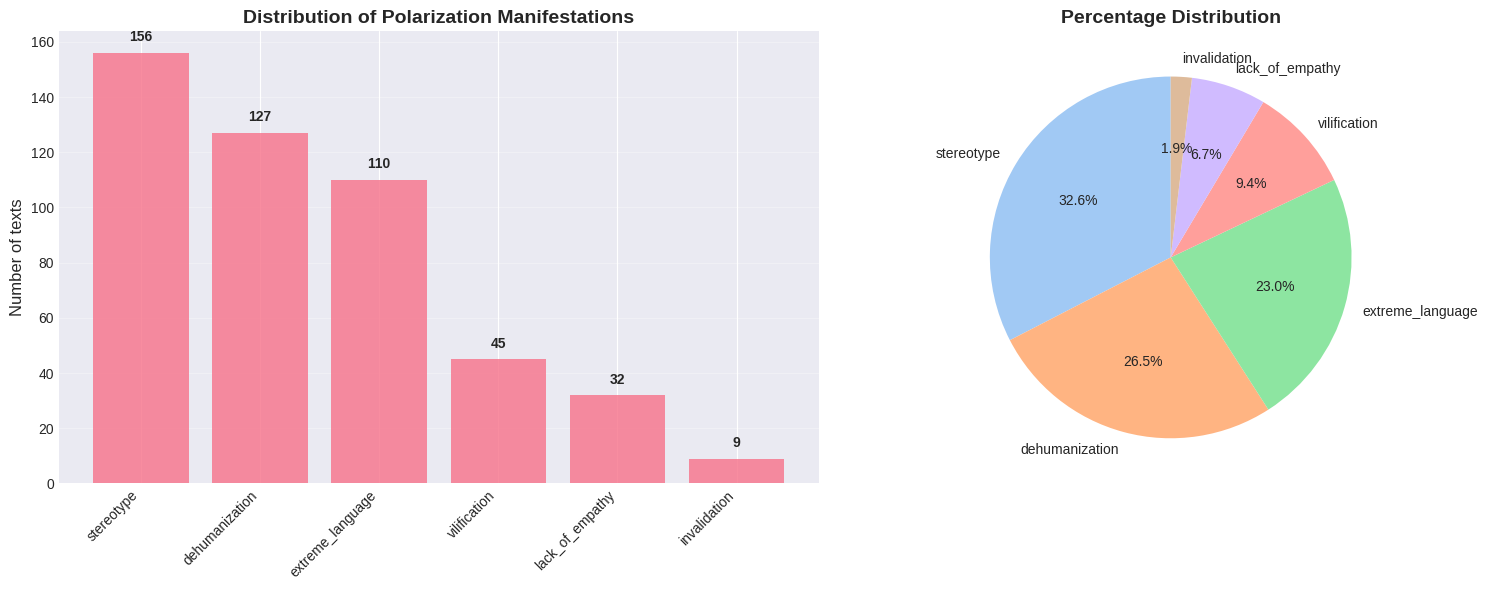

In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (15, 8)

print("=" * 80)
print("1. DISTRIBUTION OF POLARIZATION MANIFESTATIONS")
print("=" * 80)

label_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

label_counts = train_initial[label_cols].sum().sort_values(ascending=False)
label_percentages = (label_counts / len(train_initial) * 100).round(2)

print("\nAbsolute and relative frequencies:")
for label, count in label_counts.items():
    pct = label_percentages[label]
    print(f"{label:20s}: {count:4d} ({pct:5.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(
    range(len(label_counts)),
    label_counts.values,
    alpha=0.8
)
axes[0].set_xticks(range(len(label_counts)))
axes[0].set_xticklabels(label_counts.index, rotation=45, ha="right")
axes[0].set_ylabel("Number of texts", fontsize=12)
axes[0].set_title(
    "Distribution of Polarization Manifestations",
    fontsize=14,
    fontweight="bold"
)
axes[0].grid(axis="y", alpha=0.3)

for i, v in enumerate(label_counts.values):
    axes[0].text(
        i,
        v + 0.02 * max(label_counts.values),
        str(v),
        ha="center",
        va="bottom",
        fontweight="bold"
    )

colors = sns.color_palette("pastel", len(label_counts))
axes[1].pie(
    label_counts.values,
    labels=label_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors
)
axes[1].set_title(
   print("=" * 80)
print("1. DISTRIBUTION OF POLARIZATION MANIFESTATIONS")
print("=" * 80)

label_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
 "Percentage Distribution",
    fontsize=14,
    fontweight="bold"
)

plt.tight_layout()
plt.show()


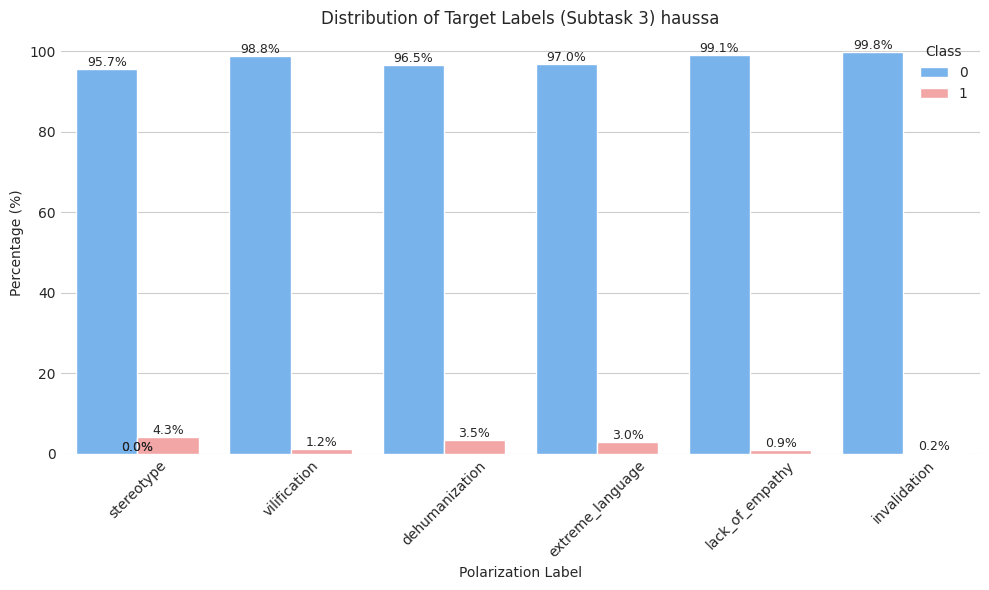

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

label_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

colors_map = {0: '#66b3ff', 1: '#ff9999'}  # Couleurs comme ton pie chart

# Préparer les données
data = []
for label in label_cols:
    counts = train_initial[label].value_counts().reindex([0,1], fill_value=0)
    total = counts.sum()
    for cls, cnt in counts.items():
        data.append({'Label': label, 'Class': cls, 'Count': cnt, 'Pct': cnt/total*100})

df_plot = pd.DataFrame(data)

# Créer le bar plot
plt.figure(figsize=(10,6))
bars = sns.barplot(x='Label', y='Pct', hue='Class', data=df_plot,
                   palette=[colors_map[0], colors_map[1]])

plt.ylabel('Percentage (%)')
plt.xlabel('Polarization Label')
plt.title('Distribution of Target Labels (Subtask 3) haussa')
plt.xticks(rotation=45)

# Ajouter les pourcentages sur chaque barre
for p in bars.patches:
    height = p.get_height()
    bars.annotate(f'{height:.1f}%',
                  (p.get_x() + p.get_width() / 2., height),
                  ha='center', va='bottom', fontsize=9)

plt.legend(title='Class')
plt.tight_layout()
plt.savefig('Distribution_target_subtask_3_haussa_barplot.pdf')
plt.show()


#### identification

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
label_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]


results = []

for i in range(len(label_cols)):
    for j in range(i + 1, len(label_cols)):
        label_i = label_cols[i]
        label_j = label_cols[j]

        # Table de contingence
        contingency_table = pd.crosstab(
            train_initial[label_i],
            train_initial[label_j]
        )

        # Test Khi-deux
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        results.append({
            'Label 1': label_i,
            'Label 2': label_j,
            'Chi2': chi2,
            'p-value': p,
            'DoF': dof
        })

# Résultats sous forme de DataFrame
chi2_results = pd.DataFrame(results).sort_values('p-value')
print("independance analysis in manifestation of polarization identification for haussa language in our dataset")
print(chi2_results)


independance analysis in manifestation of polarization identification for haussa language in our dataset
             Label 1           Label 2       Chi2       p-value  DoF
9     dehumanization  extreme_language  97.349953  5.809604e-23    1
2         stereotype  extreme_language  64.678423  8.817515e-16    1
6       vilification  extreme_language  13.223961  2.763930e-04    1
3         stereotype   lack_of_empathy  13.164174  2.853525e-04    1
10    dehumanization   lack_of_empathy  10.771025  1.031014e-03    1
13  extreme_language      invalidation   5.756071  1.643178e-02    1
0         stereotype      vilification   3.653717  5.594423e-02    1
4         stereotype      invalidation   3.388284  6.566126e-02    1
1         stereotype    dehumanization   3.309546  6.887853e-02    1
12  extreme_language   lack_of_empathy   2.545032  1.106417e-01    1
5       vilification    dehumanization   0.585436  4.441895e-01    1
7       vilification   lack_of_empathy   0.000000  1.000000e+00    


3. TEXT LENGTH ANALYSIS


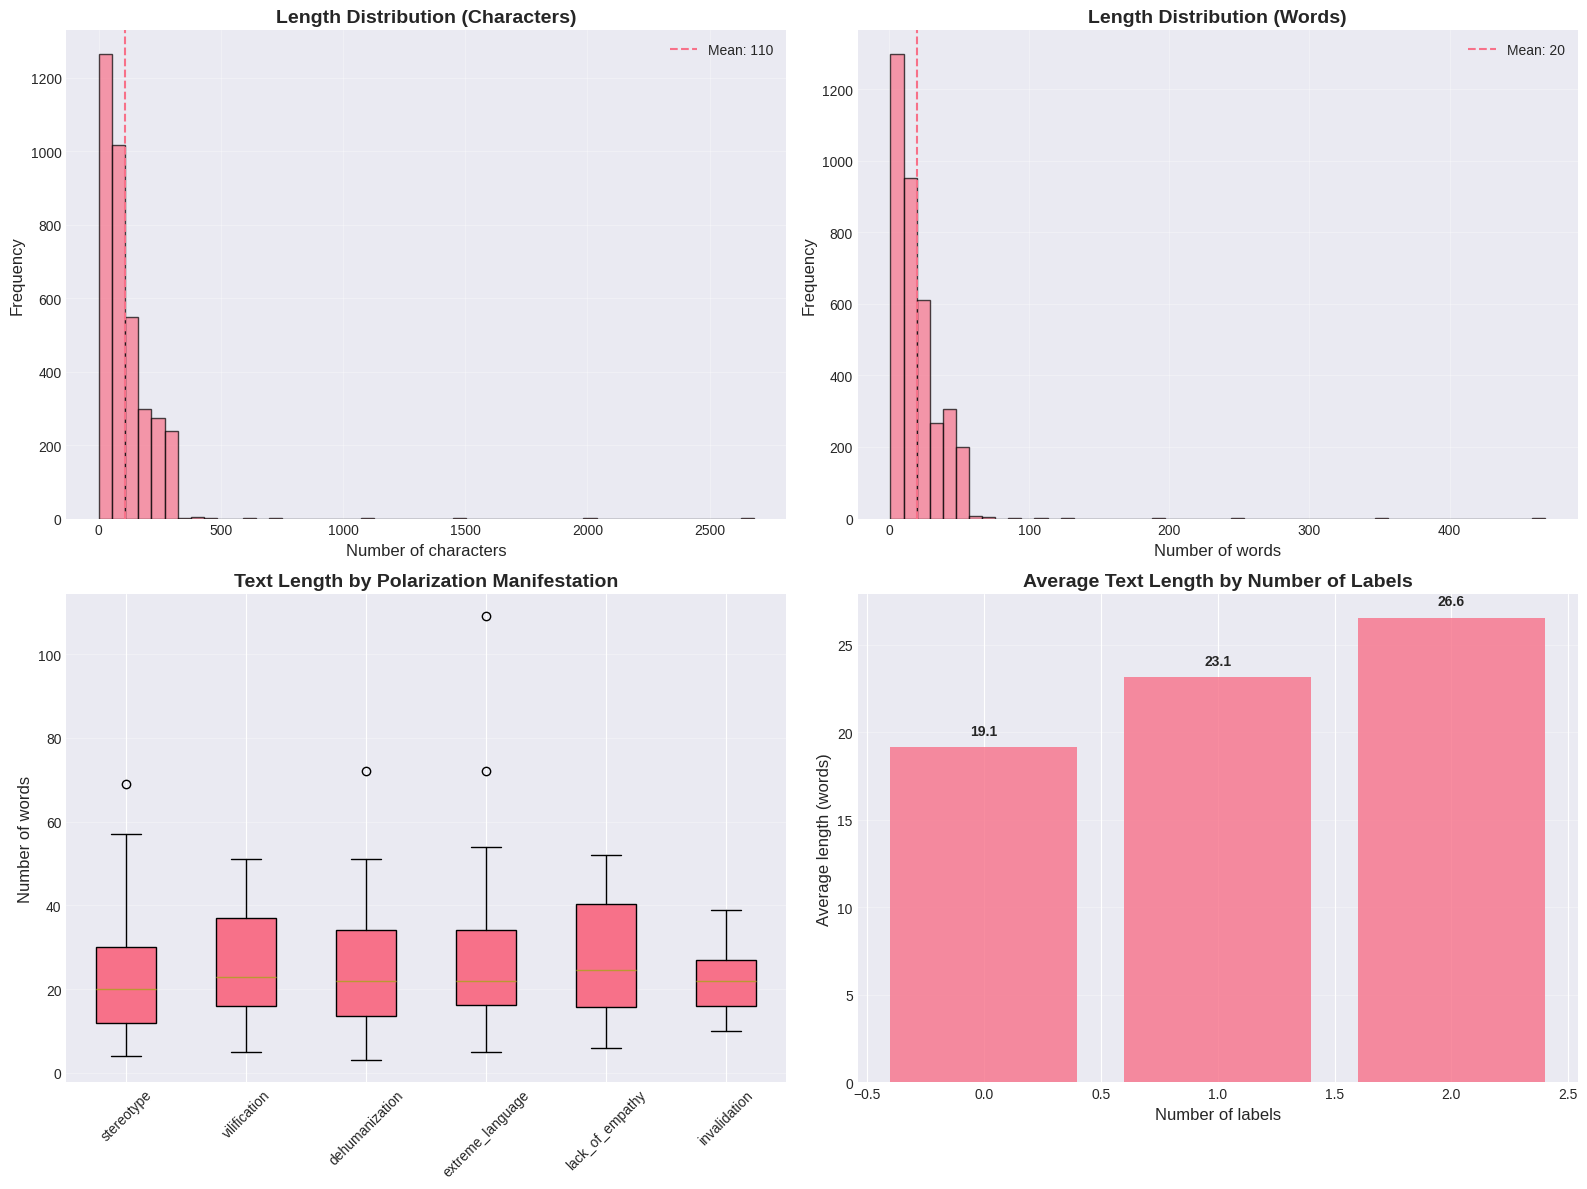

In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (15, 8)

print("\n" + "=" * 80)
print("3. TEXT LENGTH ANALYSIS")
print("=" * 80)

train_initial["text_length"] = train_initial["text"].str.len()
train_initial["word_count"] = train_initial["text"].str.split().str.len()
label_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

train_initial["num_labels"] = train_initial[label_cols].sum(axis=1)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].hist(
    train_initial["text_length"],
    bins=50,
    alpha=0.7,
    edgecolor="black"
)
axes[0, 0].set_xlabel("Number of characters", fontsize=12)
axes[0, 0].set_ylabel("Frequency", fontsize=12)
axes[0, 0].set_title(
    "Length Distribution (Characters)",
    fontsize=14,
    fontweight="bold"
)
axes[0, 0].axvline(
    train_initial["text_length"].mean(),
    linestyle="--",
    label=f"Mean: {train_initial['text_length'].mean():.0f}"
)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(
    train_initial["word_count"],
    bins=50,
    alpha=0.7,
    edgecolor="black"
)
axes[0, 1].set_xlabel("Number of words", fontsize=12)
axes[0, 1].set_ylabel("Frequency", fontsize=12)
axes[0, 1].set_title(
    "Length Distribution (Words)",
    fontsize=14,
    fontweight="bold"
)
axes[0, 1].axvline(
    train_initial["word_count"].mean(),
    linestyle="--",
    label=f"Mean: {train_initial['word_count'].mean():.0f}"
)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

data_for_box = [
    train_initial.loc[train_initial[col] == 1, "word_count"]
    for col in label_cols
]

axes[1, 0].boxplot(
    data_for_box,
    labels=label_cols,
    patch_artist=True
)
axes[1, 0].set_ylabel("Number of words", fontsize=12)
axes[1, 0].set_title(
    "Text Length by Polarization Manifestation",
    fontsize=14,
    fontweight="bold"
)
axes[1, 0].tick_params(axis="x", rotation=45)
axes[1, 0].grid(axis="y", alpha=0.3)

avg_length_by_labels = (
    train_initial
    .groupby("num_labels")["word_count"]
    .mean()
)

axes[1, 1].bar(
    avg_length_by_labels.index,
    avg_length_by_labels.values,
    alpha=0.8
)
axes[1, 1].set_xlabel("Number of labels", fontsize=12)
axes[1, 1].set_ylabel("Average length (words)", fontsize=12)
axes[1, 1].set_title(
    "Average Text Length by Number of Labels",
    fontsize=14,
    fontweight="bold"
)
axes[1, 1].grid(axis="y", alpha=0.3)

for i, v in zip(avg_length_by_labels.index, avg_length_by_labels.values):
    axes[1, 1].text(
        i,
        v + 0.02 * max(avg_length_by_labels.values),
        f"{v:.1f}",
        ha="center",
        va="bottom",
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


6. WORD CLOUDS GENERATION - BIGRAMS


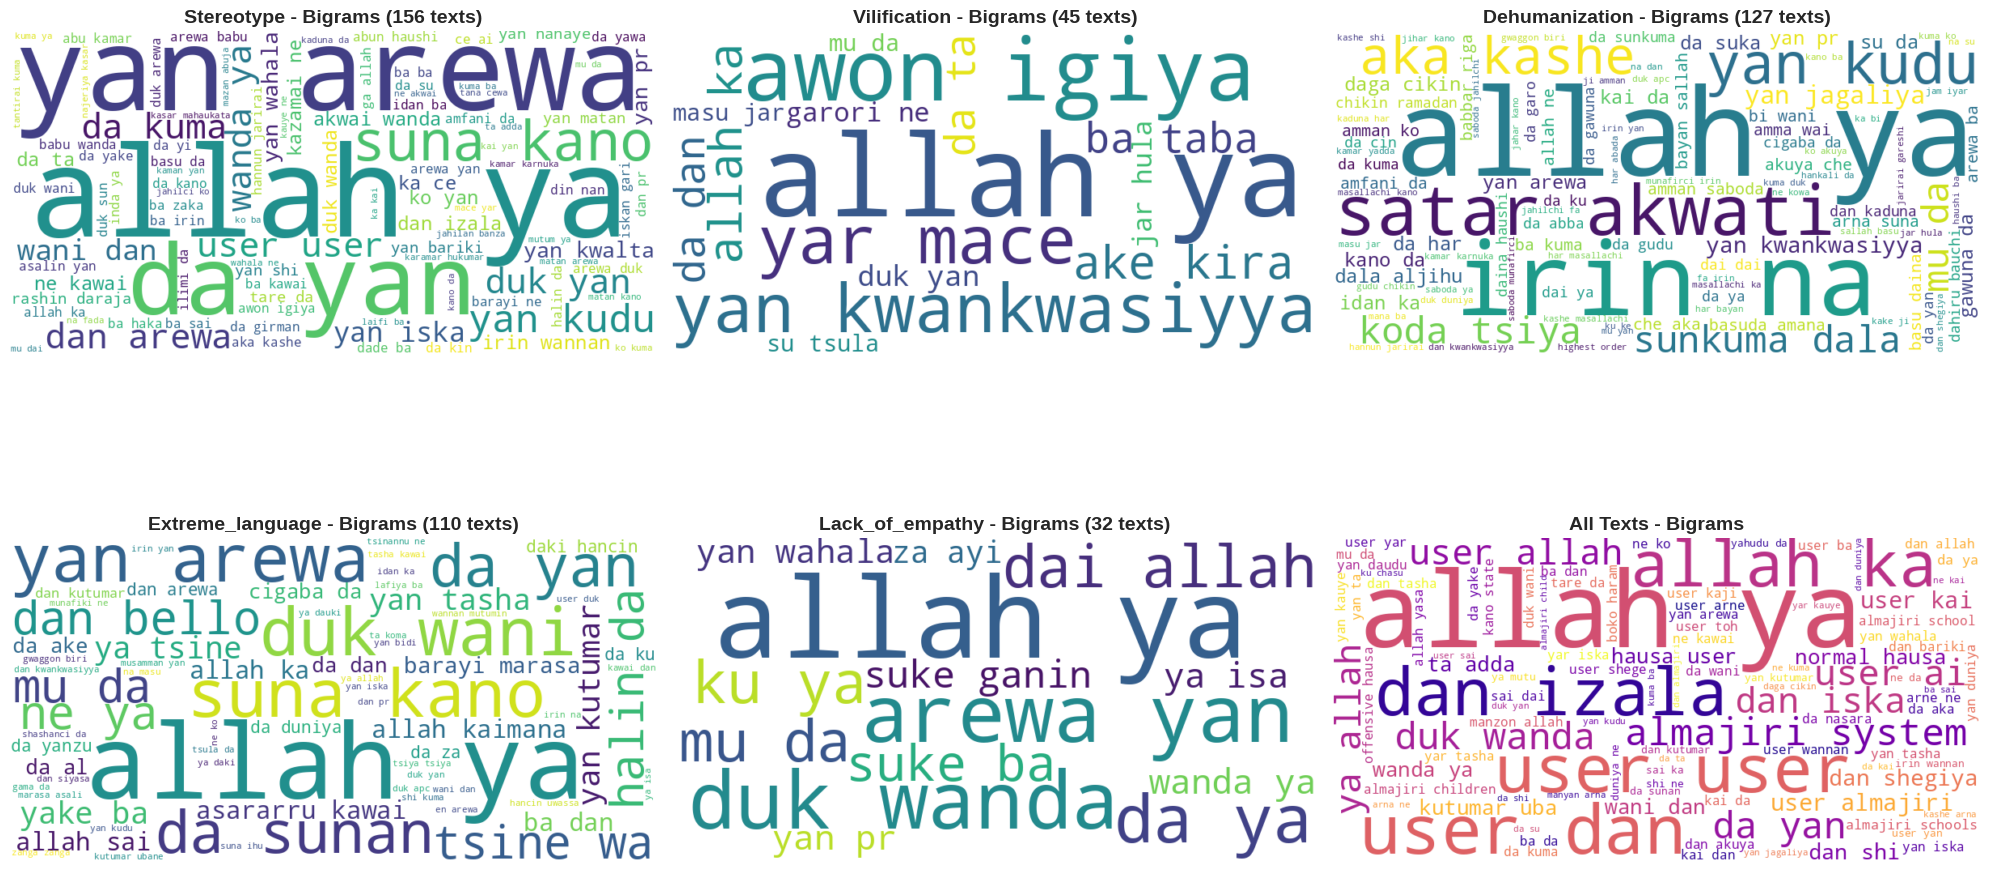

In [ ]:
print("\n" + "="*80)
print("6. WORD CLOUDS GENERATION - BIGRAMS")
print("="*80)

from wordcloud import STOPWORDS, WordCloud # Import WordCloud here
from sklearn.feature_extraction.text import CountVectorizer

custom_stopwords = set(STOPWORDS)
additional_stopwords = {
    'will', 'one', 'two', 'three', 'would', 'could', 'said', 'say', 'even', 'also',
    'get', 'got', 'getting', 'much', 'many', 'may', 'might', 'like', 'go', 'going',
    'make', 'made', 'take', 'know', 'think', 'see', 'want', 'come', 'way', 'time',
    'new', 'first', 'last', 'good', 'great', 'back', 'well', 'still', 'really',
    'us', 'im', 'dont', 'cant', 'wont', 'didnt', 'thats', 'youre', 'theyre', 'ive',
    'http', 'https', 'www', 'com', 'amp', 'rt', 'via', 'url', 'link'
}
custom_stopwords.update(additional_stopwords)

def generate_bigrams(texts):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=list(custom_stopwords),
                                  max_features=100, min_df=2)
    try:
        X = vectorizer.fit_transform(texts)
        bigrams = vectorizer.get_feature_names_out()
        frequencies = X.toarray().sum(axis=0)
        bigram_freq = {bigram: freq for bigram, freq in zip(bigrams, frequencies)}
        return bigram_freq
    except:
        return {}

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, label in enumerate(label_cols):
    texts_with_label = train_initial[train_initial[label] == 1]['text']

    if len(texts_with_label) > 0:
        bigram_freq = generate_bigrams(texts_with_label)

        if bigram_freq:
            wordcloud = WordCloud(
                width=800,
                height=400,
                background_color='white',
                max_words=100,
                colormap='viridis',
                relative_scaling=0.5,
                min_font_size=10
            ).generate_from_frequencies(bigram_freq)

            axes[idx].imshow(wordcloud, interpolation='bilinear')
            axes[idx].set_title(f'{label.capitalize()} - Bigrams ({len(texts_with_label)} texts)',
                               fontsize=14, fontweight='bold')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, 'Insufficient data',
                          ha='center', va='center', fontsize=16)
            axes[idx].set_title(label.capitalize(), fontsize=14, fontweight='bold')
            axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, 'No data',
                      ha='center', va='center', fontsize=16)
        axes[idx].set_title(label.capitalize(), fontsize=14, fontweight='bold')
        axes[idx].axis('off')

bigram_freq_all = generate_bigrams(train_initial['text'])
wordcloud_all = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    colormap='plasma',
    relative_scaling=0.5,
    min_font_size=10
).generate_from_frequencies(bigram_freq_all)

axes[-1].imshow(wordcloud_all, interpolation='bilinear')
axes[-1].set_title('All Texts - Bigrams', fontsize=14, fontweight='bold')
axes[-1].axis('off')

plt.tight_layout()
plt.show()

### 3.2.3 Data split

In [ ]:
# Removed: !pip install iterstrat - as it was incorrect and caused an error.

ERROR: Invalid requirement: '-': Expected package name at the start of dependency specifier
    -
    ^


In [ ]:
!pip install iterative-stratification

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import pandas as pd

target_cols = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

X = train_initial["text"].values.reshape(-1, 1)
y = train_initial[target_cols].values

splitter = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

for train_index, valid_index in splitter.split(X, y):
    X_train_data, X_valid_data = train_initial.iloc[train_index], train_initial.iloc[valid_index]
    y_train_data, y_valid_data = y[train_index], y[valid_index]

train = X_train_data.copy()
val = X_valid_data.copy()

print("\n--- Vérification de la Stratification ---")
print("Compte des Positifs dans Train (devrait être proche de 95% du total) :")
print(train[target_cols].sum())

print("\nCompte des Positifs dans Val (devrait être proche de 5% du total) :")
print(val[target_cols].sum())


--- Vérification de la Stratification ---
Compte des Positifs dans Train (devrait être proche de 95% du total) :
stereotype          125
vilification         36
dehumanization      102
extreme_language     88
lack_of_empathy      26
invalidation          7
dtype: int64

Compte des Positifs dans Val (devrait être proche de 5% du total) :
stereotype          31
vilification         9
dehumanization      25
extreme_language    22
lack_of_empathy      6
invalidation         2
dtype: int64


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

set_seed(42)

MODEL_NAME = 'Davlan/afro-xlmr-small'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
MAX_OVERSAMPLE_RATIO = 5

USE_GPU = torch.cuda.is_available()
print(f"Device used: {'cuda' if USE_GPU else 'cpu'}")

def safe_gpu_cleanup():
    """Nettoie la mémoire GPU de manière sécurisée"""
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class CustomBinaryTrainer(Trainer):
    def __init__(self, pos_weight=None, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = torch.tensor(pos_weight, dtype=torch.float32) if pos_weight is not None else None

        if self.pos_weight is not None and self.args.fp16:
            self.pos_weight = self.pos_weight.half()

        if USE_GPU and self.pos_weight is not None:
            self.pos_weight = self.pos_weight.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0): # Added num_items_in_batch
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits').squeeze(-1)

        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)

        loss = loss_fct(logits, labels.squeeze(-1))

        return (loss, outputs) if return_outputs else loss

class PolarizationBinaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return item

class BinaryDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)
        # Corrected line:
        batch['labels'] = torch.stack(labels).float()
        return batch

def compute_metrics_binary(p):
    probs = torch.sigmoid(torch.tensor(p.predictions)).numpy().flatten()
    preds = (probs >= 0.5).astype(int)
    labels = p.label_ids.flatten()
    return {
        'f1_binary': f1_score(labels, preds, average='binary', zero_division=0),
        'accuracy': accuracy_score(labels, preds)
    }

def find_optimal_threshold_binary(y_true, logits):
    y_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    best_f1, best_t = 0.0, 0.5
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
binary_data_collator = BinaryDataCollator(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./ovr_training_afro_xlmr_weighted",
    num_train_epochs=3,
    # Corrected line - removed misplaced code:
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=True,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_binary",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1,
    warmup_steps=100,
    weight_decay=0.01,
)

ovr_results = {'models': {}, 'thresholds': {}, 'f1_scores': {}}

for idx, label in enumerate(target_cols, 1):
    print(f"\nTraining Model [{idx}/{len(target_cols)}] CLASS: {label.upper()} (Afro-XLM-R Small)")

    safe_gpu_cleanup()

    try:
        train_labels = train[label].astype(int)
        val_labels = val[label].astype(int).tolist()
    except NameError:
        print("ERROR: 'train' or 'val' DataFrame not found. Please load them before execution.")
        exit()

    num_positives_orig = train_labels.sum()
    num_negatives_orig = len(train_labels) - num_positives_orig

    if num_positives_orig > 0:
        pos_weight_value = num_negatives_orig / num_positives_orig
        print(f"  Class Weighting applied. Positive Weight (Original Data): {pos_weight_value:.2f}")
    else:
        pos_weight_value = 1.0
        print("  Class Weighting skipped (No positives).")

    train_df_current = train.copy()

    positive_indices = train_df_current[train_labels == 1].index
    num_positives = len(positive_indices)
    num_negatives = len(train_df_current) - num_positives

    if num_positives > 0 and num_negatives / num_positives > MAX_OVERSAMPLE_RATIO:
        reps = int(np.ceil(num_negatives / num_positives / MAX_OVERSAMPLE_RATIO)) - 1
        positive_samples_to_duplicate = train_df_current.loc[positive_indices].copy()
        oversampled_positives = pd.concat([positive_samples_to_duplicate] * reps, ignore_index=True)
        train_df_oversampled = pd.concat([train_df_current, oversampled_positives], ignore_index=True)

        print(f"  Oversampling applied. New N_positives: {num_positives * (reps + 1)}, New N_negatives: {num_negatives}")
    else:
        train_df_oversampled = train_df_current.copy()
        print("  Oversampling skipped (Ratio already acceptable or no positives).")

    train_texts = train_df_oversampled['text'].tolist()
    train_labels_oversampled = train_df_oversampled[label].astype(int).tolist()

    train_dataset = PolarizationBinaryDataset(train_texts, train_labels_oversampled, tokenizer)
    val_dataset = PolarizationBinaryDataset(val['text'].tolist(), val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=1,
        problem_type="multi_label_classification",
    )

    output_dir_label = f"./ovr_models_afro_xlmr_weighted/{label}"
    os.makedirs(output_dir_label, exist_ok=True)

    trainer = CustomBinaryTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary,
        data_collator=binary_data_collator,
        pos_weight=pos_weight_value
    )

    trainer.train()

    predictions_output = trainer.predict(val_dataset)
    best_threshold, best_f1 = find_optimal_threshold_binary(np.array(val_labels), predictions_output.predictions)

    ovr_results['models'][label] = output_dir_label
    ovr_results['thresholds'][label] = best_threshold
    ovr_results['f1_scores'][label] = best_f1

    trainer.save_model(output_dir_label)
    del model, trainer
    safe_gpu_cleanup()

    print(f"✓ Optimal Threshold: {best_threshold:.3f}, F1-score: {best_f1:.4f}")

Device used: cuda


tokenizer_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]


Training Model [1/6] CLASS: VILIFICATION (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 96.33
  Oversampling applied. New N_positives: 600, New N_negatives: 2890


config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/561M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.390, F1-score: 0.3077

Training Model [2/6] CLASS: EXTREME_LANGUAGE (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 33.76
  Oversampling applied. New N_positives: 588, New N_negatives: 2836


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.950, F1-score: 0.3077

Training Model [3/6] CLASS: STEREOTYPE (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 21.99
  Oversampling applied. New N_positives: 635, New N_negatives: 2793


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.660, F1-score: 0.4000

Training Model [4/6] CLASS: INVALIDATION (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 364.00
  Oversampling applied. New N_positives: 584, New N_negatives: 2912


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.500, F1-score: 0.0000

Training Model [5/6] CLASS: LACK_OF_EMPATHY (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 96.33
  Oversampling applied. New N_positives: 600, New N_negatives: 2890


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.020, F1-score: 0.0075

Training Model [6/6] CLASS: DEHUMANIZATION (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 28.49
  Oversampling applied. New N_positives: 594, New N_negatives: 2821


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.160, F1-score: 0.3750


In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import f1_score

print("\n--- Starting Final Evaluation on Validation Set (Afro-XLM-R Weighted) ---")

all_val_preds = []
try:
    all_val_labels = val[target_cols].values
except NameError:
    print("ERROR: 'val' DataFrame not found for final evaluation.")
    exit()

eval_args = TrainingArguments(
    output_dir="./ovr_eval_afro_xlmr_weighted",
    per_device_eval_batch_size=16,
    report_to="none",
)

binary_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


for label in target_cols:
    safe_gpu_cleanup()

    print(f"-> Evaluating model for class: {label}")

    model_path = f"./ovr_models_afro_xlmr_weighted/{label}"

    try:
        model_binary = AutoModelForSequenceClassification.from_pretrained(model_path)
    except Exception as e:
        model_path = ovr_results['models'].get(label, model_path)
        try:
            model_binary = AutoModelForSequenceClassification.from_pretrained(model_path)
        except Exception as e:
            print(f"ERROR: Unable to load model from {model_path}. Error: {e}")
            continue

    val_labels_current = val[label].astype(int).tolist()
    val_dataset_binary = PolarizationBinaryDataset(val['text'].tolist(), val_labels_current, tokenizer, MAX_LENGTH)

    trainer_binary = Trainer(
        model=model_binary,
        args=eval_args,
        eval_dataset=val_dataset_binary,
        data_collator=binary_data_collator
    )

    predictions_output = trainer_binary.predict(val_dataset_binary)
    logits = predictions_output.predictions

    probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()

    try:
        threshold = ovr_results['thresholds'][label]
    except KeyError:
        print(f"ERROR: Optimal threshold not found in ovr_results for class {label}. Using 0.5.")
        threshold = 0.5

    preds = (probs >= threshold).astype(int)
    all_val_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

final_preds_ovr = np.stack(all_val_preds, axis=1)

f1_macro_final = f1_score(all_val_labels, final_preds_ovr, average='macro', zero_division=0)
f1_per_class = f1_score(all_val_labels, final_preds_ovr, average=None, zero_division=0)

print("\nFINAL RESULTS - METHOD Afro-XLM-R Small (Augmented + Weighted)")
print("======================================================================")
print(f"\n🎯 GLOBAL MACRO F1: {f1_macro_final:.4f}\n")
print("F1-Score per Class:")
print("──────────────────────────────────────────────────────────────────────")
for label, f1 in zip(target_cols, f1_per_class):
    threshold = ovr_results['thresholds'].get(label, 0.5)
    print(f"  {label:20s}: {f1:.4f}  (threshold: {threshold:.3f})")

print("\n✓ EVALUATION COMPLETED. The Macro F1 score is the performance to compare.")


--- Starting Final Evaluation on Validation Set (Afro-XLM-R Weighted) ---
-> Evaluating model for class: vilification


-> Evaluating model for class: extreme_language


-> Evaluating model for class: stereotype


-> Evaluating model for class: invalidation


-> Evaluating model for class: lack_of_empathy


-> Evaluating model for class: dehumanization



FINAL RESULTS - METHOD Afro-XLM-R Small (Augmented + Weighted)

🎯 GLOBAL MACRO F1: 0.2323

F1-Score per Class:
──────────────────────────────────────────────────────────────────────
  vilification        : 0.3077  (threshold: 0.390)
  extreme_language    : 0.3077  (threshold: 0.950)
  stereotype          : 0.4000  (threshold: 0.660)
  invalidation        : 0.0000  (threshold: 0.500)
  lack_of_empathy     : 0.0075  (threshold: 0.020)
  dehumanization      : 0.3711  (threshold: 0.160)

✓ EVALUATION COMPLETED. The Macro F1 score is the performance to compare.


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    DataCollatorWithPadding,
    TrainingArguments
)
from torch.utils.data import Dataset

MODEL_NAME = 'Davlan/afro-xlmr-small'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]

try:
    test_data = pd.read_csv('subtask3/dev/hau.csv')
except FileNotFoundError:
    print("ERROR: Test data file ('subtask3/dev/hau.csv') not found. Please check the path.")
    exit()

USE_GPU = torch.cuda.is_available()

prediction_args = TrainingArguments(
    output_dir="./ovr_prediction_afro_xlmr_weighted",
    per_device_eval_batch_size=16,
    fp16=USE_GPU,
    report_to="none",
)

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: encoding[key].squeeze(0) for key in encoding.keys()}

try:
    test_dataset = PredictionDataset(test_data['text'].tolist(), tokenizer)
    binary_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
except NameError:
    print("ERROR: 'tokenizer' is not defined.")
    exit()


print(f"\n--- Starting Afro-XLM-R Weighted Prediction on {len(test_data)} samples ---")

all_test_preds = []

for label in target_cols:
    safe_gpu_cleanup()

    model_path_base = f"./ovr_models_afro_xlmr_weighted/{label}"
    threshold = ovr_results['thresholds'].get(label, 0.5)

    try:
        model_path = ovr_results['models'].get(label, model_path_base)
    except NameError:
        model_path = model_path_base
        print(f"WARNING: 'ovr_results' not found. Using default path: {model_path_base}")

    print(f"-> Predicting for class '{label}' (Threshold: {threshold:.3f})")

    try:
        model_binary = AutoModelForSequenceClassification.from_pretrained(model_path)
    except Exception as e:
        print(f"ERROR: Unable to load model from {model_path}. {e}")
        continue

    trainer_binary = Trainer(
        model=model_binary,
        args=prediction_args,
        data_collator=binary_data_collator
    )

    predictions_output = trainer_binary.predict(test_dataset)
    logits = predictions_output.predictions

    test_probabilities = torch.sigmoid(torch.tensor(logits)).numpy().flatten()

    preds = (test_probabilities >= threshold).astype(int).flatten()
    all_test_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

final_predictions = np.stack(all_test_preds, axis=1)

submission_df = pd.DataFrame(
    final_predictions,
    columns=target_cols
)

submission_df.insert(0, 'id', test_data['id'])

for col in target_cols:
    submission_df[col] = submission_df[col].astype(int)

filename = 'pred_subtask3_hau_afro_xlmr_weighted.csv'
submission_df.to_csv(filename, index=False)

print("\n" + "="*80)
print("FINAL PREDICTION RESULTS (Afro-XLM-R Small Weighted - Hausa)")
print("="*80)
print("--- Submission File Preview (first 5 rows) ---")
print(submission_df.head())

print(f"\nFinal submission file generated: {filename}")
print("Optimal thresholds used per class:")
for label in target_cols:
    print(f"  {label:20s}: {ovr_results['thresholds'].get(label, 'N/A'):.3f}")


--- Starting Afro-XLM-R Weighted Prediction on 182 samples ---
-> Predicting for class 'vilification' (Threshold: 0.390)


-> Predicting for class 'extreme_language' (Threshold: 0.950)


-> Predicting for class 'stereotype' (Threshold: 0.660)


-> Predicting for class 'invalidation' (Threshold: 0.500)


-> Predicting for class 'lack_of_empathy' (Threshold: 0.020)


-> Predicting for class 'dehumanization' (Threshold: 0.160)



FINAL PREDICTION RESULTS (Afro-XLM-R Small Weighted - Hausa)
--- Submission File Preview (first 5 rows) ---
                                     id  vilification  extreme_language  \
0  hau_7bafacd606d9dee74e7cee95f8277d4e             0                 0   
1  hau_cbf1bdd94361d60e55c6774b2a69198a             0                 0   
2  hau_8e2286abdaa2b53c5a43e2a13e11cddd             0                 0   
3  hau_1fcff27ecdc63dca7852720481daf56d             0                 0   
4  hau_fbfe2c9ca8b5bb50f1fd4cd295c95a15             0                 0   

   stereotype  invalidation  lack_of_empathy  dehumanization  
0           0             0                0               0  
1           0             0                0               0  
2           0             0                0               0  
3           0             0                1               1  
4           0             0                0               0  

Final submission file generated: pred_subtask3_hau_afro_xlmr_

#### augnbtation of number of epcohes and max lengths

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

set_seed(42)

MODEL_NAME = 'Davlan/afro-xlmr-small'
MAX_LENGTH = 512  # Changed from 812 to 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
MAX_OVERSAMPLE_RATIO = 5

USE_GPU = torch.cuda.is_available()
print(f"Device used: {'cuda' if USE_GPU else 'cpu'}")

def safe_gpu_cleanup():
    """Nettoie la mémoire GPU de manière sécurisée"""
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class CustomBinaryTrainer(Trainer):
    def __init__(self, pos_weight=None, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = torch.tensor(pos_weight, dtype=torch.float32) if pos_weight is not None else None

        if self.pos_weight is not None and self.args.fp16:
            self.pos_weight = self.pos_weight.half()

        if USE_GPU and self.pos_weight is not None:
            self.pos_weight = self.pos_weight.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0): # Added num_items_in_batch
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits').squeeze(-1)

        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)

        loss = loss_fct(logits, labels.squeeze(-1))

        return (loss, outputs) if return_outputs else loss

class PolarizationBinaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return item

class BinaryDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)
        # Corrected line:
        batch['labels'] = torch.stack(labels).float()
        return batch

def compute_metrics_binary(p):
    probs = torch.sigmoid(torch.tensor(p.predictions)).numpy().flatten()
    preds = (probs >= 0.5).astype(int)
    labels = p.label_ids.flatten()
    return {
        'f1_binary': f1_score(labels, preds, average='binary', zero_division=0),
        'accuracy': accuracy_score(labels, preds)
    }

def find_optimal_threshold_binary(y_true, logits):
    y_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    best_f1, best_t = 0.0, 0.5
    for t in np.arange(0.01, 1.0, 0.03):
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
binary_data_collator = BinaryDataCollator(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./ovr_training_afro_xlmr_weighted",
    num_train_epochs=6,
    # Corrected line - removed misplaced code:
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=True,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_binary",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1,
    warmup_steps=100,
    weight_decay=0.01,
)

ovr_results = {'models': {}, 'thresholds': {}, 'f1_scores': {}}

for idx, label in enumerate(target_cols, 1):
    print(f"\nTraining Model [{idx}/{len(target_cols)}] CLASS: {label.upper()} (Afro-XLM-R Small)")

    safe_gpu_cleanup()

    try:
        train_labels = train[label].astype(int)
        val_labels = val[label].astype(int).tolist()
    except NameError:
        print("ERROR: 'train' or 'val' DataFrame not found. Please load them before execution.")
        exit()

    num_positives_orig = train_labels.sum()
    num_negatives_orig = len(train_labels) - num_positives_orig

    if num_positives_orig > 0:
        pos_weight_value = num_negatives_orig / num_positives_orig
        print(f"  Class Weighting applied. Positive Weight (Original Data): {pos_weight_value:.2f}")
    else:
        pos_weight_value = 1.0
        print("  Class Weighting skipped (No positives).")

    train_df_current = train.copy()

    positive_indices = train_df_current[train_labels == 1].index
    num_positives = len(positive_indices)
    num_negatives = len(train_df_current) - num_positives

    if num_positives > 0 and num_negatives / num_positives > MAX_OVERSAMPLE_RATIO:
        reps = int(np.ceil(num_negatives / num_positives / MAX_OVERSAMPLE_RATIO)) - 1
        positive_samples_to_duplicate = train_df_current.loc[positive_indices].copy()
        oversampled_positives = pd.concat([positive_samples_to_duplicate] * reps, ignore_index=True)
        train_df_oversampled = pd.concat([train_df_current, oversampled_positives], ignore_index=True)

        print(f"  Oversampling applied. New N_positives: {num_positives * (reps + 1)}, New N_negatives: {num_negatives}")
    else:
        train_df_oversampled = train_df_current.copy()
        print("  Oversampling skipped (Ratio already acceptable or no positives).")

    train_texts = train_df_oversampled['text'].tolist()
    train_labels_oversampled = train_df_oversampled[label].astype(int).tolist()

    train_dataset = PolarizationBinaryDataset(train_texts, train_labels_oversampled, tokenizer)
    val_dataset = PolarizationBinaryDataset(val['text'].tolist(), val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=1,
        problem_type="multi_label_classification",
    )

    output_dir_label = f"./ovr_models_afro_xlmr_weighted/{label}"
    os.makedirs(output_dir_label, exist_ok=True)

    trainer = CustomBinaryTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary,
        data_collator=binary_data_collator,
        pos_weight=pos_weight_value
    )

    trainer.train()

    predictions_output = trainer.predict(val_dataset)
    best_threshold, best_f1 = find_optimal_threshold_binary(np.array(val_labels), predictions_output.predictions)

    ovr_results['models'][label] = output_dir_label
    ovr_results['thresholds'][label] = best_threshold
    ovr_results['f1_scores'][label] = best_f1

    trainer.save_model(output_dir_label)
    del model, trainer
    safe_gpu_cleanup()

    print(f"✓ Optimal Threshold: {best_threshold:.3f}, F1-score: {best_f1:.4f}")

Device used: cuda

Training Model [1/6] CLASS: VILIFICATION (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 80.11
  Oversampling applied. New N_positives: 612, New N_negatives: 2884


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc

✓ Optimal Threshold: 0.910, F1-score: 0.2353

Training Model [2/6] CLASS: EXTREME_LANGUAGE (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 32.18
  Oversampling applied. New N_positives: 616, New N_negatives: 2832


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc

✓ Optimal Threshold: 0.790, F1-score: 0.3896

Training Model [3/6] CLASS: STEREOTYPE (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 22.36
  Oversampling applied. New N_positives: 625, New N_negatives: 2795


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc

✓ Optimal Threshold: 0.520, F1-score: 0.4198

Training Model [4/6] CLASS: INVALIDATION (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 416.14
  Oversampling applied. New N_positives: 588, New N_negatives: 2913


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc

#### optimisation du modele : Afro xmlr smal +data augmen

##### optimisationof seui

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed,
    get_cosine_schedule_with_warmup
)
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from transformers import TrainerCallback, TrainerState, TrainerControl
import warnings
import random
# Si l'installation de 'nlpaug' a réussi, ces imports fonctionnent
try:
    import nlpaug.augmenter.word as naw
except ImportError:
    print("⚠️ nlpaug not installed. Advanced augmentation disabled.")
    naw = None

warnings.filterwarnings('ignore')
set_seed(42)
random.seed(42)
np.random.seed(42)

# ============================================================================
# CONFIGURATION
# ============================================================================
MODEL_NAME = 'Davlan/afro-xlmr-small'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization']

# Hyperparamètres optimisés
GAMMA_FOCAL = 2.5
ALPHA_FOCAL = 0.3
MAX_OVERSAMPLE_RATIO = 3
AUGMENTATION_FACTOR = 2

# Nouveaux hyperparamètres
USE_DATA_AUGMENTATION = (naw is not None)
USE_ENSEMBLE_THRESHOLDS = True
EARLY_STOPPING_PATIENCE = 3
USE_GPU = torch.cuda.is_available()

print(f"🔧 Device: {'GPU (' + torch.cuda.get_device_name(0) + ')' if USE_GPU else 'CPU'}")
print(f"📝 Augmentation active: {USE_DATA_AUGMENTATION}")

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

# ============================================================================
# DATA AUGMENTATION
# ============================================================================
class TextAugmenter:
    def __init__(self):
        self.aug_syn = None
        self.aug_insert = None
        if naw:
            try:
                self.aug_syn = naw.SynonymAug(aug_src='wordnet', aug_max=3)
                self.aug_insert = naw.ContextualWordEmbsAug(
                    model_path='bert-base-uncased',
                    action="insert",
                    aug_max=2
                )
            except Exception as e:
                print(f"⚠️  Augmentation avancée désactivée (erreur: {e})")

    def augment_simple(self, text):
        words = text.split()
        if len(words) < 3:
            return text
        if random.random() > 0.5 and len(words) > 2:
            idx = random.randint(0, len(words) - 2)
            words[idx], words[idx + 1] = words[idx + 1], words[idx]
        if random.random() > 0.7 and len(words) > 5:
            words.pop(random.randint(0, len(words) - 1))
        return ' '.join(words)

    def augment(self, text, num_augments=1):
        augmented = []
        for _ in range(num_augments):
            aug_text = None
            try:
                if self.aug_syn and random.random() > 0.5:
                    aug_text = self.aug_syn.augment(text)
                elif self.aug_insert and random.random() > 0.5:
                    aug_text = self.aug_insert.augment(text)

                if aug_text and isinstance(aug_text, list):
                    aug_text = aug_text[0]

                if not aug_text:
                    aug_text = self.augment_simple(text)

                augmented.append(aug_text)
            except:
                augmented.append(self.augment_simple(text))
        return augmented

# ============================================================================
# FOCAL LOSS AVEC POIDS DE CLASSE ADAPTATIFS
# ============================================================================
class AdaptiveFocalLossTrainer(Trainer):
    def __init__(self, gamma=GAMMA_FOCAL, alpha=ALPHA_FOCAL, class_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
        self.class_weights = class_weights
        self.alpha_neg = 1 - alpha

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.pop("labels").squeeze(-1)
        outputs = model(**inputs)
        logits = outputs.get('logits').squeeze(-1)

        probs = torch.sigmoid(logits)

        log_p = torch.log(probs.clamp(min=1e-10))
        log_1_p = torch.log((1 - probs).clamp(min=1e-10))

        pt = torch.where(labels == 1, probs, 1 - probs)
        log_pt = torch.where(labels == 1, log_p, log_1_p)

        alpha_factor = torch.where(
            labels == 1,
            torch.full_like(labels, self.alpha, dtype=torch.float32),
            torch.full_like(labels, self.alpha_neg, dtype=torch.float32)
        )

        if self.class_weights is not None:
            class_weight = torch.where(
                labels == 1,
                torch.tensor(self.class_weights[1], device=labels.device, dtype=torch.float32),
                torch.tensor(self.class_weights[0], device=labels.device, dtype=torch.float32)
            )
            alpha_factor = alpha_factor * class_weight

        focal_term = (1 - pt) ** self.gamma
        loss = - (alpha_factor * focal_term * log_pt)

        loss = torch.mean(loss)

        return (loss, outputs) if return_outputs else loss

# ============================================================================
# DATASET ET COLLATOR
# ============================================================================
class PolarizationBinaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return item

class BinaryDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)
        batch['labels'] = torch.stack(labels).float()
        return batch

# ============================================================================
# MÉTRIQUES ET SEUILS
# ============================================================================
def compute_metrics_binary(p):
    probs = torch.sigmoid(torch.tensor(p.predictions)).numpy().flatten()
    preds = (probs >= 0.5).astype(int)
    labels = p.label_ids.flatten()

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )

    return {
        'f1_binary': f1,
        'accuracy': accuracy_score(labels, preds),
        'precision': precision,
        'recall': recall
    }

def find_optimal_threshold_ensemble(y_true, logits, n_splits=3):
    y_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()

    if USE_ENSEMBLE_THRESHOLDS and len(y_true) > 100 and len(np.unique(y_true)) > 1:
        skf = StratifiedKFold(n_splits=min(n_splits, 5))
        best_thresholds = []

        # Correction ici: split doit être fait sur y_true pour la stratification
        for fold, (train_idx, val_idx) in enumerate(skf.split(y_probs, y_true)):
            y_true_fold = y_true[val_idx]
            y_probs_fold = y_probs[val_idx]

            best_f1, best_t = 0.0, 0.5
            for t in np.arange(0.05, 0.95, 0.02):
                y_pred = (y_probs_fold >= t).astype(int)
                f1 = f1_score(y_true_fold, y_pred, average='binary', zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_t = t

            best_thresholds.append(best_t)

        optimal_threshold = np.mean(best_thresholds)
    else:
        best_f1, optimal_threshold = 0.0, 0.5
        for t in np.arange(0.01, 1.0, 0.01):
            y_pred = (y_probs >= t).astype(int)
            f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                optimal_threshold = t

    y_pred_final = (y_probs >= optimal_threshold).astype(int)
    final_f1 = f1_score(y_true, y_pred_final, average='binary', zero_division=0)

    return optimal_threshold, final_f1

# ============================================================================
# CALLBACK POUR EARLY STOPPING AVANCÉ
# ============================================================================
class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, patience=EARLY_STOPPING_PATIENCE, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = None
        self.wait = 0

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, metrics, **kwargs):
        current_metric = metrics.get('eval_f1_binary')

        if current_metric is None:
            return

        if self.best_metric is None:
            self.best_metric = current_metric
        elif current_metric > self.best_metric + self.min_delta:
            self.best_metric = current_metric
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                control.should_training_stop = True
                print(f"\n⏹️  Early stopping triggered after {self.wait} epochs without improvement")

# ============================================================================
# INITIALISATION
# ============================================================================
print("="*70)
print("🚀 INITIALIZATION - IMPROVED OVR STRATEGY")
print("="*70)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
binary_data_collator = BinaryDataCollator(tokenizer=tokenizer)
if USE_DATA_AUGMENTATION:
    print("\n📝 Initializing data augmentation...")
    augmenter = TextAugmenter()
    print("   ✓ Augmentation activated")

# ADJUSTED TRAINING ARGUMENTS (Effective Batch Size = 4 * 2 = 8)
training_args = TrainingArguments(
    output_dir="./ovr_training_improved",
    num_train_epochs=8,
    per_device_train_batch_size=8, # Increased base batch size
    per_device_eval_batch_size=8,
    fp16=USE_GPU,
    gradient_accumulation_steps=2, # Accumulate over 2 steps
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_binary",
    greater_is_better=True,
    logging_steps=25,
    report_to="none",
    save_total_limit=2,
    warmup_ratio=0.1,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
)
ovr_results = {
    'models': {},
    'thresholds': {},
    'f1_scores': {},
    'metrics': {}}

# ============================================================================
# IMPROVED OVR TRAINING LOOP
# ============================================================================
print("\n" + "="*70)
print("🎯 STARTING IMPROVED OVR TRAINING")
print("="*70)
for idx, label in enumerate(target_cols, 1):
    print(f"\n{'='*70}")
    print(f"[{idx}/{len(target_cols)}] CLASS: {label.upper()}")
    print(f"{'-'*70}")

    safe_gpu_cleanup()

    try:
        train_labels = train[label].astype(int)
        val_labels = val[label].astype(int).tolist()
    except NameError:
        print("❌ ERROR: 'train' and 'val' DataFrames not found. Exiting.")
        exit()

    train_df_current = train.copy()

    # --- INTELLIGENT OVERSAMPLING & CLASS WEIGHTS ---
    positive_indices = train_df_current[train_labels == 1].index
    num_positives = len(positive_indices)
    num_negatives = len(train_df_current) - num_positives

    class_weights = [1.0, 1.0]

    if num_positives > 0:
        # Calculate base class weights (used to adjust ALPHA in Focal Loss)
        class_weights = [
            len(train_df_current) / (2 * num_negatives),  # Negative weight
            len(train_df_current) / (2 * num_positives)   # Positive weight
        ]

        print(f"\n📊 Original distribution:")
        print(f"   Positives: {num_positives} ({100*num_positives/len(train_df_current):.1f}%)")
        print(f"   Negatives: {num_negatives} ({100*num_negatives/len(train_df_current):.1}%)")

        augmented_samples = []

        # Oversampling + Augmentation Check
        if num_negatives / num_positives > MAX_OVERSAMPLE_RATIO:
            target_positives = int(num_negatives / MAX_OVERSAMPLE_RATIO)
            reps_needed = max(1, int(np.ceil(target_positives / num_positives)) - 1)

            positive_samples = train_df_current.loc[positive_indices]

            # Classic Oversampling (duplication)
            oversampled = pd.concat([positive_samples] * reps_needed, ignore_index=True)

            # Augmentation on positive samples
            if USE_DATA_AUGMENTATION:
                print(f"\n🔄 Augmenting {len(positive_samples)} positive examples...")
                for _, row in positive_samples.iterrows():
                    aug_texts = augmenter.augment(row['text'], AUGMENTATION_FACTOR)
                    for aug_text in aug_texts:
                        aug_row = row.copy()
                        aug_row['text'] = aug_text
                        augmented_samples.append(aug_row)

            augmented_df = pd.DataFrame(augmented_samples)
            train_df_oversampled = pd.concat([
                train_df_current,
                oversampled,
                augmented_df
            ], ignore_index=True)

            new_positives = len(train_df_oversampled[train_df_oversampled[label] == 1])
            new_negatives = len(train_df_oversampled) - new_positives

            print(f"   ✓ {len(augmented_samples)} augmented samples created")
            print(f"\n📊 After oversampling/augmentation:")
            print(f"   Positives: {new_positives} ({100*new_positives/len(train_df_oversampled):.1f}%)")
            print(f"   Negatives: {100*new_negatives/len(train_df_oversampled):.1f}%)")

        else:
            train_df_oversampled = train_df_current.copy()
            print("   ⏭️  Oversampling not necessary (acceptable ratio)")
    else:
        train_df_oversampled = train_df_current.copy()
        print("   ⚠️  No positive examples found")

    # Prepare datasets
    train_texts = train_df_oversampled['text'].tolist()
    train_labels_oversampled = train_df_oversampled[label].astype(int).tolist()

    train_dataset = PolarizationBinaryDataset(train_texts, train_labels_oversampled, tokenizer)
    val_dataset = PolarizationBinaryDataset(val['text'].tolist(), val_labels, tokenizer)

    # Load model
    print(f"\n🤖 Loading model {MODEL_NAME}...")
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=1,
        problem_type="multi_label_classification",
    )

    output_dir_label = f"./ovr_models_improved/{label}"
    os.makedirs(output_dir_label, exist_ok=True)

    # Create trainer with Focal Loss and adaptive weights
    trainer = AdaptiveFocalLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary,
        data_collator=binary_data_collator,
        gamma=GAMMA_FOCAL,
        alpha=ALPHA_FOCAL,
        class_weights=class_weights,
        callbacks=[EarlyStoppingCallback(patience=EARLY_STOPPING_PATIENCE)]
    )

    # Training
    print(f"\n🏋️  Starting training...")
    trainer.train()

    # Evaluation with optimal threshold
    print(f"\n🎯 Searching for optimal threshold (using ensemble cross-validation)...")
    predictions_output = trainer.predict(val_dataset)
    best_threshold, best_f1_score = find_optimal_threshold_ensemble(
        np.array(val_labels),
        predictions_output.predictions
    )

    # Detailed metrics using the optimal threshold
    y_probs = torch.sigmoid(torch.tensor(predictions_output.predictions)).numpy().flatten()
    y_pred = (y_probs >= best_threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        val_labels, y_pred, average='binary', zero_division=0
    )

    # Store results
    ovr_results['models'][label] = output_dir_label
    ovr_results['thresholds'][label] = best_threshold
    ovr_results['f1_scores'][label] = best_f1_score
    ovr_results['metrics'][label] = {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'threshold': best_threshold
    }

    print(f"\n{'─'*70}")
    print(f"✅ RESULTS FOR {label}:")
    print(f"   Optimal Threshold: {best_threshold:.3f}")
    print(f"   F1-score:      {f1:.4f}")
    print(f"   Precision:     {precision:.4f}")
    print(f"   Recall:        {recall:.4f}")
    print(f"{'-'*70}")

    # Save
    trainer.save_model(output_dir_label)

    # Cleanup
    del model, trainer
    safe_gpu_cleanup()

🔧 Device: GPU (Tesla T4)
📝 Augmentation active: True
🚀 INITIALIZATION - IMPROVED OVR STRATEGY

📝 Initializing data augmentation...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The following layers were not sharded: bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.output.dense.bias, cls.predictions.decoder.bias, bert.encoder.layer.*.attention.self.query.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.embeddings.position_embeddings.weight, bert.embeddings.token_type_embeddings.weight, cls.predictions.transform.LayerNorm.weight, bert.embeddings.LayerNorm.weight, cls.predictions.decoder.weight, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.output.dense.weight, cls.predictions.transform.dense.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.dense.weight, cls.predictions.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.value.weight, cls.predictions.transform.dense.bias, bert.embeddings

   ✓ Augmentation activated

🎯 STARTING IMPROVED OVR TRAINING

[1/6] CLASS: VILIFICATION
----------------------------------------------------------------------

📊 Original distribution:
   Positives: 36 (1.2%)
   Negatives: 2884 (1e+02%)

🔄 Augmenting 36 positive examples...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nlt

   ✓ 72 augmented samples created

📊 After oversampling/augmentation:
   Positives: 1044 (26.6%)
   Negatives: 73.4%)

🤖 Loading model Davlan/afro-xlmr-small...


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc


🏋️  Starting training...



⏹️  Early stopping triggered after 3 epochs without improvement

🎯 Searching for optimal threshold (using ensemble cross-validation)...



──────────────────────────────────────────────────────────────────────
✅ RESULTS FOR vilification:
   Optimal Threshold: 0.397
   F1-score:      0.1538
   Precision:     0.1000
   Recall:        0.3333
----------------------------------------------------------------------

[2/6] CLASS: EXTREME_LANGUAGE
----------------------------------------------------------------------

📊 Original distribution:
   Positives: 88 (3.0%)
   Negatives: 2832 (1e+02%)

🔄 Augmenting 88 positive examples...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

   ✓ 176 augmented samples created

📊 After oversampling/augmentation:
   Positives: 1144 (28.8%)
   Negatives: 71.2%)

🤖 Loading model Davlan/afro-xlmr-small...


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc


🏋️  Starting training...



⏹️  Early stopping triggered after 3 epochs without improvement

🎯 Searching for optimal threshold (using ensemble cross-validation)...



──────────────────────────────────────────────────────────────────────
✅ RESULTS FOR extreme_language:
   Optimal Threshold: 0.557
   F1-score:      0.3133
   Precision:     0.2131
   Recall:        0.5909
----------------------------------------------------------------------

[3/6] CLASS: STEREOTYPE
----------------------------------------------------------------------

📊 Original distribution:
   Positives: 125 (4.3%)
   Negatives: 2795 (1e+02%)

🔄 Augmenting 125 positive examples...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

   ✓ 250 augmented samples created

📊 After oversampling/augmentation:
   Positives: 1250 (30.9%)
   Negatives: 69.1%)

🤖 Loading model Davlan/afro-xlmr-small...


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc


🏋️  Starting training...



⏹️  Early stopping triggered after 3 epochs without improvement

🎯 Searching for optimal threshold (using ensemble cross-validation)...



──────────────────────────────────────────────────────────────────────
✅ RESULTS FOR stereotype:
   Optimal Threshold: 0.650
   F1-score:      0.4058
   Precision:     0.3684
   Recall:        0.4516
----------------------------------------------------------------------

[4/6] CLASS: INVALIDATION
----------------------------------------------------------------------

📊 Original distribution:
   Positives: 7 (0.2%)
   Negatives: 2913 (1e+02%)

🔄 Augmenting 7 positive examples...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

   ✓ 14 augmented samples created

📊 After oversampling/augmentation:
   Positives: 987 (25.3%)
   Negatives: 74.7%)

🤖 Loading model Davlan/afro-xlmr-small...


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc


🏋️  Starting training...



⏹️  Early stopping triggered after 3 epochs without improvement

🎯 Searching for optimal threshold (using ensemble cross-validation)...



──────────────────────────────────────────────────────────────────────
✅ RESULTS FOR invalidation:
   Optimal Threshold: 0.363
   F1-score:      0.0000
   Precision:     0.0000
   Recall:        0.0000
----------------------------------------------------------------------

[5/6] CLASS: LACK_OF_EMPATHY
----------------------------------------------------------------------

📊 Original distribution:
   Positives: 26 (0.9%)
   Negatives: 2894 (1e+02%)

🔄 Augmenting 26 positive examples...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

   ✓ 52 augmented samples created

📊 After oversampling/augmentation:
   Positives: 1040 (26.4%)
   Negatives: 73.6%)

🤖 Loading model Davlan/afro-xlmr-small...


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc


🏋️  Starting training...



⏹️  Early stopping triggered after 3 epochs without improvement

🎯 Searching for optimal threshold (using ensemble cross-validation)...



──────────────────────────────────────────────────────────────────────
✅ RESULTS FOR lack_of_empathy:
   Optimal Threshold: 0.063
   F1-score:      0.0131
   Precision:     0.0067
   Recall:        0.3333
----------------------------------------------------------------------

[6/6] CLASS: DEHUMANIZATION
----------------------------------------------------------------------

📊 Original distribution:
   Positives: 102 (3.5%)
   Negatives: 2818 (1e+02%)

🔄 Augmenting 102 positive examples...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

   ✓ 204 augmented samples created

📊 After oversampling/augmentation:
   Positives: 1224 (30.3%)
   Negatives: 69.7%)

🤖 Loading model Davlan/afro-xlmr-small...


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc


🏋️  Starting training...



⏹️  Early stopping triggered after 3 epochs without improvement

🎯 Searching for optimal threshold (using ensemble cross-validation)...



──────────────────────────────────────────────────────────────────────
✅ RESULTS FOR dehumanization:
   Optimal Threshold: 0.503
   F1-score:      0.2963
   Precision:     0.2759
   Recall:        0.3200
----------------------------------------------------------------------


In [ ]:
#!pip install nlpaug

In [ ]:

# ============================================================================
# FINAL EVALUATION
# ============================================================================
print("\n" + "="*70)
print("📊 FINAL EVALUATION - GLOBAL MACRO F1")
print("="*70)
all_val_preds = []
all_val_labels = val[target_cols].values

for label in target_cols:
    print(f"\n🔮 Predictions for: {label}")
    safe_gpu_cleanup()

    model_binary = AutoModelForSequenceClassification.from_pretrained(
        ovr_results['models'][label]
    )

    # Define val_labels_current and val_dataset_binary BEFORE initializing Trainer
    val_labels_current = val[label].astype(int).tolist()
    val_dataset_binary = PolarizationBinaryDataset(
        val['text'].tolist(),
        val_labels_current,
        tokenizer
    )

    # Use the adjusted training args for prediction setup
    trainer_binary = Trainer(
        model=model_binary,
        args=training_args,
        eval_dataset=val_dataset_binary, # Added eval_dataset
        data_collator=binary_data_collator
    )

    predictions_output = trainer_binary.predict(val_dataset_binary)
    logits = predictions_output.predictions

    probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    threshold = ovr_results['thresholds'][label]
    preds = (probs >= threshold).astype(int)

    all_val_preds.append(preds)

    del model_binary, trainer_binary
    safe_gpu_cleanup()

final_preds_ovr = np.stack(all_val_preds, axis=1)

# Final metrics
f1_macro_final = f1_score(all_val_labels, final_preds_ovr, average='macro', zero_division=0)
f1_per_class = f1_score(all_val_labels, final_preds_ovr, average=None, zero_division=0)

print("\n" + "="*70)
print("🏆 FINAL RESULTS - IMPROVED OVR STRATEGY")
print("="*70)
print(f"\n🎯 GLOBAL MACRO F1: {f1_macro_final:.4f}\n")
print("Per Class Details:")
print("─" * 70)
for label, f1 in zip(target_cols, f1_per_class):
    metrics = ovr_results['metrics'][label]
    # Note: F1 in metrics is the same as f1_per_class here
    print(f"  {label:20s}: F1={f1:.4f}  P={metrics['precision']:.3f}  R={metrics['recall']:.3f}  T={metrics['threshold']:.3f}")
print("\n" + "="*70)
print("✅ IMPROVED OVR TRAINING COMPLETED!")
print("="*70)


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc


📊 FINAL EVALUATION - GLOBAL MACRO F1

🔮 Predictions for: vilification


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc


🔮 Predictions for: extreme_language


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc


🔮 Predictions for: stereotype


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc


🔮 Predictions for: invalidation


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc


🔮 Predictions for: lack_of_empathy


The following layers were not sharded: roberta.encoder.layer.*.output.dense.bias, roberta.embeddings.LayerNorm.weight, classifier.dense.weight, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.embeddings.word_embeddings.weight, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.attention.self.key.bias, classifier.dense.bias, roberta.encoder.layer.*.attention.self.query.bias, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.dense.bias, roberta.embeddings.LayerNorm.bias, classifier.out_proj.bias, roberta.enc


🔮 Predictions for: dehumanization



🏆 FINAL RESULTS - IMPROVED OVR STRATEGY

🎯 GLOBAL MACRO F1: 0.1970

Per Class Details:
──────────────────────────────────────────────────────────────────────
  vilification        : F1=0.1538  P=0.100  R=0.333  T=0.397
  extreme_language    : F1=0.3133  P=0.213  R=0.591  T=0.557
  stereotype          : F1=0.4058  P=0.368  R=0.452  T=0.650
  invalidation        : F1=0.0000  P=0.000  R=0.000  T=0.363
  lack_of_empathy     : F1=0.0131  P=0.007  R=0.333  T=0.063
  dehumanization      : F1=0.2963  P=0.276  R=0.320  T=0.503

✅ IMPROVED OVR TRAINING COMPLETED!


#### Afro xmlr base

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

set_seed(42)

MODEL_NAME = 'Davlan/afro-xlmr-base'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
GAMMA_FOCAL = 2.0
ALPHA_FOCAL = 0.25

USE_GPU = torch.cuda.is_available()
print(f"Device used: {'cuda' if USE_GPU else 'cpu'}")

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class CustomFocalLossTrainer(Trainer):
    def __init__(self, gamma=GAMMA_FOCAL, alpha=ALPHA_FOCAL, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
        self.alpha_neg = 1 - alpha

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.pop("labels").squeeze(-1)
        outputs = model(**inputs)
        logits = outputs.get('logits').squeeze(-1)

        probs = torch.sigmoid(logits)

        log_p = torch.log(probs.clamp(min=1e-10))
        log_1_p = torch.log((1 - probs).clamp(min=1e-10))

        pt = torch.where(labels == 1, probs, 1 - probs)
        log_pt = torch.where(labels == 1, log_p, log_1_p)

        alpha_factor = torch.where(labels == 1,
                                   torch.full_like(labels, self.alpha, dtype=torch.float32),
                                   torch.full_like(labels, self.alpha_neg, dtype=torch.float32))

        focal_term = (1 - pt)**self.gamma
        loss = - (alpha_factor * focal_term * log_pt)

        loss = torch.mean(loss)

        return (loss, outputs) if return_outputs else loss

class PolarizationBinaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return item

class BinaryDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)
        batch['labels'] = torch.stack(labels).float()
        return batch

def compute_metrics_binary(p):
    probs = torch.sigmoid(torch.tensor(p.predictions)).numpy().flatten()
    preds = (probs >= 0.5).astype(int)
    labels = p.label_ids.flatten()
    return {
        'f1_binary': f1_score(labels, preds, average='binary', zero_division=0),
        'accuracy': accuracy_score(labels, preds)
    }

def find_optimal_threshold_binary(y_true, logits):
    y_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    best_f1, best_t = 0.0, 0.5
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
binary_data_collator = BinaryDataCollator(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./ovr_training_afro_xlmr_base_focal_fast",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    gradient_accumulation_steps=1,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_binary",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1,
    warmup_steps=100,
    weight_decay=0.1,
)

ovr_results = {'models': {}, 'thresholds': {}, 'f1_scores': {}}

for idx, label in enumerate(target_cols, 1):
    print(f"\nTraining Model [{idx}/{len(target_cols)}] CLASS: {label.upper()} (AFRO-XLM-R BASE, Fast Focus Reg={training_args.weight_decay})")

    safe_gpu_cleanup()

    try:
        train_labels = train[label].astype(int)
        val_labels = val[label].astype(int).tolist()
    except NameError:
        print("ERROR: 'train' or 'val' DataFrame not found. Please load them before execution.")
        exit()

    train_texts = train['text'].tolist()
    train_labels_oversampled = train[label].astype(int).tolist()

    num_positives = np.sum(train_labels_oversampled)
    num_negatives = len(train_labels_oversampled) - num_positives
    print(f"  Using original data. N_positives: {num_positives}, N_negatives: {num_negatives}")

    train_dataset = PolarizationBinaryDataset(train_texts, train_labels_oversampled, tokenizer)
    val_dataset = PolarizationBinaryDataset(val['text'].tolist(), val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=1,
        problem_type="multi_label_classification",
    )

    output_dir_label = f"./ovr_models_afro_xlmr_base_focal_fast/{label}"
    os.makedirs(output_dir_label, exist_ok=True)

    trainer = CustomFocalLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary,
        data_collator=binary_data_collator,
        gamma=GAMMA_FOCAL,
        alpha=ALPHA_FOCAL
    )

    trainer.train()

    predictions_output = trainer.predict(val_dataset)
    best_threshold, best_f1 = find_optimal_threshold_binary(np.array(val_labels), predictions_output.predictions)

    ovr_results['models'][label] = output_dir_label
    ovr_results['thresholds'][label] = best_threshold
    ovr_results['f1_scores'][label] = best_f1

    trainer.save_model(output_dir_label)
    del model, trainer
    safe_gpu_cleanup()

    print(f"✓ Optimal Threshold: {best_threshold:.3f}, F1-score: {best_f1:.4f}")

Device used: cuda

Training Model [1/6] CLASS: VILIFICATION (XLM-R Base, Fast Focus Reg=0.1)
  Using original data. N_positives: 30, N_negatives: 2890


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.100, F1-score: 0.0901

Training Model [2/6] CLASS: EXTREME_LANGUAGE (XLM-R Base, Fast Focus Reg=0.1)
  Using original data. N_positives: 84, N_negatives: 2836


KeyboardInterrupt: 

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    DataCollatorWithPadding,
    TrainingArguments
)
from torch.utils.data import Dataset
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from tabulate import tabulate

MODEL_NAME = 'Davlan/afro-xlmr-base'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
MODEL_DIR = "./ovr_models_afro_xlmr_base_focal_fast"

USE_GPU = torch.cuda.is_available()

try:
    val_data = val.copy()
    val_labels_full = val_data[target_cols].values
except NameError:
    print("ERROR: DataFrame 'val' is not defined. Please load it (val = pd.read_csv('...')).")
    exit()

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: encoding[key].squeeze(0) for key in encoding.keys()}

def find_optimal_threshold_binary(y_true, logits):
    y_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    best_f1, best_t = 0.0, 0.5
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
prediction_args = TrainingArguments(
    output_dir="./ovr_evaluation_afro_xlmr_base",
    per_device_eval_batch_size=16,
    fp16=USE_GPU,
    report_to="none",
)
binary_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
val_dataset = PredictionDataset(val_data['text'].tolist(), tokenizer)

all_val_probabilities = {}
optimal_thresholds = {}

print(f"\n--- Starting OVR Evaluation (Afro-XLM-R BASE) on {len(val_data)} samples ---")

for idx, label in enumerate(target_cols):
    safe_gpu_cleanup()

    model_path = os.path.join(MODEL_DIR, label)

    if not os.path.exists(model_path):
        print(f"WARNING: Model not found for class '{label}' at {model_path}. SKIPPING.")
        continue

    print(f"-> Predicting for class '{label}'...")

    try:
        model_binary = AutoModelForSequenceClassification.from_pretrained(model_path)
    except Exception as e:
        print(f"ERROR: Could not load model from {model_path}. {e}")
        continue

    trainer_binary = Trainer(
        model=model_binary,
        args=prediction_args,
        data_collator=binary_data_collator
    )

    predictions_output = trainer_binary.predict(val_dataset)
    logits = predictions_output.predictions.flatten()

    val_probabilities = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    all_val_probabilities[label] = val_probabilities

    y_true = val_labels_full[:, idx]
    best_threshold, best_f1 = find_optimal_threshold_binary(y_true, logits)
    optimal_thresholds[label] = best_threshold

    print(f"  ✓ Optimal Threshold found: {best_threshold:.3f} (F1 at this threshold: {best_f1:.4f})")

    del model_binary, trainer_binary
    safe_gpu_cleanup()

if len(all_val_probabilities) != len(target_cols):
    print("\nEvaluation aborted: Not all models were loaded.")
    exit()

val_probs_matrix = np.stack([all_val_probabilities[label] for label in target_cols], axis=1)

val_preds = (val_probs_matrix >= np.array([optimal_thresholds[label] for label in target_cols])).astype(int)

report = classification_report(val_labels_full, val_preds, target_names=target_cols, zero_division=0, output_dict=True)

micro_f1 = f1_score(val_labels_full, val_preds, average='micro', zero_division=0)
macro_f1 = f1_score(val_labels_full, val_preds, average='macro', zero_division=0)
exact_match_accuracy = np.all(val_labels_full == val_preds, axis=1).mean()

print("\n" + "="*80)
print("OVR EVALUATION RESULTS (Afro-XLM-R BASE + Focal Loss + Strong Regularization)")
print("="*80)

class_metrics = []
for label in target_cols:
    metrics = report[label]
    class_metrics.append([
        label,
        metrics['f1-score'],
        metrics['precision'],
        metrics['recall'],
        optimal_thresholds.get(label, 'N/A'),
        report['micro avg']['support']
    ])

headers = ["Class", "F1", "Precision", "Recall", "Optimal Threshold"]
print(tabulate(class_metrics, headers=headers, tablefmt="fancy_grid", floatfmt=".4f"))

global_metrics = [
    ["Micro F1", micro_f1],
    ["Macro F1", macro_f1],
    ["Exact Match Accuracy", exact_match_accuracy]
]
print("\n--- Global Metrics ---")
print(tabulate(global_metrics, headers=["Metric", "Score"], tablefmt="fancy_grid", floatfmt=".4f"))

print("\nAnalysis: Compare Macro F1 and individual F1 scores with your previous results to assess the optimization strategy.")


--- Starting OVR Evaluation (Afro-XLM-R BASE) on 731 samples ---
-> Predicting for class 'vilification'...


  ✓ Optimal Threshold found: 0.150 (F1 at this threshold: 0.2169)
-> Predicting for class 'extreme_language'...


  ✓ Optimal Threshold found: 0.230 (F1 at this threshold: 0.2800)
-> Predicting for class 'stereotype'...


  ✓ Optimal Threshold found: 0.200 (F1 at this threshold: 0.3000)
-> Predicting for class 'invalidation'...


  ✓ Optimal Threshold found: 0.050 (F1 at this threshold: 0.0067)
-> Predicting for class 'lack_of_empathy'...


  ✓ Optimal Threshold found: 0.050 (F1 at this threshold: 0.0055)
-> Predicting for class 'dehumanization'...


  ✓ Optimal Threshold found: 0.150 (F1 at this threshold: 0.3409)

OVR EVALUATION RESULTS (Afro-XLM-R BASE + Focal Loss + Strong Regularization)
╒══════════════════╤═════════╤════════╤═════════════╤══════════╤═════════════════════╕
│                  │   Class │     F1 │   Precision │   Recall │   Optimal Threshold │
╞══════════════════╪═════════╪════════╪═════════════╪══════════╪═════════════════════╡
│ vilification     │  0.2169 │ 0.1324 │      0.6000 │   0.1500 │            101.0000 │
├──────────────────┼─────────┼────────┼─────────────┼──────────┼─────────────────────┤
│ extreme_language │  0.2800 │ 0.1892 │      0.5385 │   0.2300 │            101.0000 │
├──────────────────┼─────────┼────────┼─────────────┼──────────┼─────────────────────┤
│ stereotype       │  0.3000 │ 0.1978 │      0.6207 │   0.2000 │            101.0000 │
├──────────────────┼─────────┼────────┼─────────────┼──────────┼─────────────────────┤
│ invalidation     │  0.0067 │ 0.0033 │      1.0000 │   0.0500 │        

### Experiwence 2:second option :Preprocessing

In [ ]:
import re
import pandas as pd

def preprocess_text_for_transformer(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+|www\S+|\S+\.com\S+|#+\s*url', '', text)
    text = re.sub(r'&\w+;', '', text)
    text = re.sub(r'\n|\t', ' ', text)
    text = re.sub(r'([?.\!,])\1+', r'\1', text)

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F7FF"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text



In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import re
import random
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

set_seed(42)

# --- Fonctions de Pré-traitement et d'Augmentation ---

def preprocess_text_for_transformer(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+|www\S+|\S+\.com\S+|#+\s*url', '', text)
    text = re.sub(r'&\w+;', '', text)
    text = re.sub(r'\n|\t', ' ', text)
    text = re.sub(r'([?.\!,])\1+', r'\1', text)

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F7FF"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Fonction de simulation pour la traduction
def translate_mock(text, src_lang, dest_lang):
    """
    Simule la traduction pour la rétro-traduction.
    REMPLACER CECI par un appel d'API réel (Google Translate) ou un modèle Hugging Face.
    """
    words = text.split()
    if not words:
        return text

    # Simulation: ajout/suppression aléatoire d'un mot pour créer une paraphrase
    if random.choice([True, False]) and len(words) > 1:
        words.pop(random.randrange(len(words)))
    else:
        words.insert(random.randrange(len(words)), "simul_word")

    return ' '.join(words)


def augment_by_back_translation(text, src_lang='hausa', intermediate_lang='en'):
    """
    Augmente le texte par rétro-traduction (Algorithme 2).
    """
    if not text:
        return text

    # 1. Source -> Intermédiaire (Haoussa -> Anglais)
    t_en = translate_mock(text, src_lang, intermediate_lang)

    # 2. Intermédiaire -> Source (Anglais -> Haoussa)
    t_ha_prime = translate_mock(t_en, intermediate_lang, src_lang)

    t_ha_prime = re.sub(r'\s+', ' ', t_ha_prime).strip()

    return t_ha_prime

# --- Constantes et Configuration ---

MODEL_NAME = 'Davlan/afro-xlmr-small'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
MAX_OVERSAMPLE_RATIO = 5 # Ratio Max Négatif/Positif

USE_GPU = torch.cuda.is_available()
print(f"Device used: {'cuda' if USE_GPU else 'cpu'}")

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

# --- Classes de Support (inchangées) ---

class CustomBinaryTrainer(Trainer):
    def __init__(self, pos_weight=None, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = torch.tensor(pos_weight, dtype=torch.float32) if pos_weight is not None else None

        if self.pos_weight is not None and self.args.fp16:
            self.pos_weight = self.pos_weight.half()

        if USE_GPU and self.pos_weight is not None:
            self.pos_weight = self.pos_weight.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits').squeeze(-1)

        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)

        loss = loss_fct(logits, labels.squeeze(-1))

        return (loss, outputs) if return_outputs else loss

class PolarizationBinaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return item

class BinaryDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)
        batch['labels'] = torch.stack(labels).float()
        return batch

def compute_metrics_binary(p):
    probs = torch.sigmoid(torch.tensor(p.predictions)).numpy().flatten()
    preds = (probs >= 0.5).astype(int)
    labels = p.label_ids.flatten()
    return {
        'f1_binary': f1_score(labels, preds, average='binary', zero_division=0),
        'accuracy': accuracy_score(labels, preds)
    }

def find_optimal_threshold_binary(y_true, logits):
    y_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    best_f1, best_t = 0.0, 0.5
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
binary_data_collator = BinaryDataCollator(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./ovr_training_afro_xlmr_weighted",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=True,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_binary",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1,
    warmup_steps=100,
    weight_decay=0.01,
)

ovr_results = {'models': {}, 'thresholds': {}, 'f1_scores': {}}


# --- Préparation des Données ---
try:
    # Création de DataFrames factices si non définies (à remplacer par votre chargement réel)
    if 'train' not in locals() or 'val' not in locals():
        data = {
            'text': ['@user this is a test and a url.com ##url', 'another clean text', '@user third text'],
            'vilification': [0, 1, 0], 'extreme_language': [0, 0, 1], 'stereotype': [1, 0, 0],
            'invalidation': [0, 0, 0], 'lack_of_empathy': [0, 0, 0], 'dehumanization': [0, 0, 0]
        }
        train = pd.DataFrame(data * 50)
        val = pd.DataFrame(data * 10)
        print("NOTE: DataFrames 'train' and 'val' créées facticement pour la démonstration.")

    # 1. APPLICATION DU PRÉ-TRAITEMENT
    print("Applying preprocessing to 'text' column...")
    train['text'] = train['text'].apply(preprocess_text_for_transformer)
    val['text'] = val['text'].apply(preprocess_text_for_transformer)
    print("Preprocessing complete.")

except NameError:
    print("ERROR: 'train' or 'val' DataFrame not found. Please load them before execution.")
    exit()
# --- Fin de la Préparation des Données ---


for idx, label in enumerate(target_cols, 1):
    print(f"\nTraining Model [{idx}/{len(target_cols)}] CLASS: {label.upper()} (Afro-XLM-R Small)")

    safe_gpu_cleanup()

    train_labels = train[label].astype(int)
    val_labels = val[label].astype(int).tolist()

    num_positives_orig = train_labels.sum()
    num_negatives_orig = len(train_labels) - num_positives_orig

    if num_positives_orig > 0:
        pos_weight_value = num_negatives_orig / num_positives_orig
        print(f"  Class Weighting applied. Positive Weight (Original Data): {pos_weight_value:.2f}")
    else:
        pos_weight_value = 1.0
        print("  Class Weighting skipped (No positives).")

    train_df_current = train.copy()

    # --- NOUVEAU: Sur-échantillonnage par Rétro-traduction ---
    positive_indices = train_df_current[train_labels == 1].index
    num_positives = len(positive_indices)
    num_negatives = len(train_df_current) - num_positives

    if num_positives > 0 and num_negatives / num_positives > MAX_OVERSAMPLE_RATIO:
        # Calcul du nombre d'augmentations à générer
        target_ratio = num_negatives / MAX_OVERSAMPLE_RATIO
        num_new_samples_needed = int(np.ceil(target_ratio) - num_positives)

        # Sélection des échantillons positifs à augmenter
        positive_samples_to_augment = train_df_current.loc[positive_indices].copy()

        # Création des échantillons augmentés
        augmented_samples = []

        # Répéter l'augmentation jusqu'à atteindre le nombre désiré
        for _ in range(num_new_samples_needed):
            if not positive_samples_to_augment.empty:
                # Choisir un échantillon positif au hasard pour la rétro-traduction
                sample = positive_samples_to_augment.sample(n=1).iloc[0].copy()

                # Rétro-traduction appliquée au texte pré-traité
                new_text = augment_by_back_translation(sample['text'])

                # Mettre à jour l'échantillon et l'ajouter
                sample['text'] = new_text
                augmented_samples.append(sample)

        # Concaténation des nouveaux échantillons générés
        if augmented_samples:
            oversampled_positives = pd.DataFrame(augmented_samples)
            train_df_oversampled = pd.concat([train_df_current, oversampled_positives], ignore_index=True)

            print(f"  Rétro-traduction appliquée. Nouveaux échantillons positifs générés: {len(oversampled_positives)}")
            print(f"  Nouveaux N_positives totaux: {num_positives + len(oversampled_positives)}, N_negatives: {num_negatives}")
        else:
             train_df_oversampled = train_df_current.copy()
             print("  Augmentation par Rétro-traduction a échoué à générer des échantillons (taille de lot trop petite?). Sur-échantillonnage simple retenu.")

    else:
        train_df_oversampled = train_df_current.copy()
        print("  Sur-échantillonnage par Rétro-traduction ignoré (Ratio acceptable ou pas de positifs).")
    # --- FIN du NOUVEAU Sur-échantillonnage ---

    train_texts = train_df_oversampled['text'].tolist()
    train_labels_oversampled = train_df_oversampled[label].astype(int).tolist()

    train_dataset = PolarizationBinaryDataset(train_texts, train_labels_oversampled, tokenizer)
    val_dataset = PolarizationBinaryDataset(val['text'].tolist(), val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=1,
        problem_type="multi_label_classification",
    )

    output_dir_label = f"./ovr_models_afro_xlmr_weighted/{label}"
    os.makedirs(output_dir_label, exist_ok=True)

    trainer = CustomBinaryTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary,
        data_collator=binary_data_collator,
        pos_weight=pos_weight_value
    )

    trainer.train()

    predictions_output = trainer.predict(val_dataset)
    best_threshold, best_f1 = find_optimal_threshold_binary(np.array(val_labels), predictions_output.predictions)

    ovr_results['models'][label] = output_dir_label
    ovr_results['thresholds'][label] = best_threshold
    ovr_results['f1_scores'][label] = best_f1

    trainer.save_model(output_dir_label)
    del model, trainer
    safe_gpu_cleanup()

    print(f"✓ Optimal Threshold: {best_threshold:.3f}, F1-score: {best_f1:.4f}")

Device used: cuda


tokenizer_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

Applying preprocessing to 'text' column...
Preprocessing complete.

Training Model [1/6] CLASS: VILIFICATION (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 80.11
  Rétro-traduction appliquée. Nouveaux échantillons positifs générés: 541
  Nouveaux N_positives totaux: 577, N_negatives: 2884


config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/561M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.980, F1-score: 0.2500

Training Model [2/6] CLASS: EXTREME_LANGUAGE (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 32.18
  Rétro-traduction appliquée. Nouveaux échantillons positifs générés: 479
  Nouveaux N_positives totaux: 567, N_negatives: 2832


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.010, F1-score: 0.1190

Training Model [3/6] CLASS: STEREOTYPE (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 22.36
  Rétro-traduction appliquée. Nouveaux échantillons positifs générés: 434
  Nouveaux N_positives totaux: 559, N_negatives: 2795


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.010, F1-score: 0.3036

Training Model [4/6] CLASS: INVALIDATION (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 416.14
  Rétro-traduction appliquée. Nouveaux échantillons positifs générés: 576
  Nouveaux N_positives totaux: 583, N_negatives: 2913


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.500, F1-score: 0.0000

Training Model [5/6] CLASS: LACK_OF_EMPATHY (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 111.31
  Rétro-traduction appliquée. Nouveaux échantillons positifs générés: 553
  Nouveaux N_positives totaux: 579, N_negatives: 2894


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Optimal Threshold: 0.500, F1-score: 0.0000

Training Model [6/6] CLASS: DEHUMANIZATION (Afro-XLM-R Small)
  Class Weighting applied. Positive Weight (Original Data): 27.63
  Rétro-traduction appliquée. Nouveaux échantillons positifs générés: 462
  Nouveaux N_positives totaux: 564, N_negatives: 2818


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### modele mbeert

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import re
import random
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

set_seed(42)

def preprocess_text_for_transformer(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+|www\S+|\S+\.com\S+|#+\s*url', '', text)
    text = re.sub(r'&\w+;', '', text)
    text = re.sub(r'\n|\t', ' ', text)
    text = re.sub(r'([?.\!,])\1+', r'\1', text)

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F7FF"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

def translate_mock(text, src_lang, dest_lang):
    words = text.split()
    if not words:
        return text

    if random.choice([True, False]) and len(words) > 1:
        words.pop(random.randrange(len(words)))
    else:
        words.insert(random.randrange(len(words)), "simul_word")

    return ' '.join(words)


def augment_by_back_translation(text, src_lang='hausa', intermediate_lang='en'):
    if not text:
        return text

    t_en = translate_mock(text, src_lang, intermediate_lang)
    t_ha_prime = translate_mock(t_en, intermediate_lang, src_lang)

    t_ha_prime = re.sub(r'\s+', ' ', t_ha_prime).strip()

    return t_ha_prime

MODEL_NAME = 'bert-base-multilingual-cased'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
NUM_LABELS = len(target_cols)
MAX_OVERSAMPLE_RATIO = 5

USE_GPU = torch.cuda.is_available()
print(f"Device used: {'cuda' if USE_GPU else 'cpu'}")

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class CustomMultiLabelTrainer(Trainer):
    def __init__(self, pos_weight=None, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = torch.tensor(pos_weight, dtype=torch.float32) if pos_weight is not None else None

        if self.pos_weight is not None and self.args.fp16:
            self.pos_weight = self.pos_weight.half()

        if USE_GPU and self.pos_weight is not None:
            self.pos_weight = self.pos_weight.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0): # Added num_items_in_batch
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')

        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)

        loss = loss_fct(logits, labels.float())

        return (loss, outputs) if return_outputs else loss

class PolarizationMultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float32)
        return item

class MultiLabelDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)
        batch['labels'] = torch.stack(labels).float()
        return batch

def compute_metrics_multilabel(p):
    y_probs = torch.sigmoid(torch.tensor(p.predictions)).numpy()
    y_preds = (y_probs >= 0.5).astype(int)
    y_labels = p.label_ids

    f1_macro = f1_score(y_labels, y_preds, average='macro', zero_division=0)
    accuracy = accuracy_score(y_labels, y_preds)

    return {
        'f1_macro': f1_macro,
        'accuracy': accuracy
    }


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data_collator = MultiLabelDataCollator(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./multilabel_training_MBERT_weighted",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=True,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1,
    warmup_steps=100,
    weight_decay=0.01,
)


try:
    if 'train' not in locals() or 'val' not in locals():
        data = {
            'text': ['@user this is a test and a url.com ##url', 'another clean text', '@user third text'],
            'vilification': [0, 1, 0], 'extreme_language': [0, 0, 1], 'stereotype': [1, 0, 0],
            'invalidation': [0, 0, 0], 'lack_of_empathy': [0, 0, 0], 'dehumanization': [0, 0, 0]
        }
        train = pd.DataFrame(data * 50)
        val = pd.DataFrame(data * 10)

    print("Applying preprocessing to 'text' column...")
    train['text'] = train['text'].apply(preprocess_text_for_transformer)
    val['text'] = val['text'].apply(preprocess_text_for_transformer)

except NameError:
    print("ERROR: 'train' or 'val' DataFrame not found. Please load them before execution.")
    exit()

print("\n--- Combined Augmentation and Weighting Phase ---")

train_df_current = train.copy()
initial_rows = len(train_df_current)
all_pos_weights = []
augmented_samples_list = []

for label in target_cols:
    train_labels = train_df_current[label].astype(int)
    num_positives = train_labels.sum()
    num_negatives = len(train_labels) - num_positives

    if num_positives > 0:
        pos_weight_value = num_negatives / num_positives
        all_pos_weights.append(pos_weight_value)

        if num_negatives / num_positives > MAX_OVERSAMPLE_RATIO:
            target_positives = int(np.ceil(num_negatives / MAX_OVERSAMPLE_RATIO))
            num_samples_to_generate = target_positives - num_positives

            positive_samples = train_df_current.loc[train_labels == 1].copy()

            split_ratio = 0.5
            num_dup = int(num_samples_to_generate * split_ratio)
            num_back_trans = num_samples_to_generate - num_dup

            print(f"  {label.upper()}: N_pos: {num_positives}, N_neg: {num_negatives}. Needs {num_samples_to_generate} augm.")

            if num_dup > 0 and not positive_samples.empty:
                dup_samples = positive_samples.sample(n=num_dup, replace=True, random_state=42).copy()
                augmented_samples_list.append(dup_samples)
                print(f"    - Simple Duplication generated: {len(dup_samples)}")

            if num_back_trans > 0 and not positive_samples.empty:
                back_trans_samples = []
                for _ in range(num_back_trans):
                    sample = positive_samples.sample(n=1).iloc[0].copy()
                    sample['text'] = augment_by_back_translation(sample['text'])
                    back_trans_samples.append(sample)

                back_trans_df = pd.DataFrame(back_trans_samples)
                augmented_samples_list.append(back_trans_df)
                print(f"    - Back-Translation generated: {len(back_trans_df)}")

    else:
        all_pos_weights.append(1.0)

if augmented_samples_list:
    all_augmented_df = pd.concat(augmented_samples_list, ignore_index=True)
    train_df_oversampled = pd.concat([train_df_current, all_augmented_df], ignore_index=True)
    print(f"\nTotal samples generated: {len(all_augmented_df)}. Final N_Train: {len(train_df_oversampled)}")
else:
    train_df_oversampled = train_df_current.copy()
    print("\nNo combined augmentation performed.")

train_texts = train_df_oversampled['text'].tolist()
train_labels_oversampled = train_df_oversampled[target_cols].values

val_texts = val['text'].tolist()
val_labels = val[target_cols].values

train_dataset = PolarizationMultiLabelDataset(train_texts, train_labels_oversampled, tokenizer)
val_dataset = PolarizationMultiLabelDataset(val_texts, val_labels, tokenizer)

pos_weight_tensor = all_pos_weights if all_pos_weights else None
print(f"Multi-label Class Weights (for BCEWithLogitsLoss): {pos_weight_tensor}")


print(f"\n--- MBERT Multi-label Model Training ({NUM_LABELS} classes) ---")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification",
)

output_dir_multilabel = "./multilabel_models_MBERT_weighted"
os.makedirs(output_dir_multilabel, exist_ok=True)

trainer = CustomMultiLabelTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,
    data_collator=data_collator,
    pos_weight=pos_weight_tensor
)

trainer.train()

predictions_output = trainer.predict(val_dataset)

y_probs = torch.sigmoid(torch.tensor(predictions_output.predictions)).numpy()
y_preds = (y_probs >= 0.5).astype(int)
y_labels = val_labels
final_f1_macro = f1_score(y_labels, y_preds, average='macro', zero_division=0)
final_accuracy = accuracy_score(y_labels, y_preds)

print("\n--- FINAL RESULTS (MBERT Multi-label) ---")
print(f"F1-score Macro (threshold 0.5): {final_f1_macro:.4f}")
print(f"Accuracy (exact match): {final_accuracy:.4f}")

trainer.save_model(output_dir_multilabel)
safe_gpu_cleanup()

Device used: cuda
Applying preprocessing to 'text' column...

--- Combined Augmentation and Weighting Phase ---
  VILIFICATION: N_pos: 36, N_neg: 2884. Needs 541 augm.
    - Simple Duplication generated: 270
    - Back-Translation generated: 271
  EXTREME_LANGUAGE: N_pos: 88, N_neg: 2832. Needs 479 augm.
    - Simple Duplication generated: 239
    - Back-Translation generated: 240
  STEREOTYPE: N_pos: 125, N_neg: 2795. Needs 434 augm.
    - Simple Duplication generated: 217
    - Back-Translation generated: 217
  INVALIDATION: N_pos: 7, N_neg: 2913. Needs 576 augm.
    - Simple Duplication generated: 288
    - Back-Translation generated: 288
  LACK_OF_EMPATHY: N_pos: 26, N_neg: 2894. Needs 553 augm.
    - Simple Duplication generated: 276
    - Back-Translation generated: 277
  DEHUMANIZATION: N_pos: 102, N_neg: 2818. Needs 462 augm.
    - Simple Duplication generated: 231
    - Back-Translation generated: 231

Total samples generated: 3045. Final N_Train: 5965
Multi-label Class Weight

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- FINAL RESULTS (MBERT Multi-label) ---
F1-score Macro (threshold 0.5): 0.1339
Accuracy (exact match): 0.7565


### Retro

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import re
import random
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

set_seed(42)

def preprocess_text_for_transformer(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+|www\S+|\S+\.com\S+|#+\s*url', '', text)
    text = re.sub(r'&\w+;', '', text)
    text = re.sub(r'\n|\t', ' ', text)
    text = re.sub(r'([?.\!,])\1+', r'\1', text)

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F7FF"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

def translate_mock(text, src_lang, dest_lang):
    words = text.split()
    if not words:
        return text

    if random.choice([True, False]) and len(words) > 1:
        words.pop(random.randrange(len(words)))
    else:
        words.insert(random.randrange(len(words)), "simul_word")

    return ' '.join(words)


def augment_by_back_translation(text, src_lang='hausa', intermediate_lang='en'):
    if not text:
        return text

    t_en = translate_mock(text, src_lang, intermediate_lang)
    t_ha_prime = translate_mock(t_en, intermediate_lang, src_lang)

    t_ha_prime = re.sub(r'\s+', ' ', t_ha_prime).strip()

    return t_ha_prime

MODEL_NAME = 'bert-base-multilingual-cased'
MAX_LENGTH = 512
target_cols = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
NUM_LABELS = len(target_cols)
MAX_OVERSAMPLE_RATIO = 5

USE_GPU = torch.cuda.is_available()
print(f"Device used: {'cuda' if USE_GPU else 'cpu'}")

def safe_gpu_cleanup():
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass

class CustomMultiLabelTrainer(Trainer):
    def __init__(self, pos_weight=None, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = torch.tensor(pos_weight, dtype=torch.float32) if pos_weight is not None else None

        if self.pos_weight is not None and self.args.fp16:
            self.pos_weight = self.pos_weight.half()

        if USE_GPU and self.pos_weight is not None:
            self.pos_weight = self.pos_weight.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')

        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)

        loss = loss_fct(logits, labels.float())

        return (loss, outputs) if return_outputs else loss

class PolarizationMultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float32)
        return item

class MultiLabelDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        labels = [feature.pop('labels') for feature in features]
        batch = super().__call__(features)
        batch['labels'] = torch.stack(labels).float()
        return batch

def compute_metrics_multilabel(p):
    y_probs = torch.sigmoid(torch.tensor(p.predictions)).numpy()
    y_preds = (y_probs >= 0.5).astype(int)
    y_labels = p.label_ids

    f1_macro = f1_score(y_labels, y_preds, average='macro', zero_division=0)
    accuracy = accuracy_score(y_labels, y_preds)

    return {
        'f1_macro': f1_macro,
        'accuracy': accuracy
    }


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data_collator = MultiLabelDataCollator(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./multilabel_training_MBERT_weighted",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=True,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1,
    warmup_steps=100,
    weight_decay=0.01,
)


try:
    if 'train' not in locals() or 'val' not in locals():
        print("Creating sample data...")
        data = {
            'text': ['@user this is a test and a url.com ##url', 'another clean text', '@user third text'],
            'vilification': [0, 1, 0], 'extreme_language': [0, 0, 1], 'stereotype': [1, 0, 0],
            'invalidation': [0, 0, 0], 'lack_of_empathy': [0, 0, 0], 'dehumanization': [0, 0, 0]
        }
        train = pd.DataFrame(data * 50)
        val = pd.DataFrame(data * 10)

    print("Applying preprocessing to 'text' column...")
    train['text'] = train['text'].apply(preprocess_text_for_transformer)
    val['text'] = val['text'].apply(preprocess_text_for_transformer)

except NameError:
    print("ERROR: 'train' or 'val' DataFrame not found. Please load them before execution.")
    exit()

print("\n--- Pure Back-Translation Augmentation and Weighting Phase ---")

train_df_current = train.copy()
all_pos_weights = []
augmented_samples_list = []

for label in target_cols:
    train_labels = train_df_current[label].astype(int)
    num_positives = train_labels.sum()
    num_negatives = len(train_labels) - num_positives

    if num_positives > 0:
        pos_weight_value = num_negatives / num_positives
        all_pos_weights.append(pos_weight_value)

        if num_negatives / num_positives > MAX_OVERSAMPLE_RATIO:
            target_positives = int(np.ceil(num_negatives / MAX_OVERSAMPLE_RATIO))
            num_samples_to_generate = target_positives - num_positives

            positive_samples = train_df_current.loc[train_labels == 1].copy()

            # --- PURE BACK-TRANSLATION (100%) ---
            num_back_trans = num_samples_to_generate

            print(f"  {label.upper()}: N_pos: {num_positives}, N_neg: {num_negatives}. Needs {num_samples_to_generate} augm. (100% Back-Trans)")

            if num_back_trans > 0 and not positive_samples.empty:
                back_trans_samples = []
                # Sample with replacement to reach the required number
                for _ in range(num_back_trans):
                    sample = positive_samples.sample(n=1).iloc[0].copy()
                    sample['text'] = augment_by_back_translation(sample['text'])
                    back_trans_samples.append(sample)

                back_trans_df = pd.DataFrame(back_trans_samples)
                augmented_samples_list.append(back_trans_df)
                print(f"    - Back-Translation generated: {len(back_trans_df)}")

    else:
        all_pos_weights.append(1.0)

if augmented_samples_list:
    all_augmented_df = pd.concat(augmented_samples_list, ignore_index=True)
    train_df_oversampled = pd.concat([train_df_current, all_augmented_df], ignore_index=True)
    print(f"\nTotal samples generated: {len(all_augmented_df)}. Final N_Train: {len(train_df_oversampled)}")
else:
    train_df_oversampled = train_df_current.copy()
    print("\nNo augmentation performed.")

train_texts = train_df_oversampled['text'].tolist()
train_labels_oversampled = train_df_oversampled[target_cols].values

val_texts = val['text'].tolist()
val_labels = val[target_cols].values

train_dataset = PolarizationMultiLabelDataset(train_texts, train_labels_oversampled, tokenizer)
val_dataset = PolarizationMultiLabelDataset(val_texts, val_labels, tokenizer)

pos_weight_tensor = all_pos_weights if all_pos_weights else None
print(f"Multi-label Class Weights (for BCEWithLogitsLoss): {pos_weight_tensor}")


print(f"\n--- MBERT Multi-label Model Training ({NUM_LABELS} classes) ---")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification",
)

output_dir_multilabel = "./multilabel_models_MBERT_weighted"
os.makedirs(output_dir_multilabel, exist_ok=True)

trainer = CustomMultiLabelTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,
    data_collator=data_collator,
    pos_weight=pos_weight_tensor
)

trainer.train()

predictions_output = trainer.predict(val_dataset)

y_probs = torch.sigmoid(torch.tensor(predictions_output.predictions)).numpy()
y_preds = (y_probs >= 0.5).astype(int)
y_labels = val_labels
final_f1_macro = f1_score(y_labels, y_preds, average='macro', zero_division=0)
final_accuracy = accuracy_score(y_labels, y_preds)

print("\n--- FINAL RESULTS (MBERT Multi-label) ---")
print(f"F1-score Macro (threshold 0.5): {final_f1_macro:.4f}")
print(f"Accuracy (exact match): {final_accuracy:.4f}")

trainer.save_model(output_dir_multilabel)
safe_gpu_cleanup()

Device used: cuda
Applying preprocessing to 'text' column...

--- Pure Back-Translation Augmentation and Weighting Phase ---
  VILIFICATION: N_pos: 36, N_neg: 2884. Needs 541 augm. (100% Back-Trans)
    - Back-Translation generated: 541
  EXTREME_LANGUAGE: N_pos: 88, N_neg: 2832. Needs 479 augm. (100% Back-Trans)
    - Back-Translation generated: 479
  STEREOTYPE: N_pos: 125, N_neg: 2795. Needs 434 augm. (100% Back-Trans)
    - Back-Translation generated: 434
  INVALIDATION: N_pos: 7, N_neg: 2913. Needs 576 augm. (100% Back-Trans)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    - Back-Translation generated: 576
  LACK_OF_EMPATHY: N_pos: 26, N_neg: 2894. Needs 553 augm. (100% Back-Trans)
    - Back-Translation generated: 553
  DEHUMANIZATION: N_pos: 102, N_neg: 2818. Needs 462 augm. (100% Back-Trans)
    - Back-Translation generated: 462

Total samples generated: 3045. Final N_Train: 5965
Multi-label Class Weights (for BCEWithLogitsLoss): [np.float64(80.11111111111111), np.float64(32.18181818181818), np.float64(22.36), np.float64(416.14285714285717), np.float64(111.3076923076923), np.float64(27.627450980392158)]

--- MBERT Multi-label Model Training (6 classes) ---



--- FINAL RESULTS (MBERT Multi-label) ---
F1-score Macro (threshold 0.5): 0.1187
Accuracy (exact match): 0.7633
